In [8]:
import sys
sys.path.append("../")

In [9]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
import pandas as pd
import lovelyplots
import matplotlib.pyplot as plt
plt.rcParams['axes.formatter.useoffset'] = False
plt.style.use(['ipynb'])

cgtp_dense_color = plt.cm.get_cmap('Reds')(0.8)
cgtp_sparse_color = plt.cm.get_cmap('Reds')(0.6)

# Updated blue variants
gtp_naive_color = plt.cm.get_cmap('Blues')(1.0)   # Navy Blue
gtp_original_color = plt.cm.get_cmap('Blues')(0.8) # Sky Blue
matrixtp_color = plt.cm.get_cmap('Blues')(0.6) 


import numpy as np

/tmp/ipykernel_2745866/2201359572.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cgtp_dense_color = plt.cm.get_cmap('Reds')(0.8)
/tmp/ipykernel_2745866/2201359572.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cgtp_sparse_color = plt.cm.get_cmap('Reds')(0.6)
/tmp/ipykernel_2745866/2201359572.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  gtp_naive_color = plt.cm.get_cmap('Blues')(1.0)   # Navy Blue
/tmp/ipykernel_2745866/2201359572.py:12: Matplot

In [14]:
device = "A100"
df_nsight = pd.read_csv(f"../benchmarking/csv/nsight_profiling_{device}.csv").sort_values('lmax')
df_jax = pd.read_csv(f"../benchmarking/csv/walltime_gpu_{device}.csv").sort_values('lmax')
df_cpu = pd.read_csv("../benchmarking/csv/walltime_cpu.csv")
df_flops = pd.read_csv("../benchmarking/csv/flops_cpu_perf.csv")

In [21]:
import e3nn_jax as e3nn
from freedom.tensor_products.vector_spherical_harmonics import VSHCoeffs
from matplotlib.ticker import FuncFormatter


def format_fn(tick_val, tick_pos):
    return int(tick_val) if tick_val.is_integer() else tick_val
        
def query_nsight(df, irreps_type, tensor_product_type, batch, property):
    result = df[(df['irreps_type'] == irreps_type) \
        & (df['tensor_product_type'] == tensor_product_type) \
        & (df['batch'] == batch)][property]
    
    # Replace 0 or 0.0 with None
    result = result.apply(lambda x: None if (x == 0 or x == 0.0) else x)
    return result

def plot_walltimes_normalized_gpu(df, irreps_type, batch):
    fig, ax = plt.subplots()
    ax.semilogy(query_nsight(df, f"{irreps_type}", "CGTP-dense", batch, "lmax"), query_nsight(df, f"{irreps_type}","CGTP-dense" , batch, "Time")*1000/query_nsight(df, f"{irreps_type}","CGTP-dense" , batch, "normalization"), label="Clebsch-Gordan (Naive)", color=cgtp_dense_color)
    ax.semilogy(query_nsight(df, f"{irreps_type}", "CGTP-sparse", batch, "lmax"), query_nsight(df, f"{irreps_type}", "CGTP-sparse", batch, "Time")*1000/query_nsight(df, f"{irreps_type}","CGTP-sparse" , batch, "normalization"), label="Clebsch-Gordan (Sparse)", color=cgtp_sparse_color)
    ax.semilogy(query_nsight(df, f"{irreps_type}", "Matrix-TP", batch, "lmax"), query_nsight(df, f"{irreps_type}", "Matrix-TP", batch, "Time")*1000/query_nsight(df, f"{irreps_type}","Matrix-TP", batch, "normalization"), label="Matrix TP",  marker="^", color=matrixtp_color)
    ax.semilogy(query_nsight(df, f"{irreps_type}", "GTP-grid", batch, "lmax"), query_nsight(df, f"{irreps_type}", "GTP-grid", batch, "Time")*1000/query_nsight(df, f"{irreps_type}","GTP-grid" , batch, "normalization"), label="Gaunt (Naive Grid)", marker="^", color=gtp_naive_color)
    ax.semilogy(query_nsight(df, f"{irreps_type}", "GTP-fourier", batch, "lmax"), query_nsight(df, f"{irreps_type}", "GTP-fourier", batch, "Time")*1000/query_nsight(df, f"{irreps_type}","GTP-fourier" , batch, "normalization"), label="Gaunt (Fourier Grid)", marker="^", color=gtp_original_color)
    ax.set_ylabel("Walltime (ms) / $\gamma(T)$", fontsize=10)
    ax.set_xlabel("$L_{max}$")
    # ax.set_ylim(10**-2, 10**3)
    ax.set_xticks(range(1, 11))
    ax.xaxis.set_major_formatter(FuncFormatter(format_fn))

    ax.set_title(f"Total Normalized Walltime (GPU) for {irreps_type} batch={batch}", fontsize=12)
    ax.grid(linestyle='--')
    # ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.20), fontsize='small', ncol=2)
    fig.savefig(f"../benchmarking/plots/walltime_normalized_gpu_{irreps_type}_{batch}_{device}.pdf")
    fig.show()

def plot_walltimes_gpu(df, irreps_type, batch):
    fig, ax = plt.subplots()
    ax.semilogy(query_nsight(df, f"{irreps_type}", "CGTP-dense", batch, "lmax"), query_nsight(df, f"{irreps_type}","CGTP-dense" , batch, "Time")*1000, label="Clebsch-Gordan (Naive)", color=cgtp_dense_color)
    ax.semilogy(query_nsight(df, f"{irreps_type}", "CGTP-sparse", batch, "lmax"), query_nsight(df, f"{irreps_type}", "CGTP-sparse", batch, "Time")*1000, label="Clebsch-Gordan (Sparse)", color=cgtp_sparse_color)
    ax.semilogy(query_nsight(df, f"{irreps_type}", "Matrix-TP", batch, "lmax"), query_nsight(df, f"{irreps_type}", "Matrix-TP", batch, "Time")*1000, label="Matrix-TP", marker="^", color=matrixtp_color)
    ax.semilogy(query_nsight(df, f"{irreps_type}", "GTP-grid", batch, "lmax"), query_nsight(df, f"{irreps_type}", "GTP-grid", batch, "Time")*1000, label="Gaunt (Grid)", marker="^", color=gtp_naive_color)
    ax.semilogy(query_nsight(df, f"{irreps_type}", "GTP-fourier", batch, "lmax"), query_nsight(df, f"{irreps_type}", "GTP-fourier", batch, "Time")*1000, label="Gaunt (Fourier)", marker="^", color=gtp_original_color)
    ax.set_ylabel("Walltime (ms)", fontsize=10)
    ax.set_xlabel("$L_{max}$")
    # ax.set_ylim(10**-2, 10**3) 
    ax.set_xticks(range(1, 11))
    ax.xaxis.set_major_formatter(FuncFormatter(format_fn))

    ax.set_title(f"Total Walltime (GPU) for {irreps_type} batch={batch}", fontsize=12)
    ax.grid(linestyle='--')
    # ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.20), fontsize='small', ncol=2)
    fig.savefig(f"../benchmarking/plots/walltime_gpu_{irreps_type}_{batch}_{device}.pdf")
    fig.show()


def plot_walltimes_cpu(df, irreps_type, batch):
    fig, ax = plt.subplots()
    ax.semilogy(
        query_nsight(df, f"{irreps_type}", "CGTP-dense", batch, "lmax"),
        query_nsight(df, f"{irreps_type}", "CGTP-dense", batch, "Time") * 1000,
        label="Clebsch-Gordan (Naive)",
        color=cgtp_dense_color,
    )
    ax.semilogy(
        query_nsight(df, f"{irreps_type}", "CGTP-sparse", batch, "lmax"),
        query_nsight(df, f"{irreps_type}", "CGTP-sparse", batch, "Time") * 1000,
        label="Clebsch-Gordan (Sparse)",
        color=cgtp_sparse_color,
    )
    ax.semilogy(
        query_nsight(df, f"{irreps_type}", "Matrix-TP", batch, "lmax"),
        query_nsight(df, f"{irreps_type}", "Matrix-TP", batch, "Time") * 1000,
        label="Matrix-TP",
        marker="^",
        color=matrixtp_color,
    )
    ax.semilogy(
        query_nsight(df, f"{irreps_type}", "GTP-grid", batch, "lmax"),
        query_nsight(df, f"{irreps_type}", "GTP-grid", batch, "Time") * 1000,
        label="Gaunt (Grid)",
        marker="^",
        color=gtp_naive_color,
    )
    ax.semilogy(
        query_nsight(df, f"{irreps_type}", "GTP-fourier", batch, "lmax"),
        query_nsight(df, f"{irreps_type}", "GTP-fourier", batch, "Time") * 1000,
        label="Gaunt (Fourier)",
        marker="^",
        color=gtp_original_color,
    )
    ax.set_ylabel("Walltime (ms)", fontsize=10)
    ax.set_xlabel("$L_{max}$")
    # ax.set_ylim(10**-2, 10**3)
    ax.set_xticks(range(1, 11))
    ax.xaxis.set_major_formatter(FuncFormatter(format_fn))

    ax.set_title(f"Total Walltime (CPU) for {irreps_type} batch={batch}", fontsize=12)
    ax.grid(linestyle="--")
    # ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.20), fontsize="small", ncol=2)
    fig.savefig(f"../benchmarking/plots/walltime_cpu_{irreps_type}_{batch}.pdf")
    fig.show()

def plot_walltimes_normalized_cpu(df, irreps_type, batch):
    fig, ax = plt.subplots()
    ax.semilogy(
        query_nsight(df, f"{irreps_type}", "CGTP-dense", batch, "lmax"),
        query_nsight(df, f"{irreps_type}", "CGTP-dense", batch, "Time")
        * 1000
        / query_nsight(df, f"{irreps_type}", "CGTP-dense", batch, "normalization"),
        label="Clebsch-Gordan (Naive)",
        color=cgtp_dense_color,
    )
    ax.semilogy(
        query_nsight(df, f"{irreps_type}", "CGTP-sparse", batch, "lmax"),
        query_nsight(df, f"{irreps_type}", "CGTP-sparse", batch, "Time")
        * 1000
        / query_nsight(df, f"{irreps_type}", "CGTP-sparse", batch, "normalization"),
        label="Clebsch-Gordan (Sparse)",
        color=cgtp_sparse_color,
    )
    ax.semilogy(
        query_nsight(df, f"{irreps_type}", "Matrix-TP", batch, "lmax"),
        query_nsight(df, f"{irreps_type}", "Matrix-TP", batch, "Time")
        * 1000
        / query_nsight(df, f"{irreps_type}", "Matrix-TP", batch, "normalization"),
        label="Matrix TP",
        color=matrixtp_color,
    )
    ax.semilogy(
        query_nsight(df, f"{irreps_type}", "GTP-grid", batch, "lmax"),
        query_nsight(df, f"{irreps_type}", "GTP-grid", batch, "Time")
        * 1000
        / query_nsight(df, f"{irreps_type}", "GTP-grid", batch, "normalization"),
        label="Gaunt (Naive Grid)",
        marker="^",
        color=gtp_naive_color,
    )
    ax.semilogy(
        query_nsight(df, f"{irreps_type}", "GTP-fourier", batch, "lmax"),
        query_nsight(df, f"{irreps_type}", "GTP-fourier", batch, "Time")
        * 1000
        / query_nsight(df, f"{irreps_type}", "GTP-fourier", batch, "normalization"),
        label="Gaunt (Fourier Grid)",
        marker="^",
        color=gtp_original_color,
    )
    ax.set_ylabel("Walltime (ms) / $\gamma(T)$", fontsize=10)
    ax.set_xlabel("$L_{max}$")
    # ax.set_ylim(10**-2, 10**3)
    ax.set_xticks(range(1, 11))
    ax.xaxis.set_major_formatter(FuncFormatter(format_fn))

    ax.set_title(
        f"Total Normalized Walltime (CPU) for {irreps_type} batch={batch}", fontsize=12
    )
    ax.grid(linestyle="--")
    # ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.20), fontsize='small', ncol=2)
    fig.savefig(
        f"../benchmarking/plots/walltime_normalized_cpu_{irreps_type}_{batch}.pdf"
    )
    fig.show()

def plot_all_gflops_cpu(df, irreps_type, batch):
    fig, ax = plt.subplots()
    ax.semilogy(
        query_nsight(df, f"{irreps_type}", "CGTP-dense", batch, "lmax"),
        query_nsight(df, f"{irreps_type}", "CGTP-dense", batch, "flops")/1e9,
        label="Clebsch-Gordan (Naive)",
        color=cgtp_dense_color,
    )
    ax.semilogy(
        query_nsight(df, f"{irreps_type}", "CGTP-sparse", batch, "lmax"),
        query_nsight(df, f"{irreps_type}", "CGTP-sparse", batch, "flops")/1e9,
        label="Clebsch-Gordan (Sparse)",
        color=cgtp_sparse_color,
    )
    ax.semilogy(
        query_nsight(df, f"{irreps_type}", "Matrix-TP", batch, "lmax"),
        query_nsight(df, f"{irreps_type}", "Matrix-TP", batch, "flops")/1e9,
        label="Matrix-TP",
        marker="^",
        color=matrixtp_color,
    )

    ax.semilogy(
        query_nsight(df, f"{irreps_type}", "GTP-grid", batch, "lmax"),
        query_nsight(df, f"{irreps_type}", "GTP-grid", batch, "flops")/1e9,
        label="Gaunt (Grid)",
        marker="^",
        color=gtp_naive_color,
    )
    ax.semilogy(
        query_nsight(df, f"{irreps_type}", "GTP-fourier", batch, "lmax"),
        query_nsight(df, f"{irreps_type}", "GTP-fourier", batch, "flops")/1e9,
        label="Gaunt (Fourier)",
        marker="^",
        color=gtp_original_color,
    )
    ax.set_ylabel("GFLOPs", fontsize=10)
    ax.set_xlabel("$L_{max}$")
    # plt.ylim(10**-1, 10**6)
    ax.set_xticks(range(1, 11))
    ax.xaxis.set_major_formatter(FuncFormatter(format_fn))
    # plt.yticks([10**i for i in range(-1, 7)])

    ax.set_title(f"Total GFLOPs (Linux Perf) for {irreps_type} batch={batch}", fontsize=12)
    ax.grid(linestyle="--")

    fig.savefig(f"../benchmarking/plots/total_all_gflops_{irreps_type}_{batch}_cpu.pdf")
    fig.show()

def plot_all_gflops_normalized_cpu(df, irreps_type, batch):
    fig, ax = plt.subplots()
    ax.semilogy(
        query_nsight(df, f"{irreps_type}", "CGTP-dense", batch, "lmax"),
        query_nsight(df, f"{irreps_type}", "CGTP-dense", batch, "flops")/1e9/query_nsight(df, f"{irreps_type}", "CGTP-dense", batch, "normalization"),
        label="Clebsch-Gordan (Naive)",
        color=cgtp_dense_color,
    )
    ax.semilogy(
        query_nsight(df, f"{irreps_type}", "CGTP-sparse", batch, "lmax"),
        query_nsight(df, f"{irreps_type}", "CGTP-sparse", batch, "flops")/1e9/query_nsight(df, f"{irreps_type}", "CGTP-sparse", batch, "normalization"),
        label="Clebsch-Gordan (Sparse)",
        color=cgtp_sparse_color,
    )
    ax.semilogy(
        query_nsight(df, f"{irreps_type}", "Matrix-TP", batch, "lmax"),
        query_nsight(df, f"{irreps_type}", "Matrix-TP", batch, "flops")/1e9/query_nsight(df, f"{irreps_type}", "Matrix-TP", batch, "normalization"),
        label="Matrix-TP",
        marker="^",
        color=matrixtp_color,
    )
    ax.semilogy(
        query_nsight(df, f"{irreps_type}", "GTP-grid", batch, "lmax"),
        query_nsight(df, f"{irreps_type}", "GTP-grid", batch, "flops")/1e9/query_nsight(df, f"{irreps_type}", "GTP-grid", batch, "normalization"),
        label="Gaunt (Grid)",
        marker="^",
        color=gtp_naive_color,
    )
    ax.semilogy(
        query_nsight(df, f"{irreps_type}", "GTP-fourier", batch, "lmax"),
        query_nsight(df, f"{irreps_type}", "GTP-fourier", batch, "flops")/1e9/query_nsight(df, f"{irreps_type}", "GTP-fourier", batch, "normalization"),
        label="Gaunt (Fourier)",
        marker="^",
        color=gtp_original_color,
    )
    ax.set_ylabel("GFLOPs / $\gamma(T)$", fontsize=10)
    ax.set_xlabel("$L_{max}$")
    # plt.ylim(10**-1, 10**6)
    ax.set_xticks(range(1, 11))
    ax.xaxis.set_major_formatter(FuncFormatter(format_fn))
    # plt.yticks([10**i for i in range(-1, 7)])
    ax.set_title(f"Total Normalized GFLOPs (Linux Perf) for {irreps_type} batch={batch}", fontsize=12)
    ax.grid(linestyle="--")
    fig.savefig(f"../benchmarking/plots/total_normalized_all_gflops_{irreps_type}_{batch}_cpu.pdf")
    fig.show()


def plot_all_gflops_gpu(df, irreps_type, batch):
    fig, ax = plt.subplots()
    ax.semilogy(query_nsight(df, f"{irreps_type}", "CGTP-dense", batch, "lmax"), query_nsight(df, f"{irreps_type}", "CGTP-dense", batch, "all GFLOPs"), label="Clebsch-Gordan (Naive)", color=cgtp_dense_color)
    ax.semilogy(query_nsight(df, f"{irreps_type}", "CGTP-sparse", batch, "lmax"), query_nsight(df, f"{irreps_type}", "CGTP-sparse", batch, "all GFLOPs"), label="Clebsch-Gordan (Sparse)", color=cgtp_sparse_color)
    ax.semilogy(query_nsight(df, f"{irreps_type}", "Matrix-TP", batch, "lmax"), query_nsight(df, f"{irreps_type}", "Matrix-TP", batch, "all GFLOPs"), label="Matrix-TP", marker="^", color=matrixtp_color)
    ax.semilogy(query_nsight(df, f"{irreps_type}", "GTP-grid", batch, "lmax"), query_nsight(df, f"{irreps_type}", "GTP-grid", batch, "all GFLOPs"), label="Gaunt (Grid)", marker="^", color=gtp_naive_color)
    ax.semilogy(query_nsight(df, f"{irreps_type}", "GTP-fourier", batch, "lmax"), query_nsight(df, f"{irreps_type}", "GTP-fourier", batch, "all GFLOPs"), label="Gaunt (Fourier)", marker="^", color=gtp_original_color)
    ax.set_ylabel("GFLOPs", fontsize=10)
    ax.set_xlabel("$L_{max}$")
    # plt.ylim(10**-1, 10**6)
    ax.set_xticks(range(1, 11))
    ax.xaxis.set_major_formatter(FuncFormatter(format_fn))
    # plt.yticks([10**i for i in range(-1, 7)])


    ax.set_title(f"Total GFLOPs for {irreps_type} batch={batch}", fontsize=12)
    ax.grid(linestyle='--')

    fig.savefig(f"../benchmarking/plots/total_all_gflops_{irreps_type}_{batch}_{device}.pdf")
    fig.show()

def plot_all_gflops_normalized_gpu(df, irreps_type, batch):
    fig, ax = plt.subplots()
    ax.semilogy(query_nsight(df, f"{irreps_type}", "CGTP-dense", batch, "lmax"), query_nsight(df, f"{irreps_type}", "CGTP-dense", batch, "all GFLOPs")/query_nsight(df, f"{irreps_type}","CGTP-dense" , batch, "normalization"), label="Clebsch-Gordan (Naive)", color=cgtp_dense_color)
    ax.semilogy(query_nsight(df, f"{irreps_type}", "CGTP-sparse", batch, "lmax"), query_nsight(df, f"{irreps_type}", "CGTP-sparse", batch, "all GFLOPs")/query_nsight(df, f"{irreps_type}","CGTP-sparse" , batch, "normalization"), label="Clebsch-Gordan (Sparse)", color=cgtp_sparse_color)
    ax.semilogy(query_nsight(df, f"{irreps_type}", "Matrix-TP", batch, "lmax"), query_nsight(df, f"{irreps_type}", "Matrix-TP", batch, "all GFLOPs")/query_nsight(df, f"{irreps_type}","Matrix-TP" , batch, "normalization"), label="Matrix-TP", marker="^", color=matrixtp_color)
    ax.semilogy(query_nsight(df, f"{irreps_type}", "GTP-grid", batch, "lmax"), query_nsight(df, f"{irreps_type}", "GTP-grid", batch, "all GFLOPs")/query_nsight(df, f"{irreps_type}","GTP-grid" , batch, "normalization"), label="Gaunt (Grid)", marker="^", color=gtp_naive_color)
    ax.semilogy(query_nsight(df, f"{irreps_type}", "GTP-fourier", batch, "lmax"), query_nsight(df, f"{irreps_type}", "GTP-fourier", batch, "all GFLOPs")/query_nsight(df, f"{irreps_type}","GTP-fourier" , batch, "normalization"), label="Gaunt (Fourier)", marker="^", color=gtp_original_color)
    ax.set_ylabel("GFLOPs/ $\gamma(T)$", fontsize=10)
    ax.set_xlabel("$L_{max}$")
    # plt.ylim(10**-1, 10**6)
    ax.set_xticks(range(1, 11))
    ax.xaxis.set_major_formatter(FuncFormatter(format_fn))
    # plt.yticks([10**i for i in range(-1, 7)])


    ax.set_title(f"Total Normalized GFLOPs for {irreps_type} batch={batch}", fontsize=12)
    ax.grid(linestyle='--')

    fig.savefig(f"../benchmarking/plots/total_normalized_all_gflops_{irreps_type}_{batch}_{device}.pdf")
    fig.show()
    
def plot_mean_gb_s_gpu(df, irreps_type, batch):
    fig, ax = plt.subplots()
    ax.semilogy(query_nsight(df, f"{irreps_type}", "CGTP-dense", batch, "lmax"), query_nsight(df, f"{irreps_type}", "CGTP-dense", batch, "GB/s"), label="Clebsch-Gordan (Naive)", color=cgtp_dense_color)
    ax.semilogy(query_nsight(df, f"{irreps_type}", "CGTP-sparse", batch, "lmax"), query_nsight(df, f"{irreps_type}", "CGTP-sparse", batch, "GB/s"), label="Clebsch-Gordan (Sparse)", color=cgtp_sparse_color)
    ax.semilogy(query_nsight(df, f"{irreps_type}", "Matrix-TP", batch, "lmax"), query_nsight(df, f"{irreps_type}", "Matrix-TP", batch, "GB/s"), label="Matrix-TP", marker="^", color=matrixtp_color)
    ax.semilogy(query_nsight(df, f"{irreps_type}", "GTP-grid", batch, "lmax"), query_nsight(df, f"{irreps_type}", "GTP-grid", batch, "GB/s"), label="Gaunt (Grid)", marker="^", color=gtp_naive_color)
    ax.semilogy(query_nsight(df, f"{irreps_type}", "GTP-fourier", batch, "lmax"), query_nsight(df, f"{irreps_type}", "GTP-fourier", batch, "GB/s"), label="Gaunt (Fourier)", marker="^", color=gtp_original_color)
    ax.set_ylabel("GB/s")
    ax.set_xlabel("$L_{max}$")
    ax.text(4.3, 1500, "DRAM: 768 GB/s", horizontalalignment='center', verticalalignment='center', fontsize=8, color='black')
    ax.axhline(768, linestyle='--', color='blue')
    ax.set_xticks(range(1, 11))
    ax.xaxis.set_major_formatter(FuncFormatter(format_fn))

    ax.set_title(f"Average Bandwidth for {irreps_type} batch={batch}", fontsize=12)
    ax.set_ylim(10**-3, 10**3.5)
    # ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.20), fontsize='small', ncol=2)

    ax.grid(linestyle='--')
    fig.savefig(f"../benchmarking/plots/mean_gbs_{irreps_type}_{batch}_{device}.pdf")
    fig.show()

def plot_all_gb_gpu(df, irreps_type, batch):
    fig, ax = plt.subplots()
    ax.semilogy(query_nsight(df, f"{irreps_type}", "CGTP-dense", batch, "lmax"), query_nsight(df, f"{irreps_type}", "CGTP-dense", batch, "GB"), label="Clebsch-Gordan (Naive)", color=cgtp_dense_color)
    ax.semilogy(query_nsight(df, f"{irreps_type}", "CGTP-sparse", batch, "lmax"), query_nsight(df, f"{irreps_type}", "CGTP-sparse", batch, "GB"), label="Clebsch-Gordan (Sparse)", color=cgtp_sparse_color)
    ax.semilogy(query_nsight(df, f"{irreps_type}", "Matrix-TP", batch, "lmax"), query_nsight(df, f"{irreps_type}", "Matrix-TP", batch, "GB"), label="Matrix-TP", marker="^", color=matrixtp_color)
    ax.semilogy(query_nsight(df, f"{irreps_type}", "GTP-grid", batch, "lmax"), query_nsight(df, f"{irreps_type}", "GTP-grid", batch, "GB"), label="Gaunt (Grid)", marker="^", color=gtp_naive_color)
    ax.semilogy(query_nsight(df, f"{irreps_type}", "GTP-fourier", batch, "lmax"), query_nsight(df, f"{irreps_type}", "GTP-fourier", batch, "GB"), label="Gaunt (Fourier)", marker="^", color=gtp_original_color)
    ax.set_ylabel("GB")
    ax.set_xlabel("$L_{max}$")
    ax.set_xticks(range(1, 11))
    ax.xaxis.set_major_formatter(FuncFormatter(format_fn))


    ax.set_title(f"Total DRAM Read + Writes for {irreps_type} batch={batch}", fontsize=12)
    # ax.set_ylim(10**-4.5, 10**2)
    # ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.20), fontsize='small', ncol=2)

    ax.grid(linestyle='--')
    fig.tight_layout()
    fig.savefig(f"../benchmarking/plots/total_gb_{irreps_type}_{batch}_{device}.pdf")
    fig.show()

def plot_mean_all_gflops_s_gpu(df, irreps_type, batch):
    fig, ax = plt.subplots()
    ax.semilogy(query_nsight(df, f"{irreps_type}", "CGTP-dense", batch, "lmax"), query_nsight(df, f"{irreps_type}", "CGTP-dense", batch, "all GFLOPs/s"), label="Clebsch-Gordan (Naive)", color=cgtp_dense_color)
    ax.semilogy(query_nsight(df, f"{irreps_type}", "CGTP-sparse", batch, "lmax"), query_nsight(df, f"{irreps_type}", "CGTP-sparse", batch, "all GFLOPs/s"), label="Clebsch-Gordan (Sparse)", color=cgtp_sparse_color)
    ax.semilogy(query_nsight(df, f"{irreps_type}", "Matrix-TP", batch, "lmax"), query_nsight(df, f"{irreps_type}", "Matrix-TP", batch, "all GFLOPs/s"), label="Matrix-TP", marker="^", color=matrixtp_color)

    ax.semilogy(query_nsight(df, f"{irreps_type}", "GTP-grid", batch, "lmax"), query_nsight(df, f"{irreps_type}", "GTP-grid", batch, "all GFLOPs/s"), label="Gaunt (Grid)", marker="^", color=gtp_naive_color)
    ax.semilogy(query_nsight(df, f"{irreps_type}", "GTP-fourier", batch, "lmax"), query_nsight(df, f"{irreps_type}", "GTP-fourier", batch, "all GFLOPs/s"), label="Gaunt (Fourier)", marker="^", color=gtp_original_color)
    ax.set_ylabel("GFLOP/s")
    ax.set_xlabel("$L_{max}$")
    ax.set_ylim(10**1, 10**6)
    ax.axhline(153450, linestyle='--', color='teal')
    ax.text(4.68, 250000, "TF32 + FP32: 153.45 TFLOP/s", horizontalalignment='center', verticalalignment='center', fontsize=8, color='black')
    ax.set_xticks(range(1, 11))
    ax.set_yticks([10**i for i in range(2, 7)])
    ax.set_title(f"Average Throughput for {irreps_type} for batch={batch}", fontsize=12)
    ax.xaxis.set_major_formatter(FuncFormatter(format_fn))

    # ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.20), fontsize='small', ncol=2)

    ax.grid(linestyle='--')
    fig.savefig(f"../benchmarking/plots/mean_all_gflops_{irreps_type}_{batch}_{device}.pdf")
    fig.show()

def plot_mean_cc_gflops_s_gpu(df, irreps_type, batch):
    fig, ax = plt.subplots()
    ax.semilogy(query_nsight(df, f"{irreps_type}", "CGTP-dense", batch, "lmax"), query_nsight(df, f"{irreps_type}", "CGTP-dense", batch, "CC GFLOPs/s"), label="Clebsch-Gordan (Naive)", color=cgtp_dense_color)
    ax.semilogy(query_nsight(df, f"{irreps_type}", "CGTP-sparse", batch, "lmax"), query_nsight(df, f"{irreps_type}", "CGTP-sparse", batch, "CC GFLOPs/s"), label="Clebsch-Gordan (Sparse)", color=cgtp_sparse_color)
    ax.semilogy(query_nsight(df, f"{irreps_type}", "Matrix-TP", batch, "lmax"), query_nsight(df, f"{irreps_type}", "Matrix-TP", batch, "CC GFLOPs/s"), label="Matrix-TP", marker="^", color=matrixtp_color)

    ax.semilogy(query_nsight(df, f"{irreps_type}", "GTP-grid", batch, "lmax"), query_nsight(df, f"{irreps_type}", "GTP-grid", batch, "CC GFLOPs/s"), label="Gaunt (Grid)", marker="^", color=gtp_naive_color)
    ax.semilogy(query_nsight(df, f"{irreps_type}", "GTP-fourier", batch, "lmax"), query_nsight(df, f"{irreps_type}", "GTP-fourier", batch, "CC GFLOPs/s"), label="Gaunt (Fourier)", marker="^", color=gtp_original_color)
    ax.set_ylabel("GFLOP/s")
    ax.set_xlabel("$L_{max}$")
    ax.set_ylim(10**2, 10**6)
    ax.text(4.68, 35500, "FP32: 17.05 TFLOP/s", horizontalalignment='center', verticalalignment='center', fontsize=8, color='black')
    ax.axhline(17050, linestyle='--', color='teal')
    ax.set_xticks(range(1, 11))
    ax.xaxis.set_major_formatter(FuncFormatter(format_fn))


    ax.set_yticks([10**i for i in range(2, 7)])
    ax.set_title(f"FP32 Average Throughput for {irreps_type}", fontsize=12)
    ax.grid(linestyle='--')
    
    fig.savefig(f"../benchmarking/plots/mean_cc_gflops_{irreps_type}_{batch}_{device}.pdf")
    fig.show()
    
def plot_mean_tc_gflops_s_gpu(df, irreps_type, batch):
    fig, ax = plt.subplots()

    ax.semilogy(query_nsight(df, f"{irreps_type}", "CGTP-dense", batch, "lmax"), query_nsight(df, f"{irreps_type}", "CGTP-dense", batch, "TC GFLOPs/s"), label="Clebsch-Gordan (Naive)", color=cgtp_dense_color)
    ax.semilogy(query_nsight(df, f"{irreps_type}", "CGTP-sparse", batch, "lmax"), query_nsight(df, f"{irreps_type}", "CGTP-sparse", batch, "TC GFLOPs/s"), label="Clebsch-Gordan (Sparse)", color=cgtp_sparse_color)
    ax.semilogy(query_nsight(df, f"{irreps_type}", "Matrix-TP", batch, "lmax"), query_nsight(df, f"{irreps_type}", "Matrix-TP", batch, "TC GFLOPs/s"), label="Matrix-TP", marker="^", color=matrixtp_color)

    ax.semilogy(query_nsight(df, f"{irreps_type}", "GTP-grid", batch, "lmax"), query_nsight(df, f"{irreps_type}", "GTP-grid", batch, "TC GFLOPs/s"), label="Gaunt (Grid)", marker="^", color=gtp_naive_color)
    ax.semilogy(query_nsight(df, f"{irreps_type}", "GTP-fourier", batch, "lmax"), query_nsight(df, f"{irreps_type}", "GTP-fourier", batch, "TC GFLOPs/s"), label="Gaunt (Fourier)", marker="^", color=gtp_original_color)
    ax.set_ylabel("GFLOP/s")
    ax.set_xlabel("$L_{max}$")
    ax.set_ylim(10**2, 10**6)
    ax.text(4.68, 315500, "TF32: 136.4 TFLOP/s", horizontalalignment='center', verticalalignment='center', fontsize=8, color='black')
    ax.axhline(136400, linestyle='--', color='purple')
    ax.xaxis.set_major_formatter(FuncFormatter(format_fn))


    ax.set_xticks(range(1, 11))
    ax.set_yticks([10**i for i in range(2, 7)])
    ax.set_title(f"Tensor Cores Average Throughput for {irreps_type}", fontsize=12)
    ax.grid(linestyle='--')
    
    fig.savefig(f"../benchmarking/plots/mean_tc_gflops_{irreps_type}_{batch}_{device}.pdf")
    fig.show()

def plot_iclr_sweep(irreps_type, batch):
    plot_walltimes_gpu(df_nsight, irreps_type, batch)
    plot_walltimes_cpu(df_cpu, irreps_type, batch)
    plot_walltimes_normalized_cpu(df_cpu, irreps_type, batch)
    plot_all_gflops_normalized_cpu(df_flops, irreps_type, batch)
    plot_walltimes_normalized_gpu(df_nsight, irreps_type, batch)
    plot_all_gflops_cpu(df_flops, irreps_type,  batch)
    plot_all_gflops_gpu(df_nsight, irreps_type,  batch)
    plot_all_gflops_normalized_gpu(df_nsight, irreps_type,  batch)
    plot_mean_all_gflops_s_gpu(df_nsight, irreps_type, batch)
    plot_mean_tc_gflops_s_gpu(df_nsight, irreps_type, batch)
    plot_mean_cc_gflops_s_gpu(df_nsight, irreps_type, batch)
    plot_all_gb_gpu(df_nsight, irreps_type,  batch)
    plot_mean_gb_s_gpu(df_nsight, irreps_type, batch)


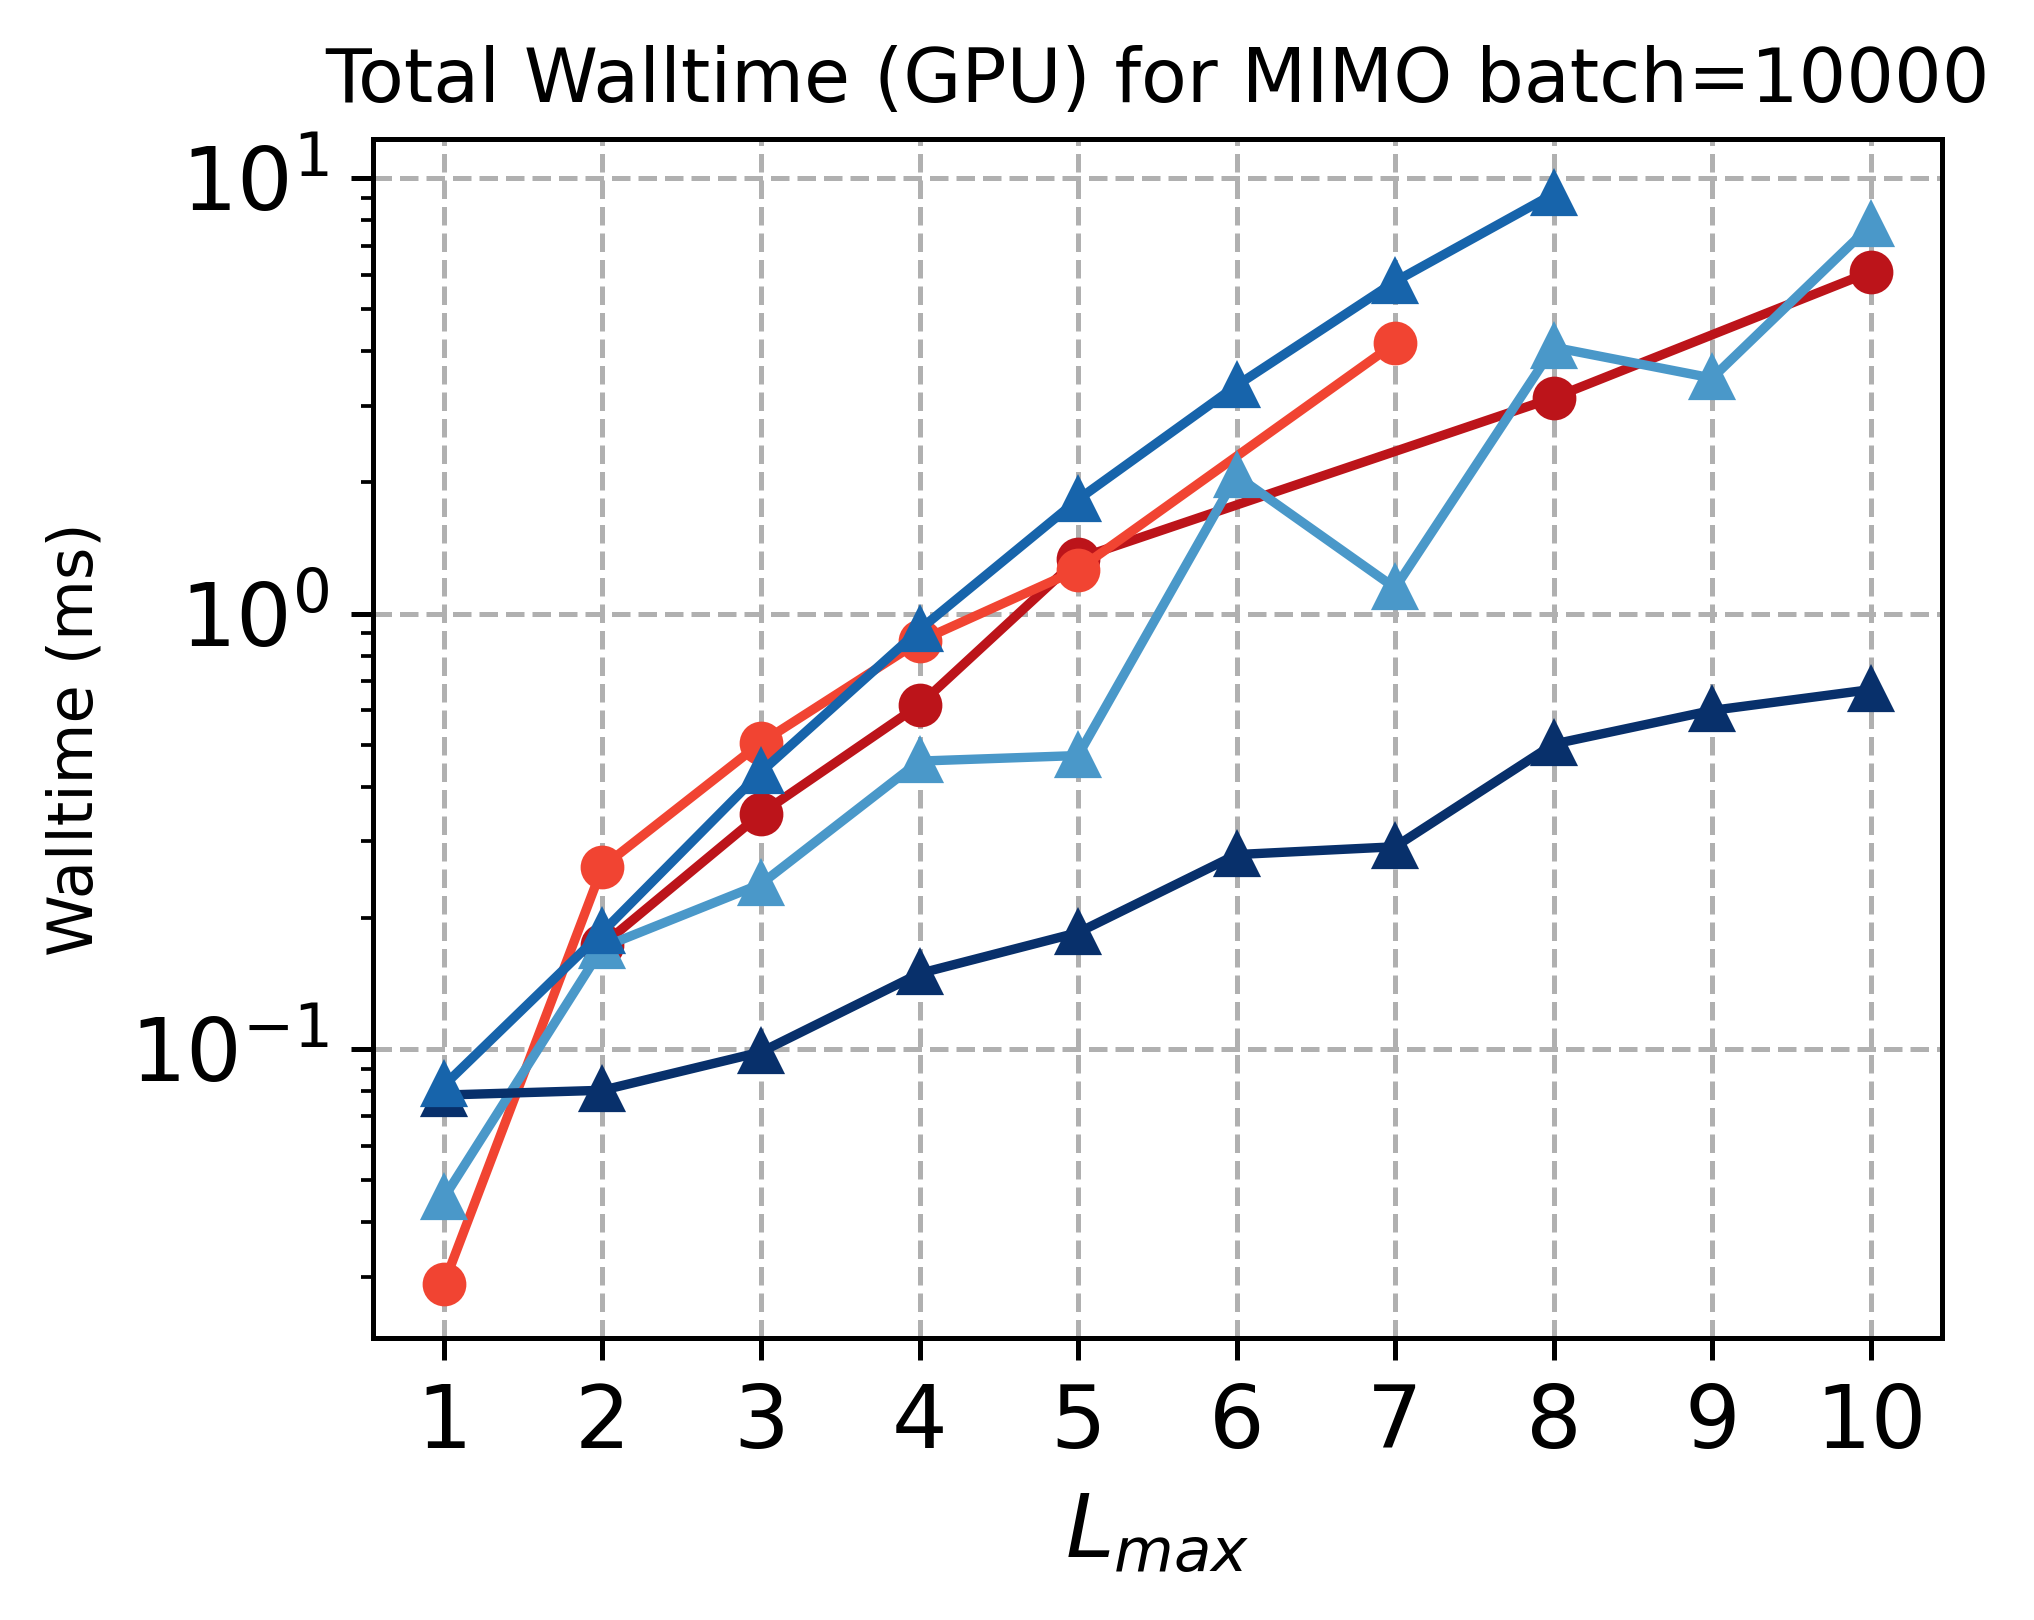

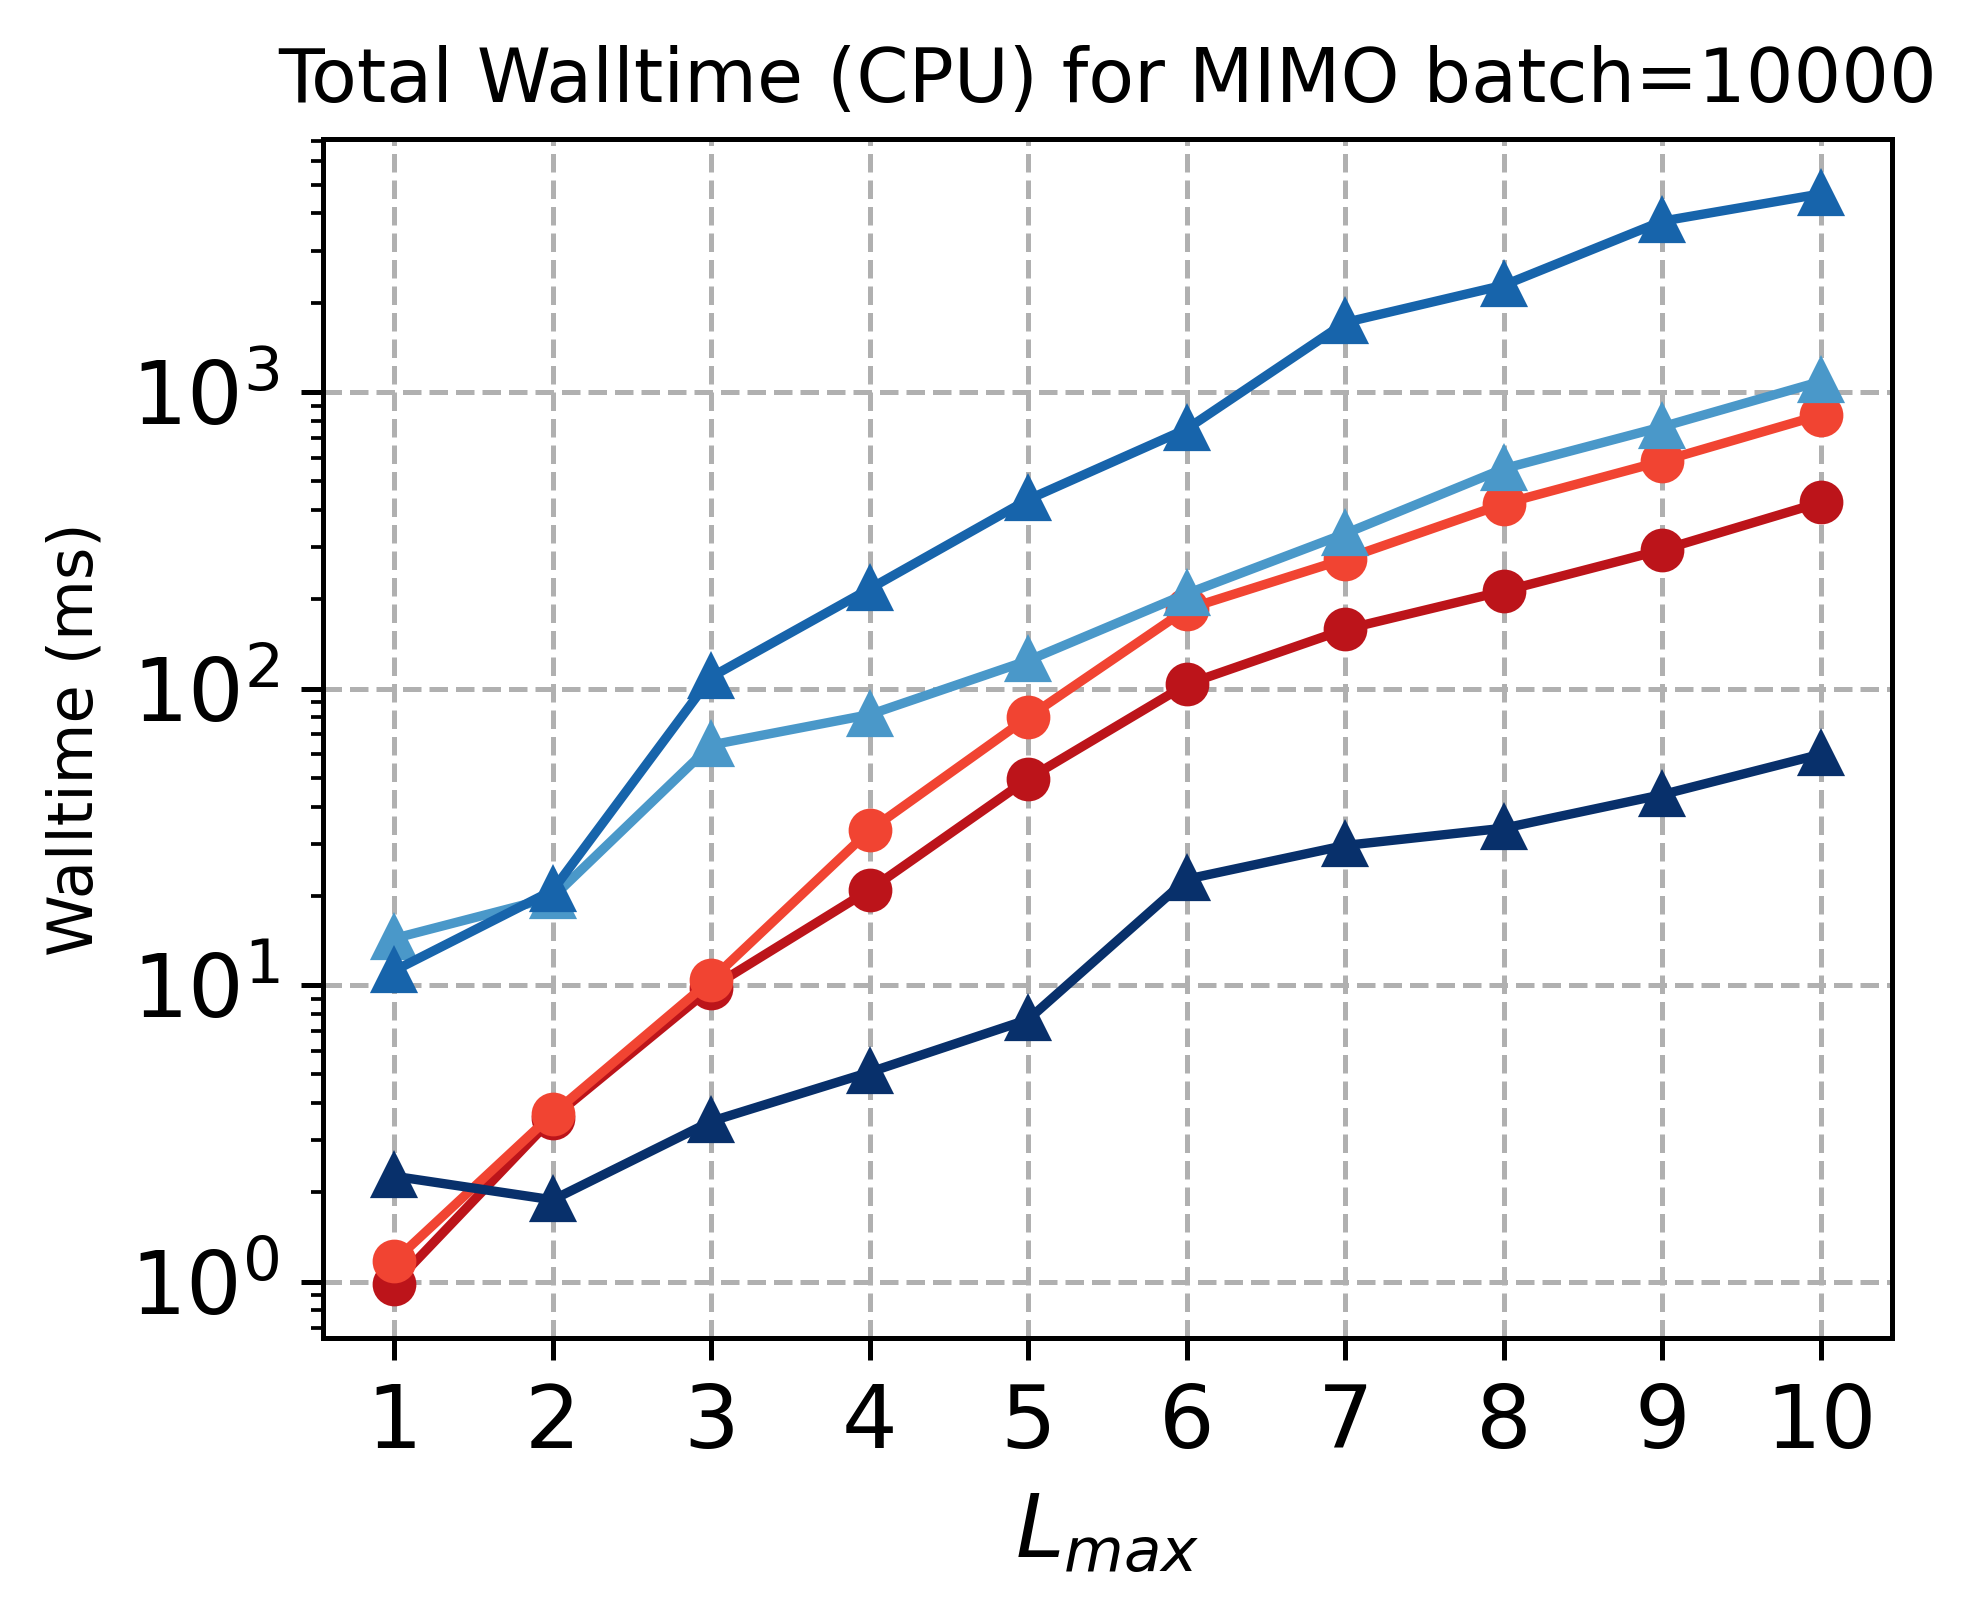

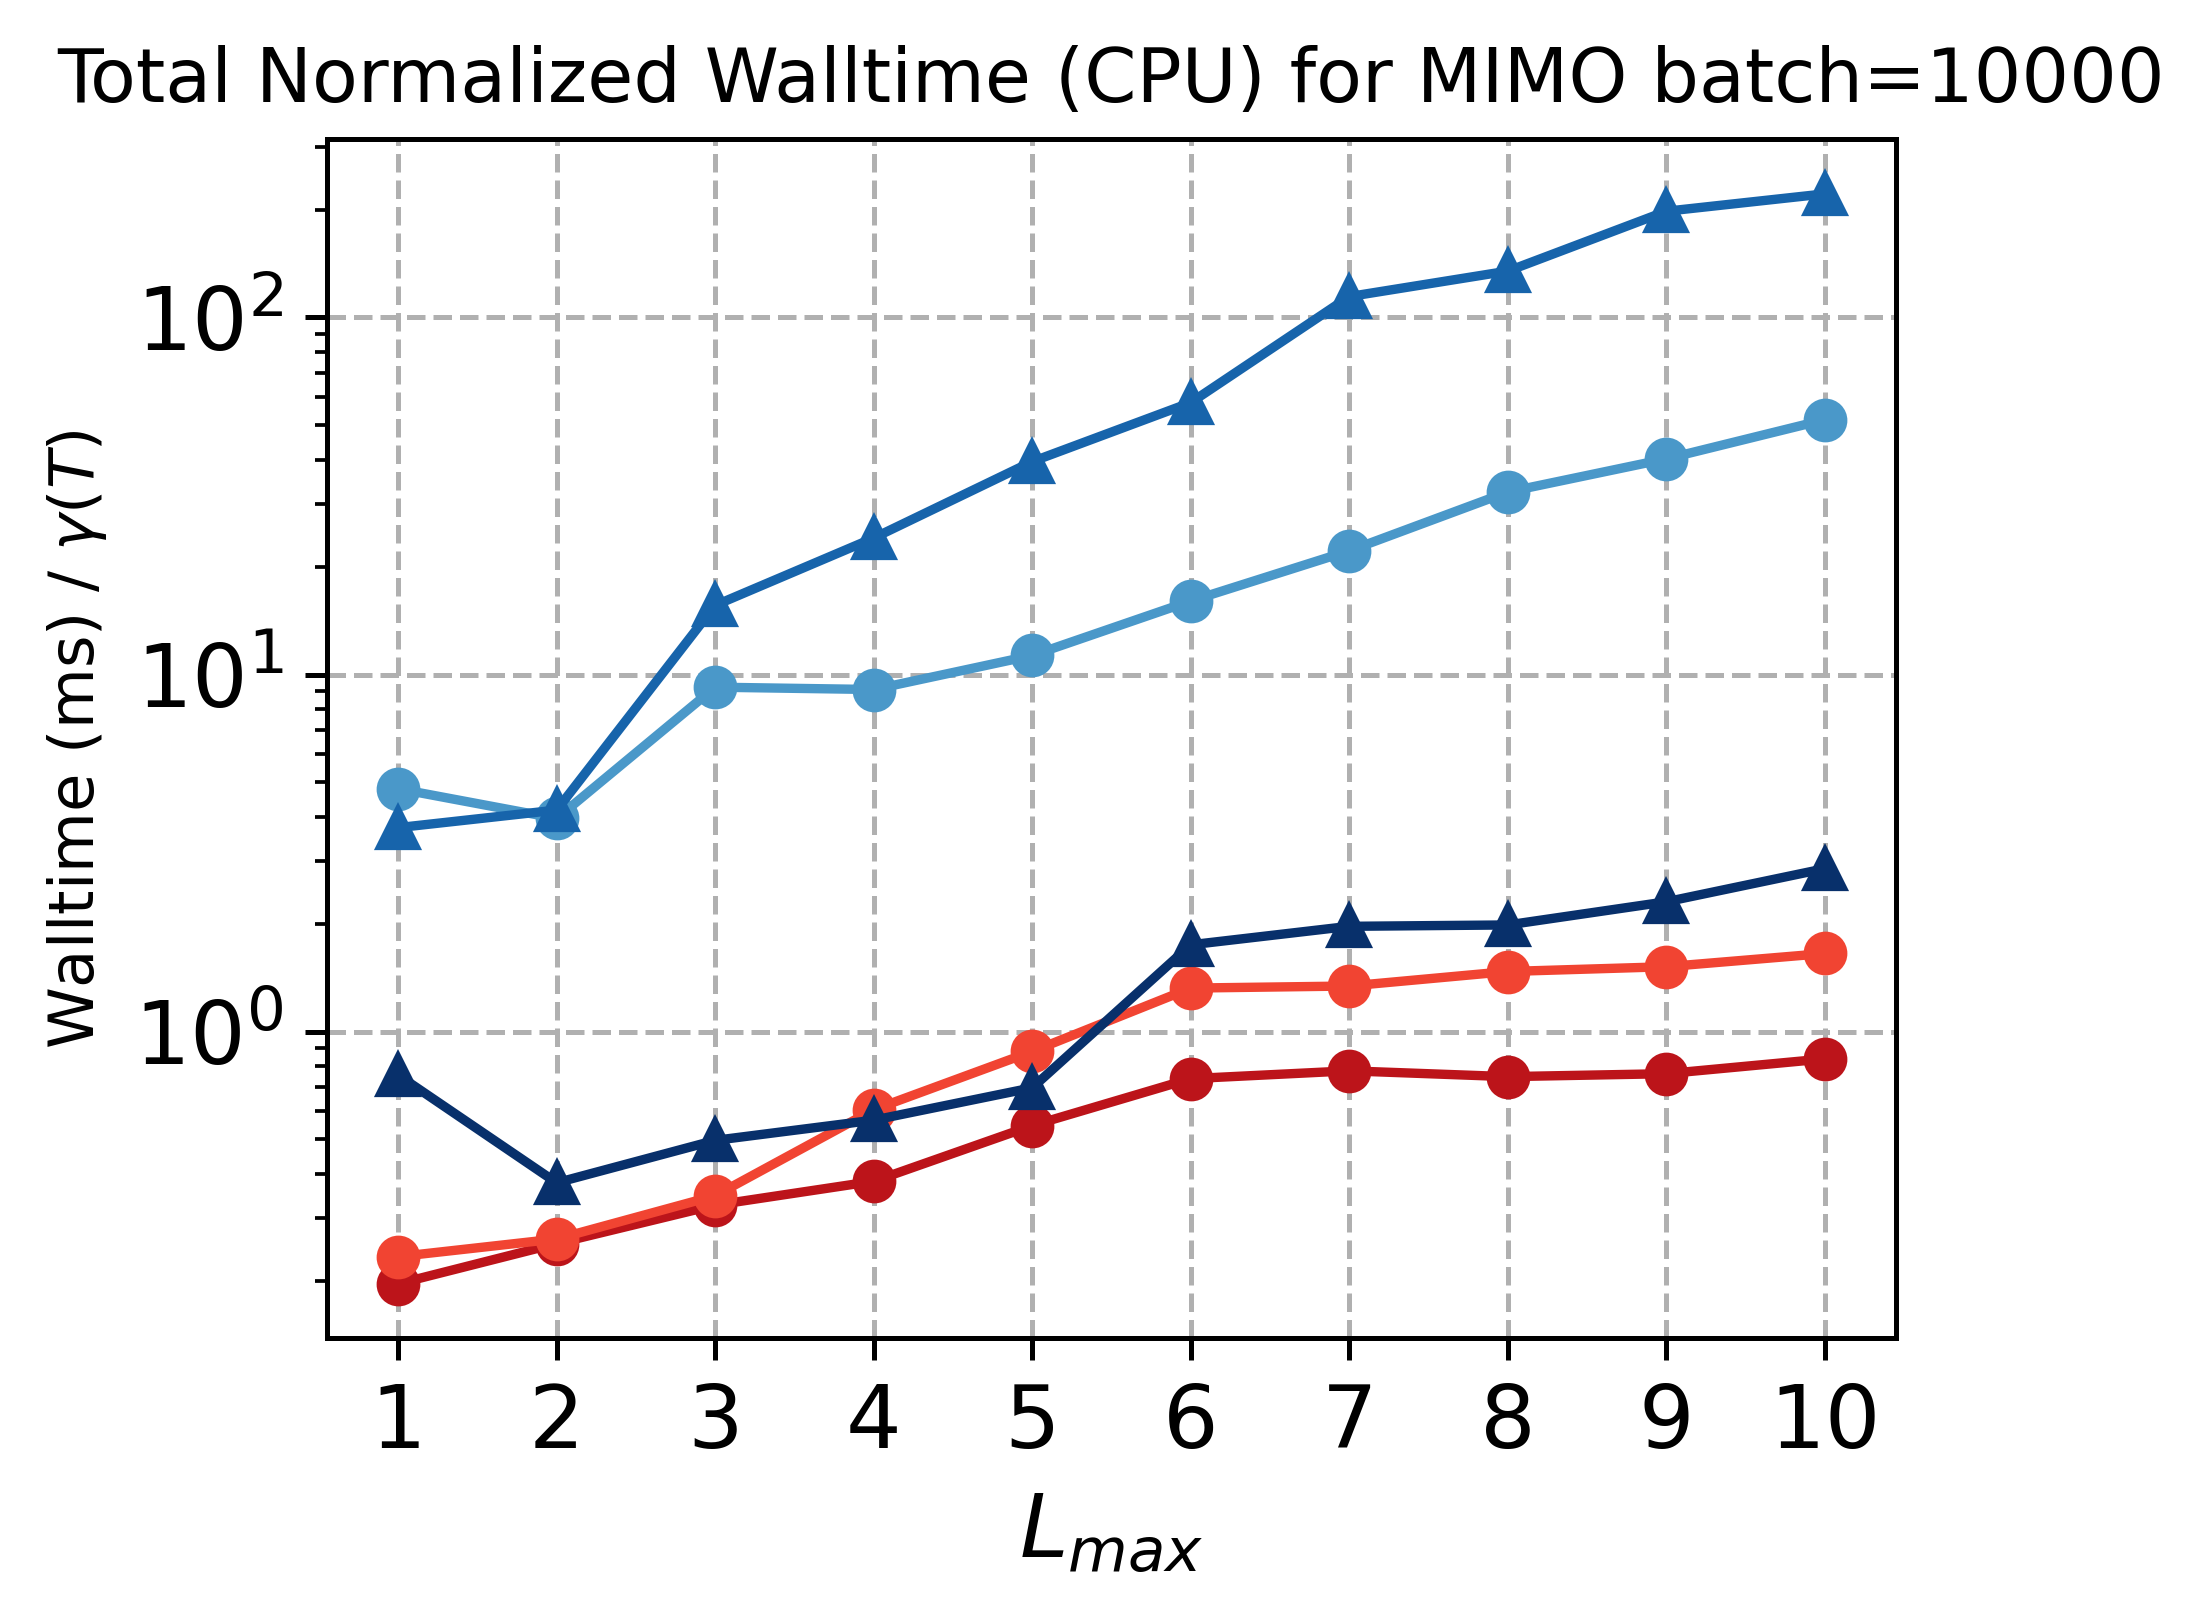

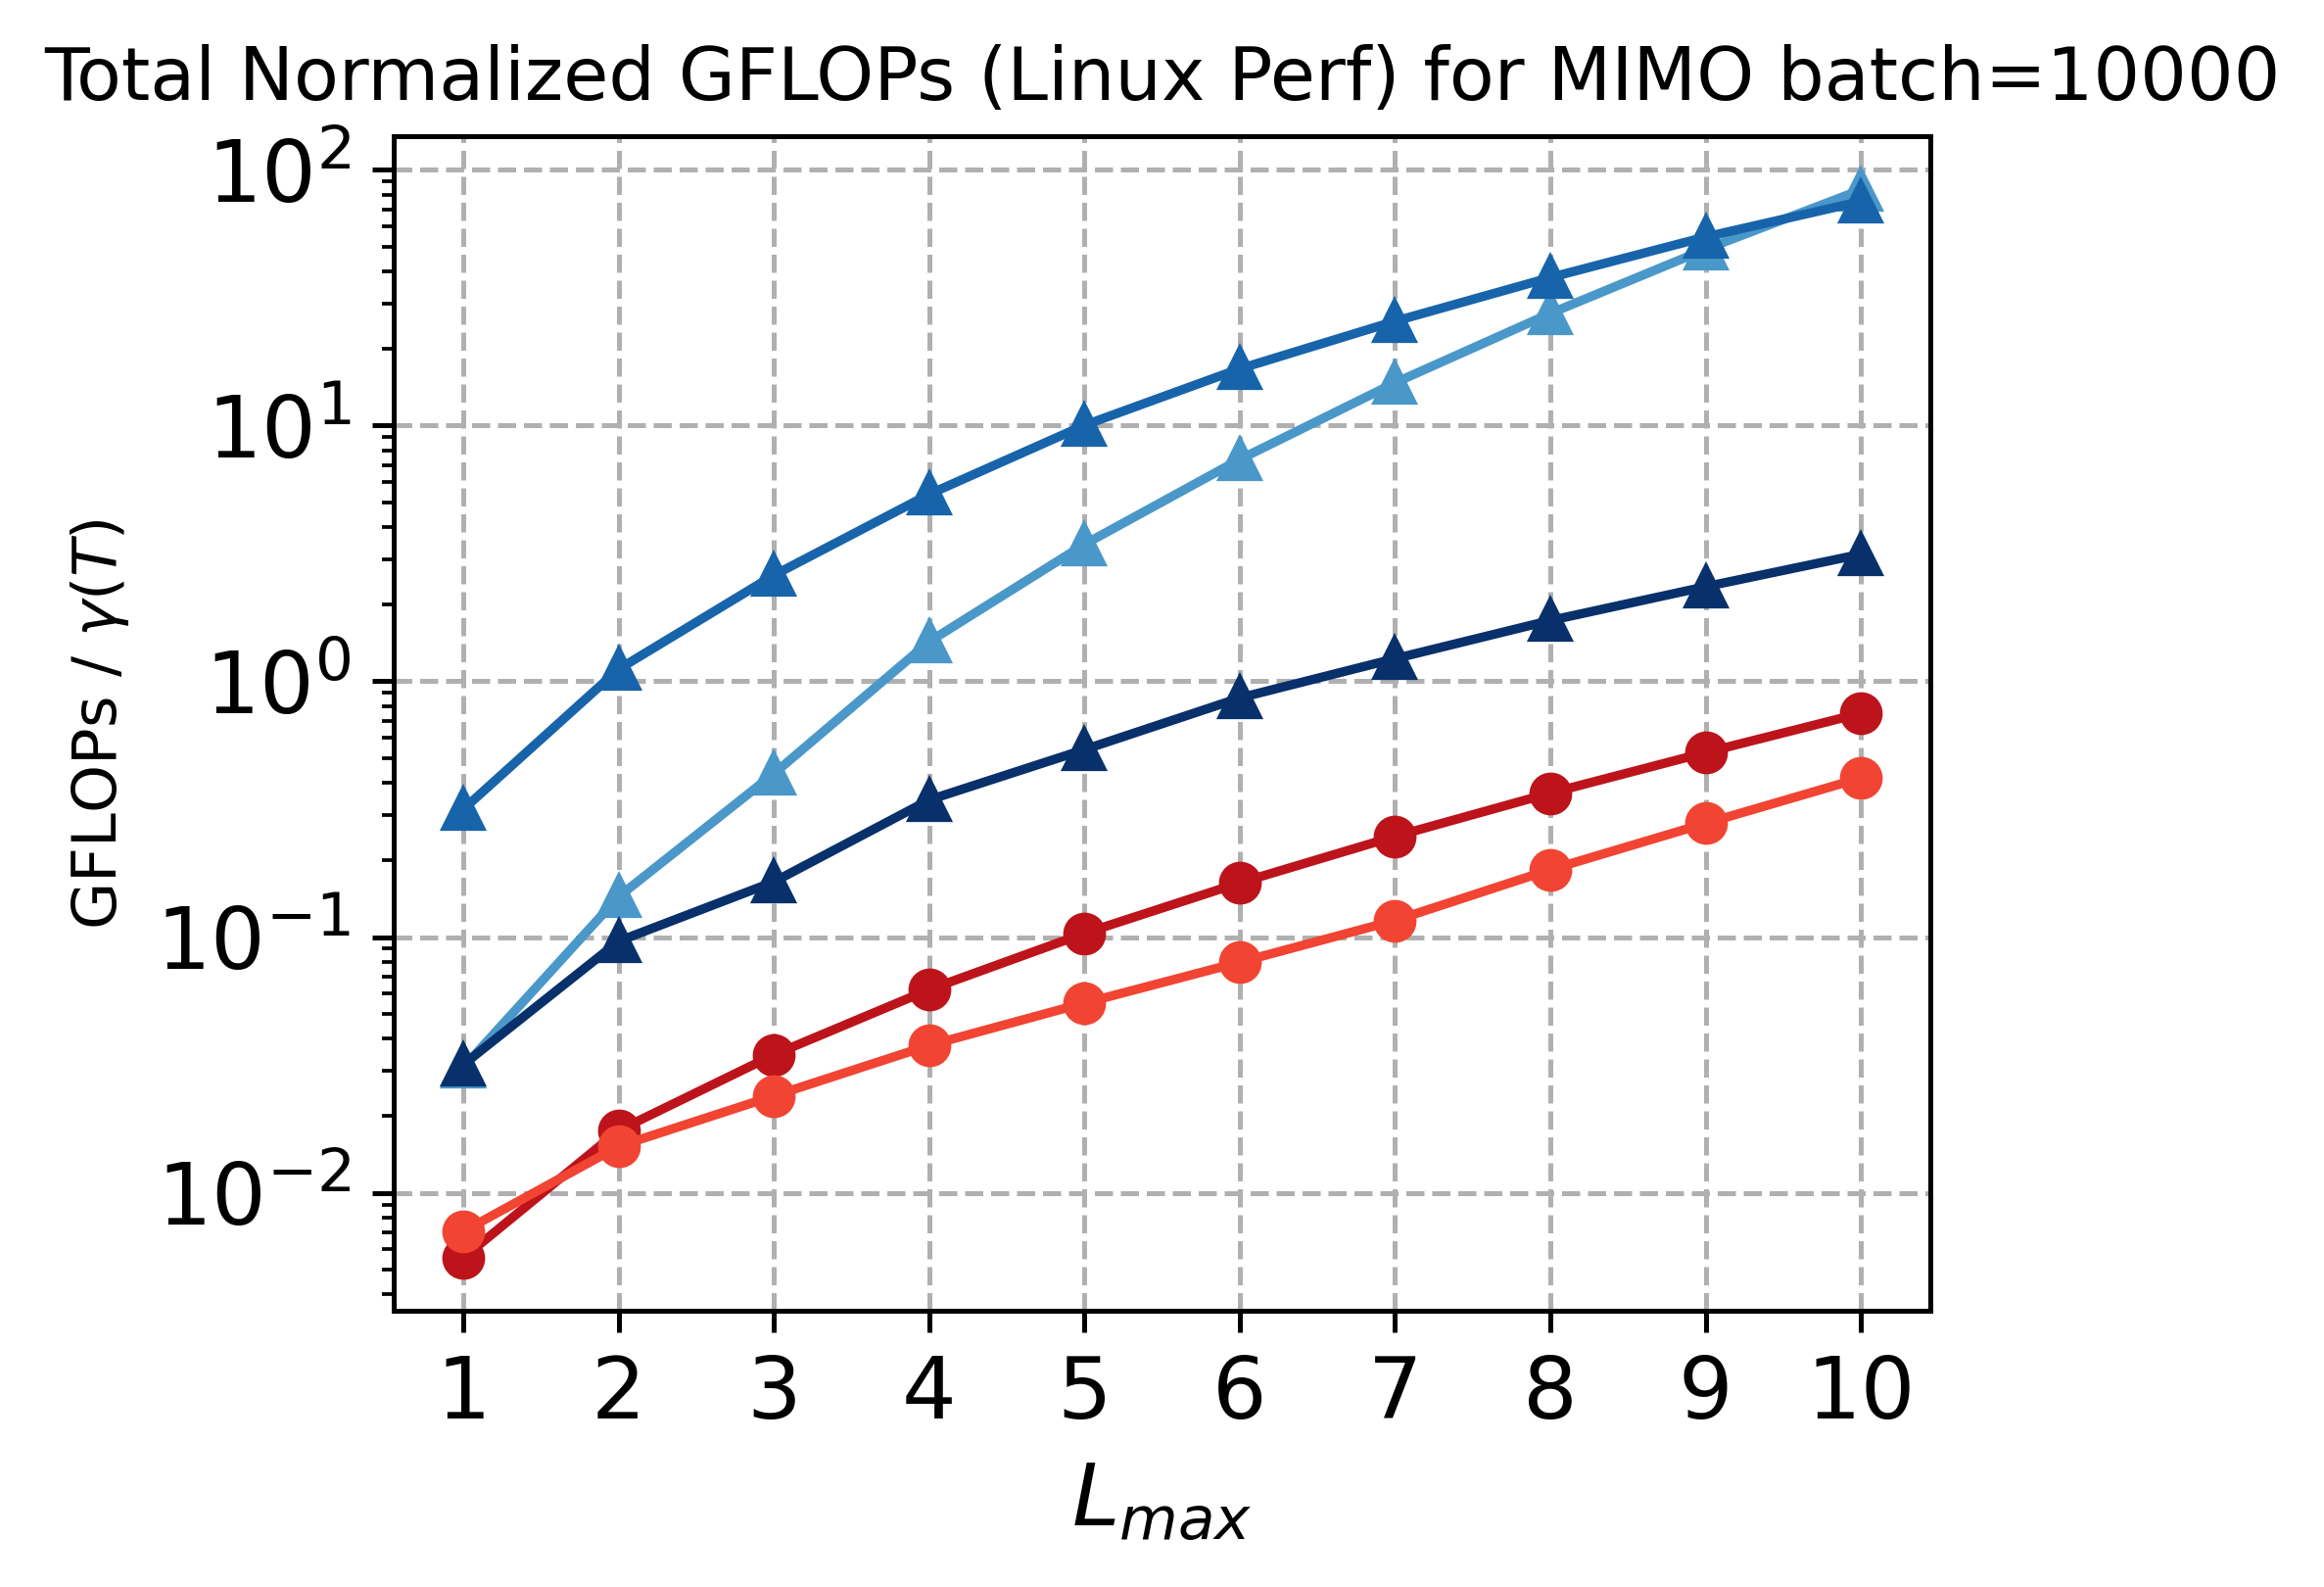

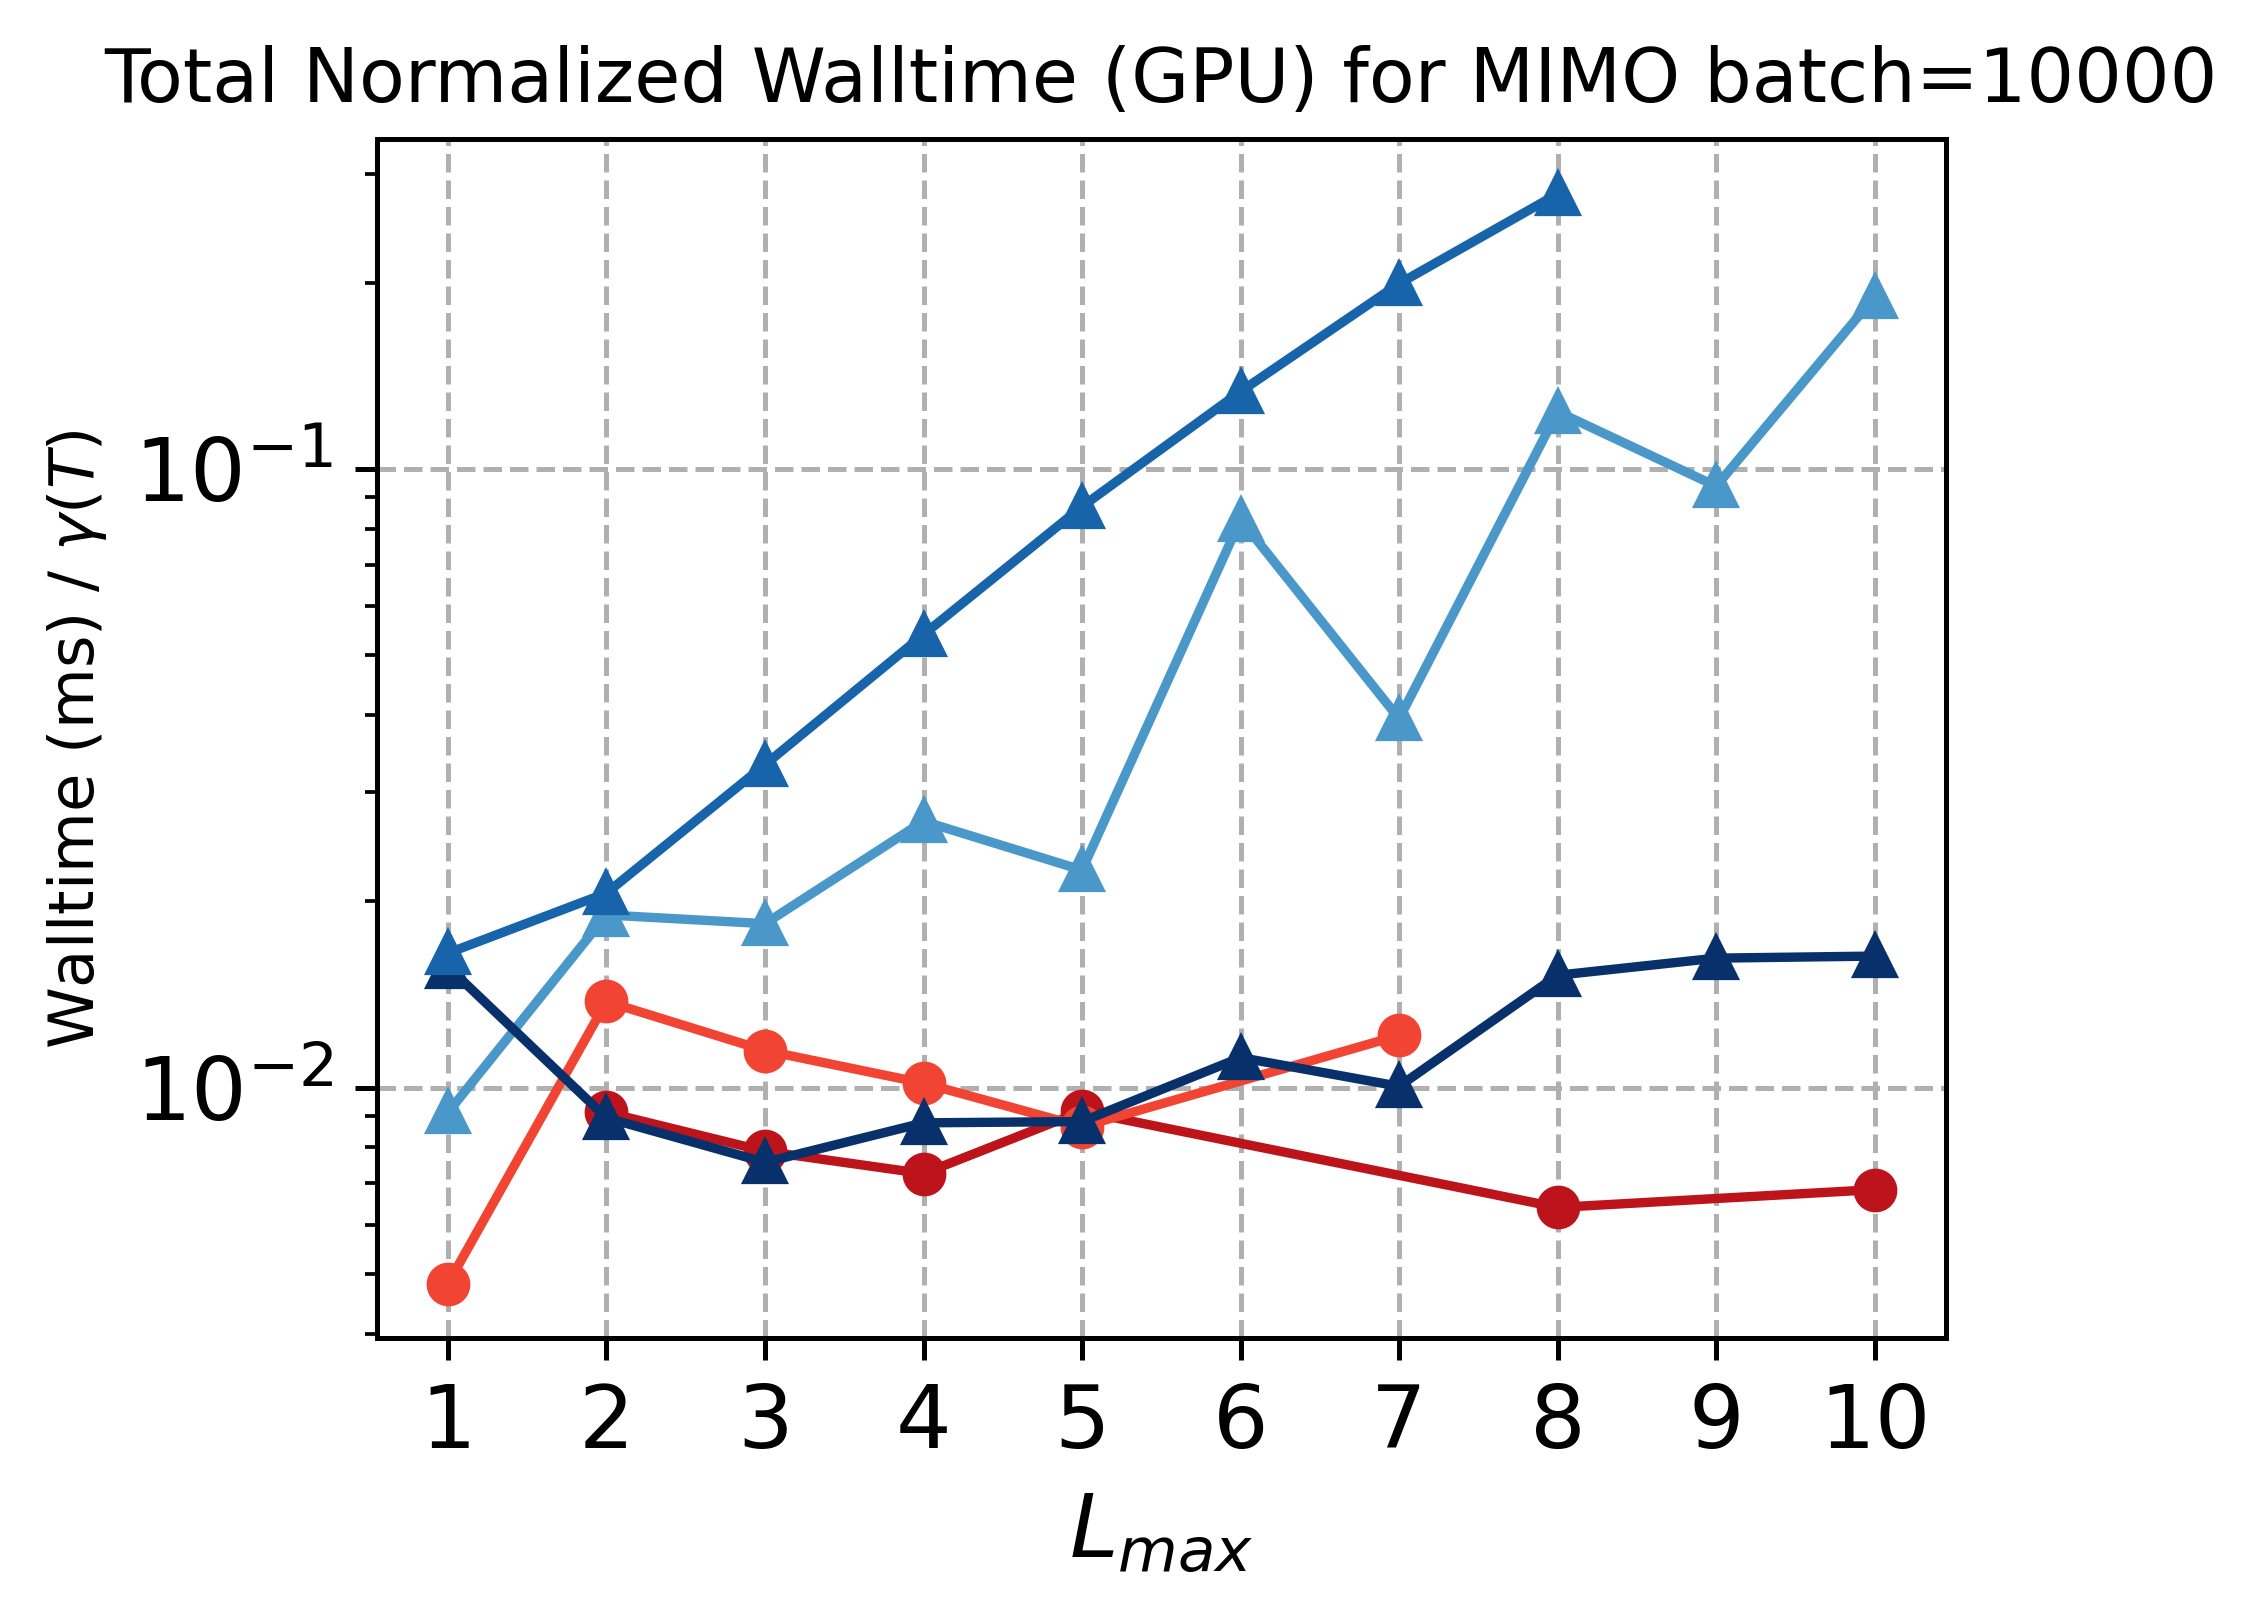

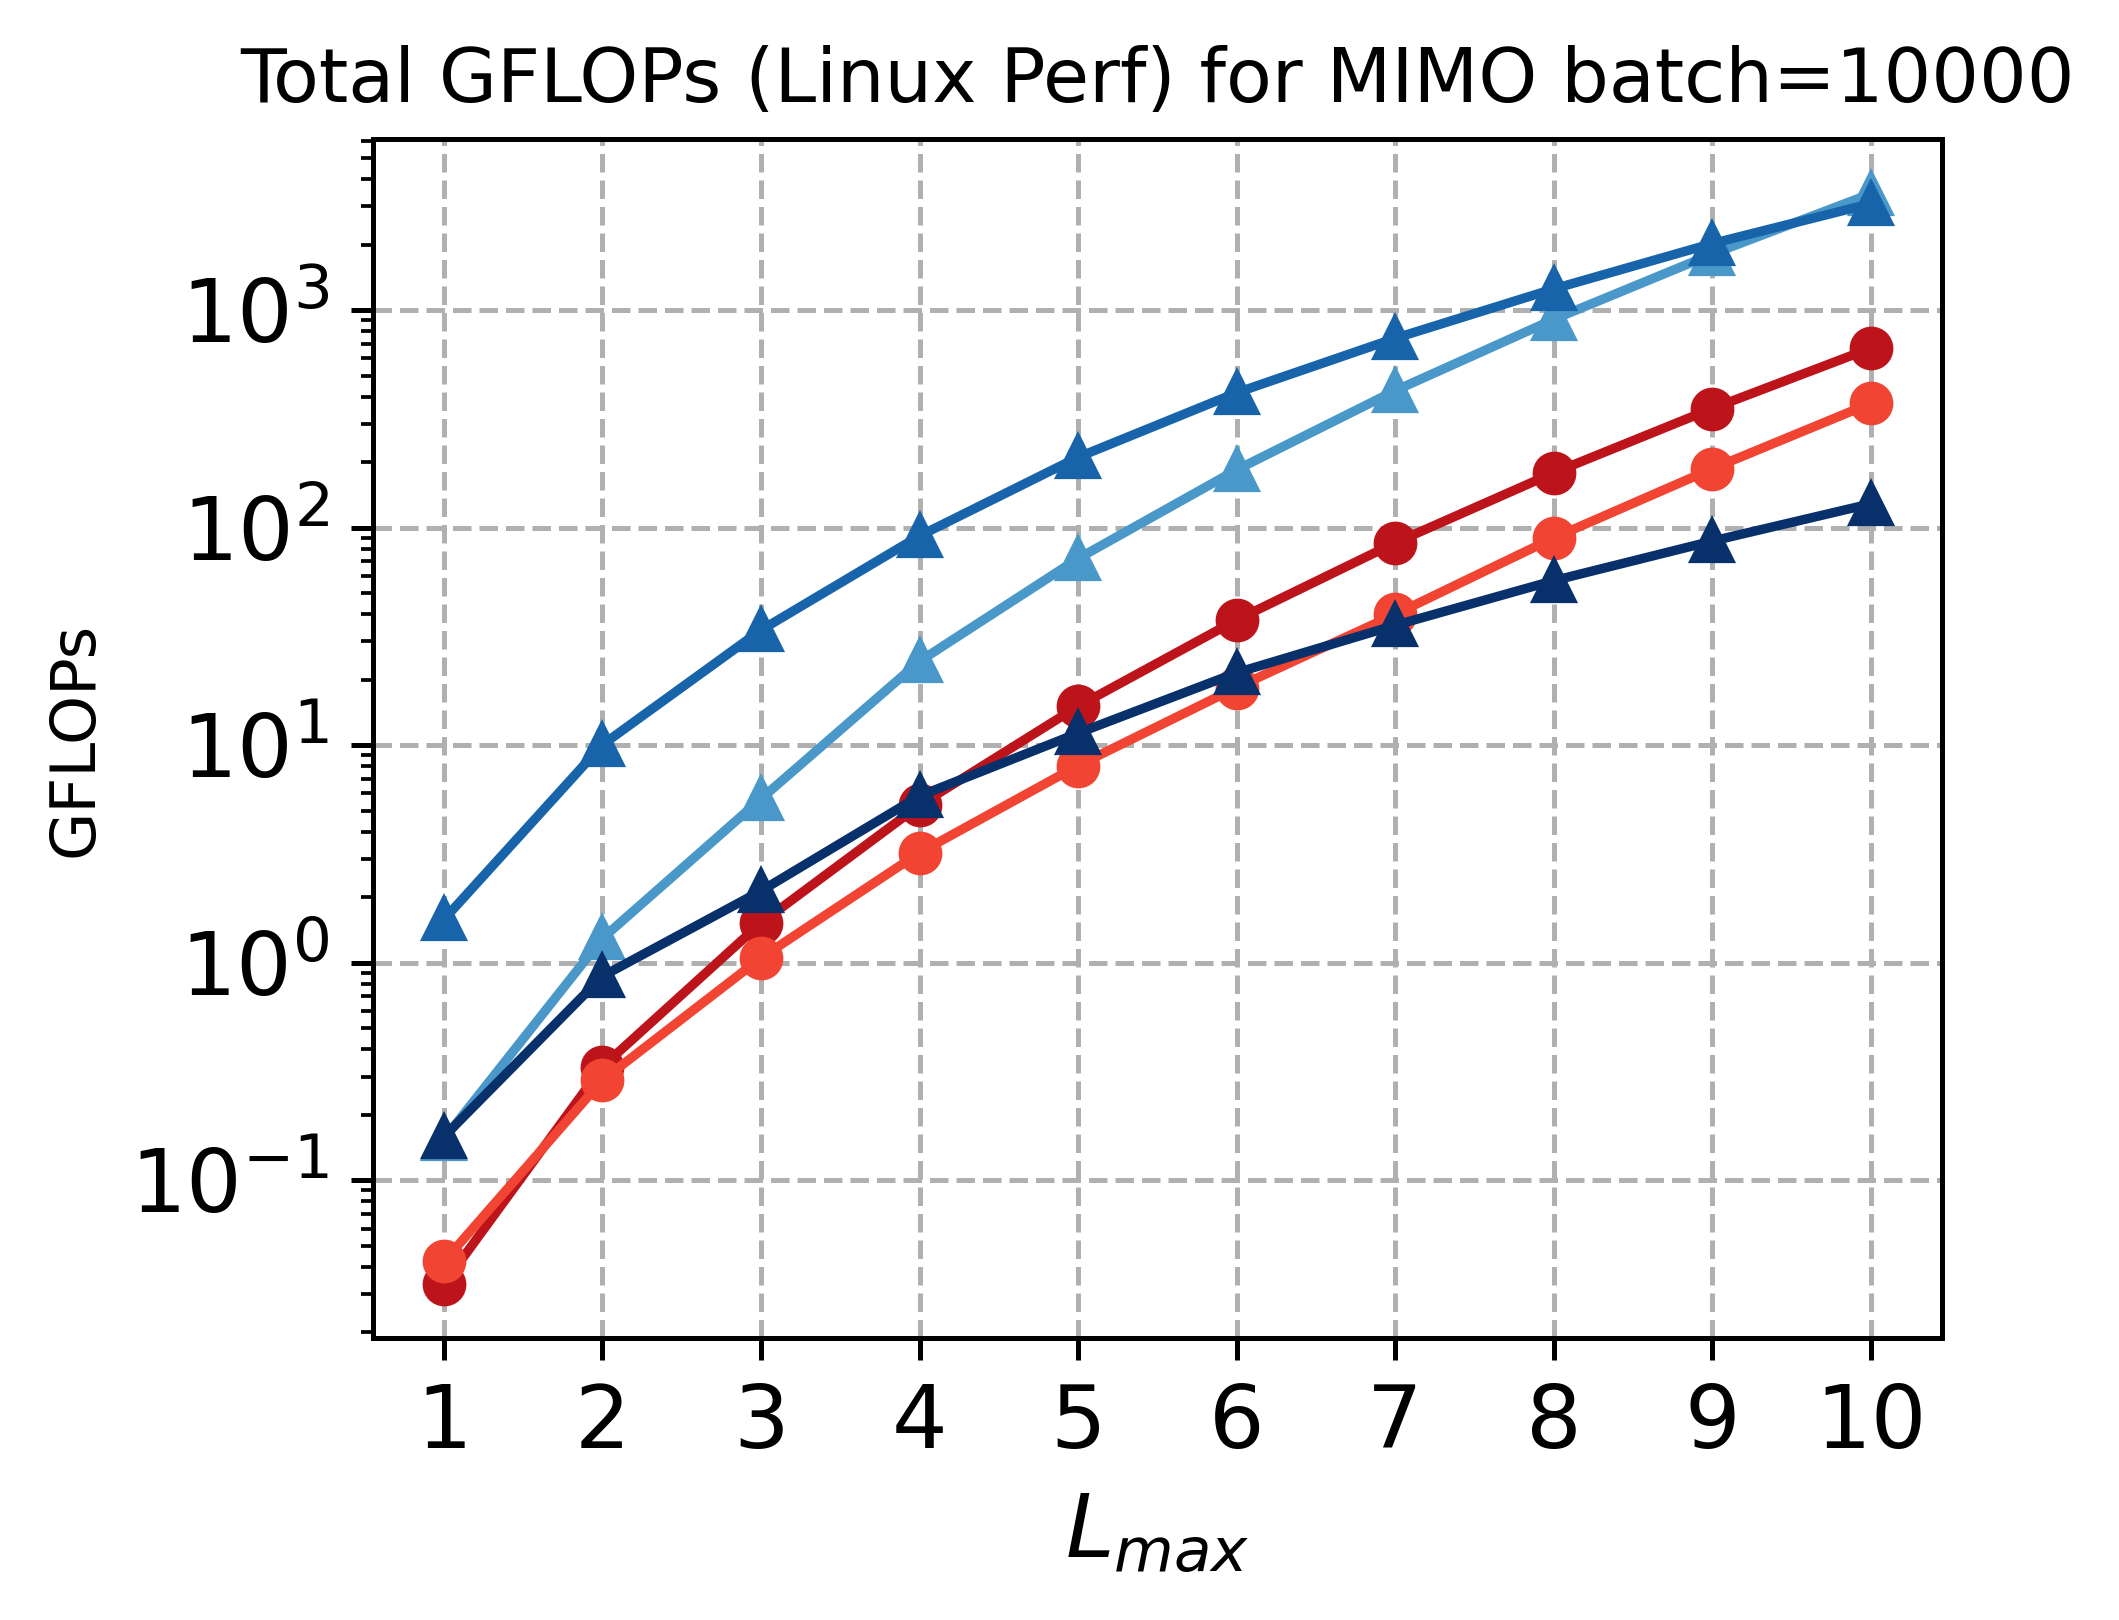

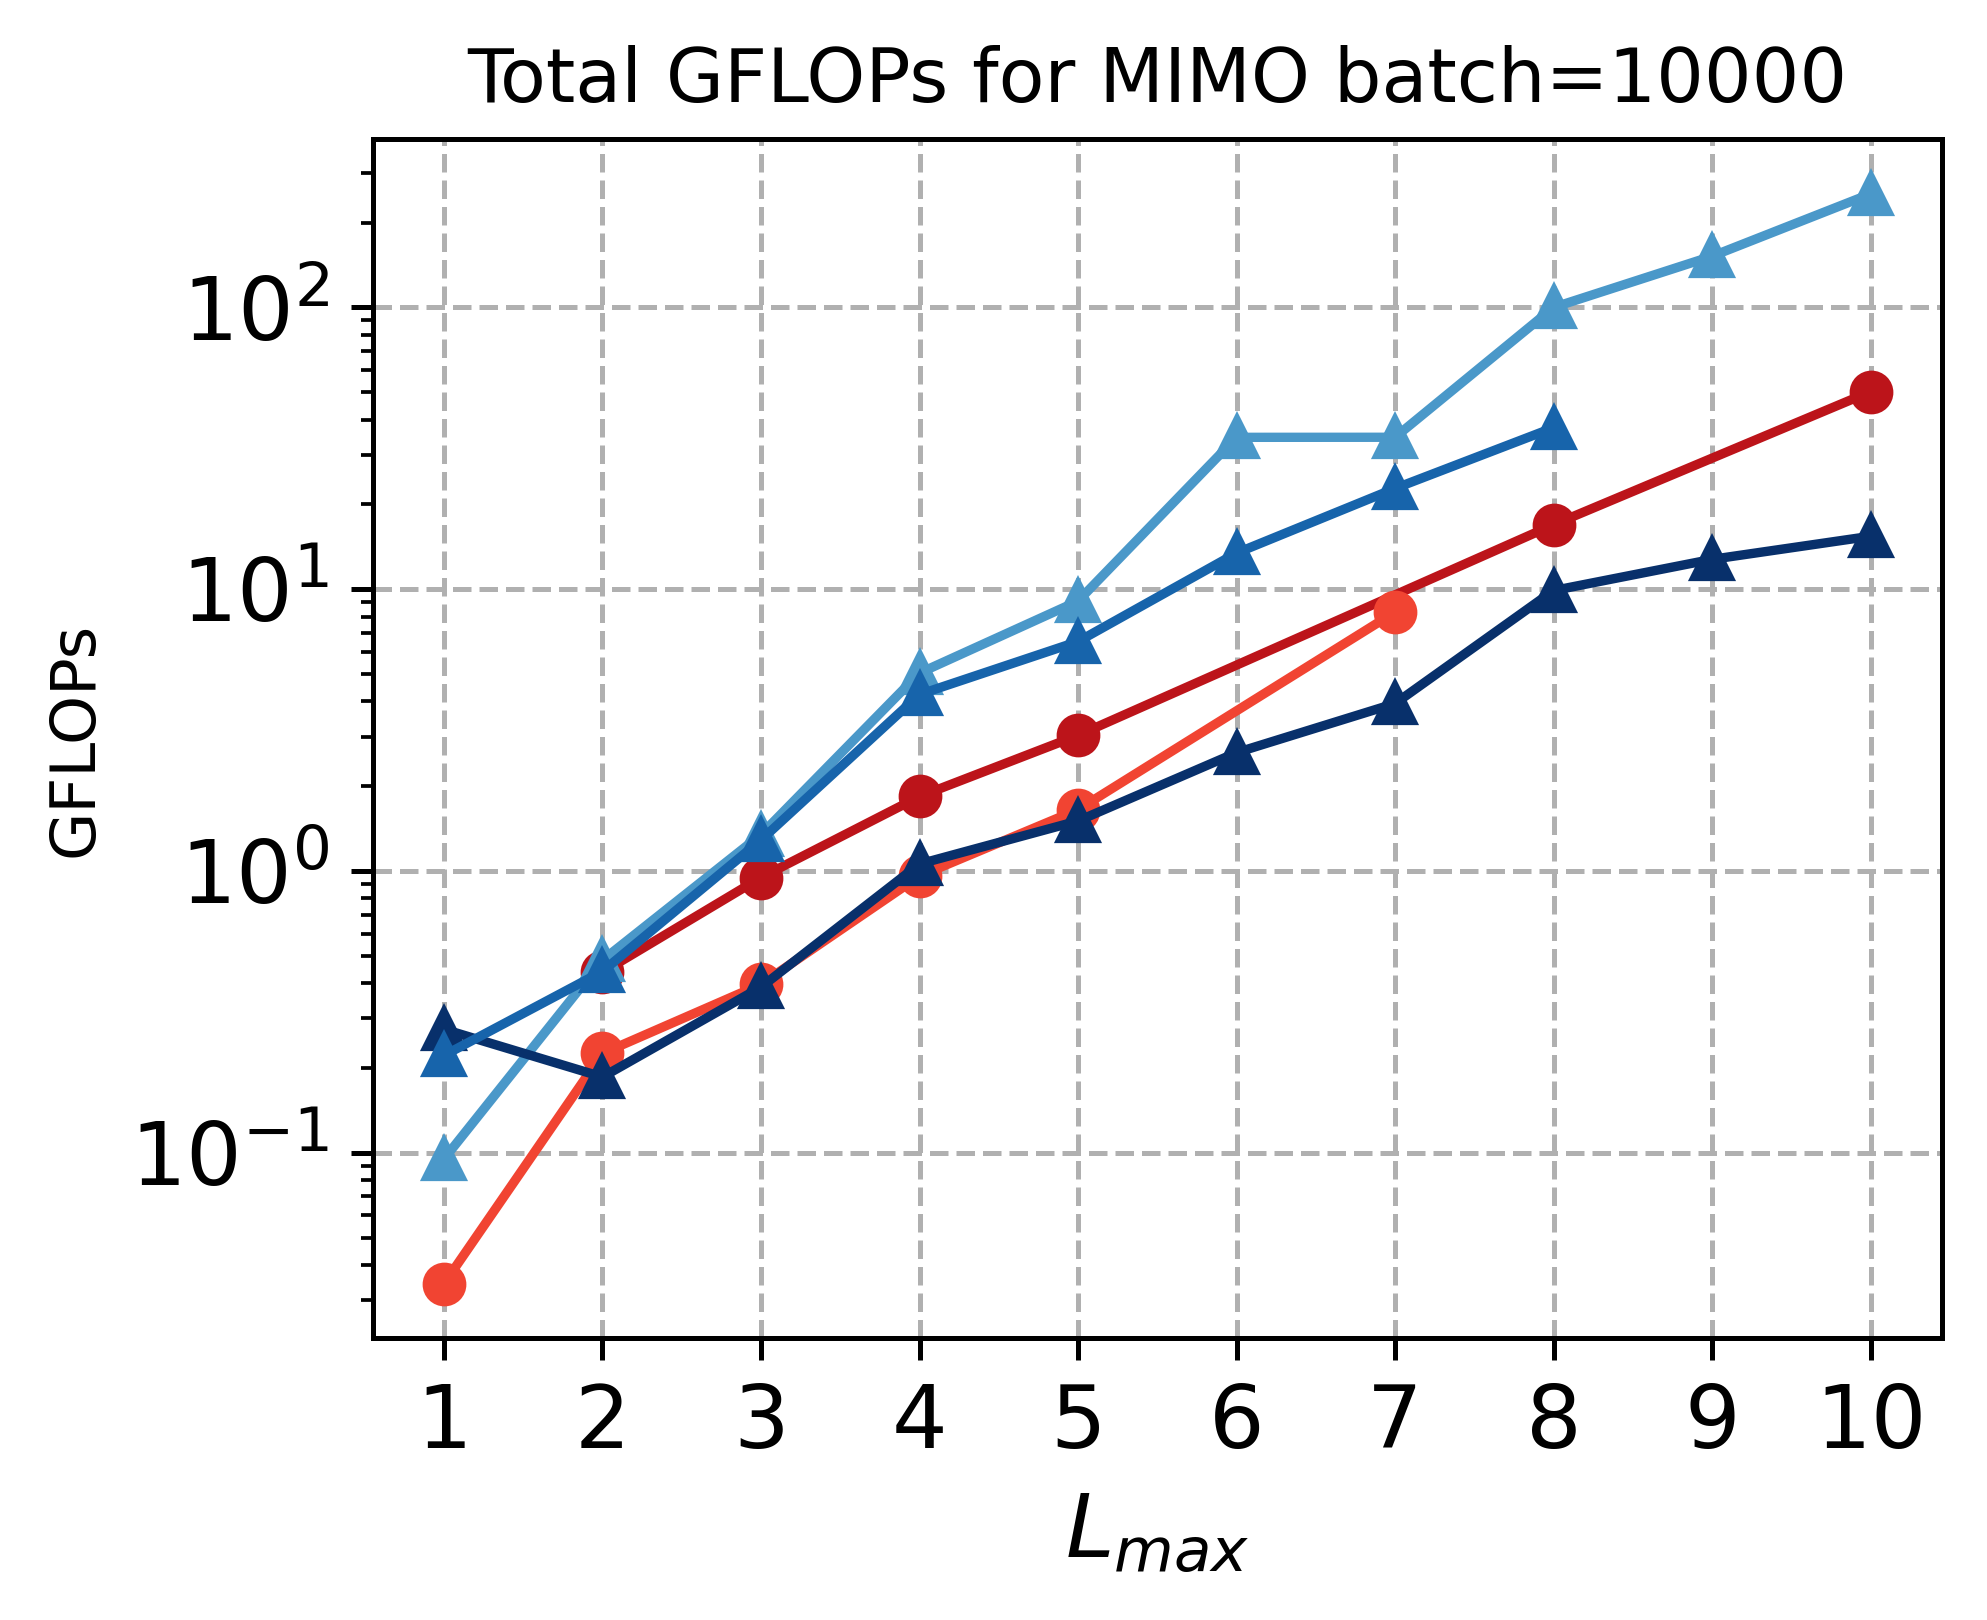

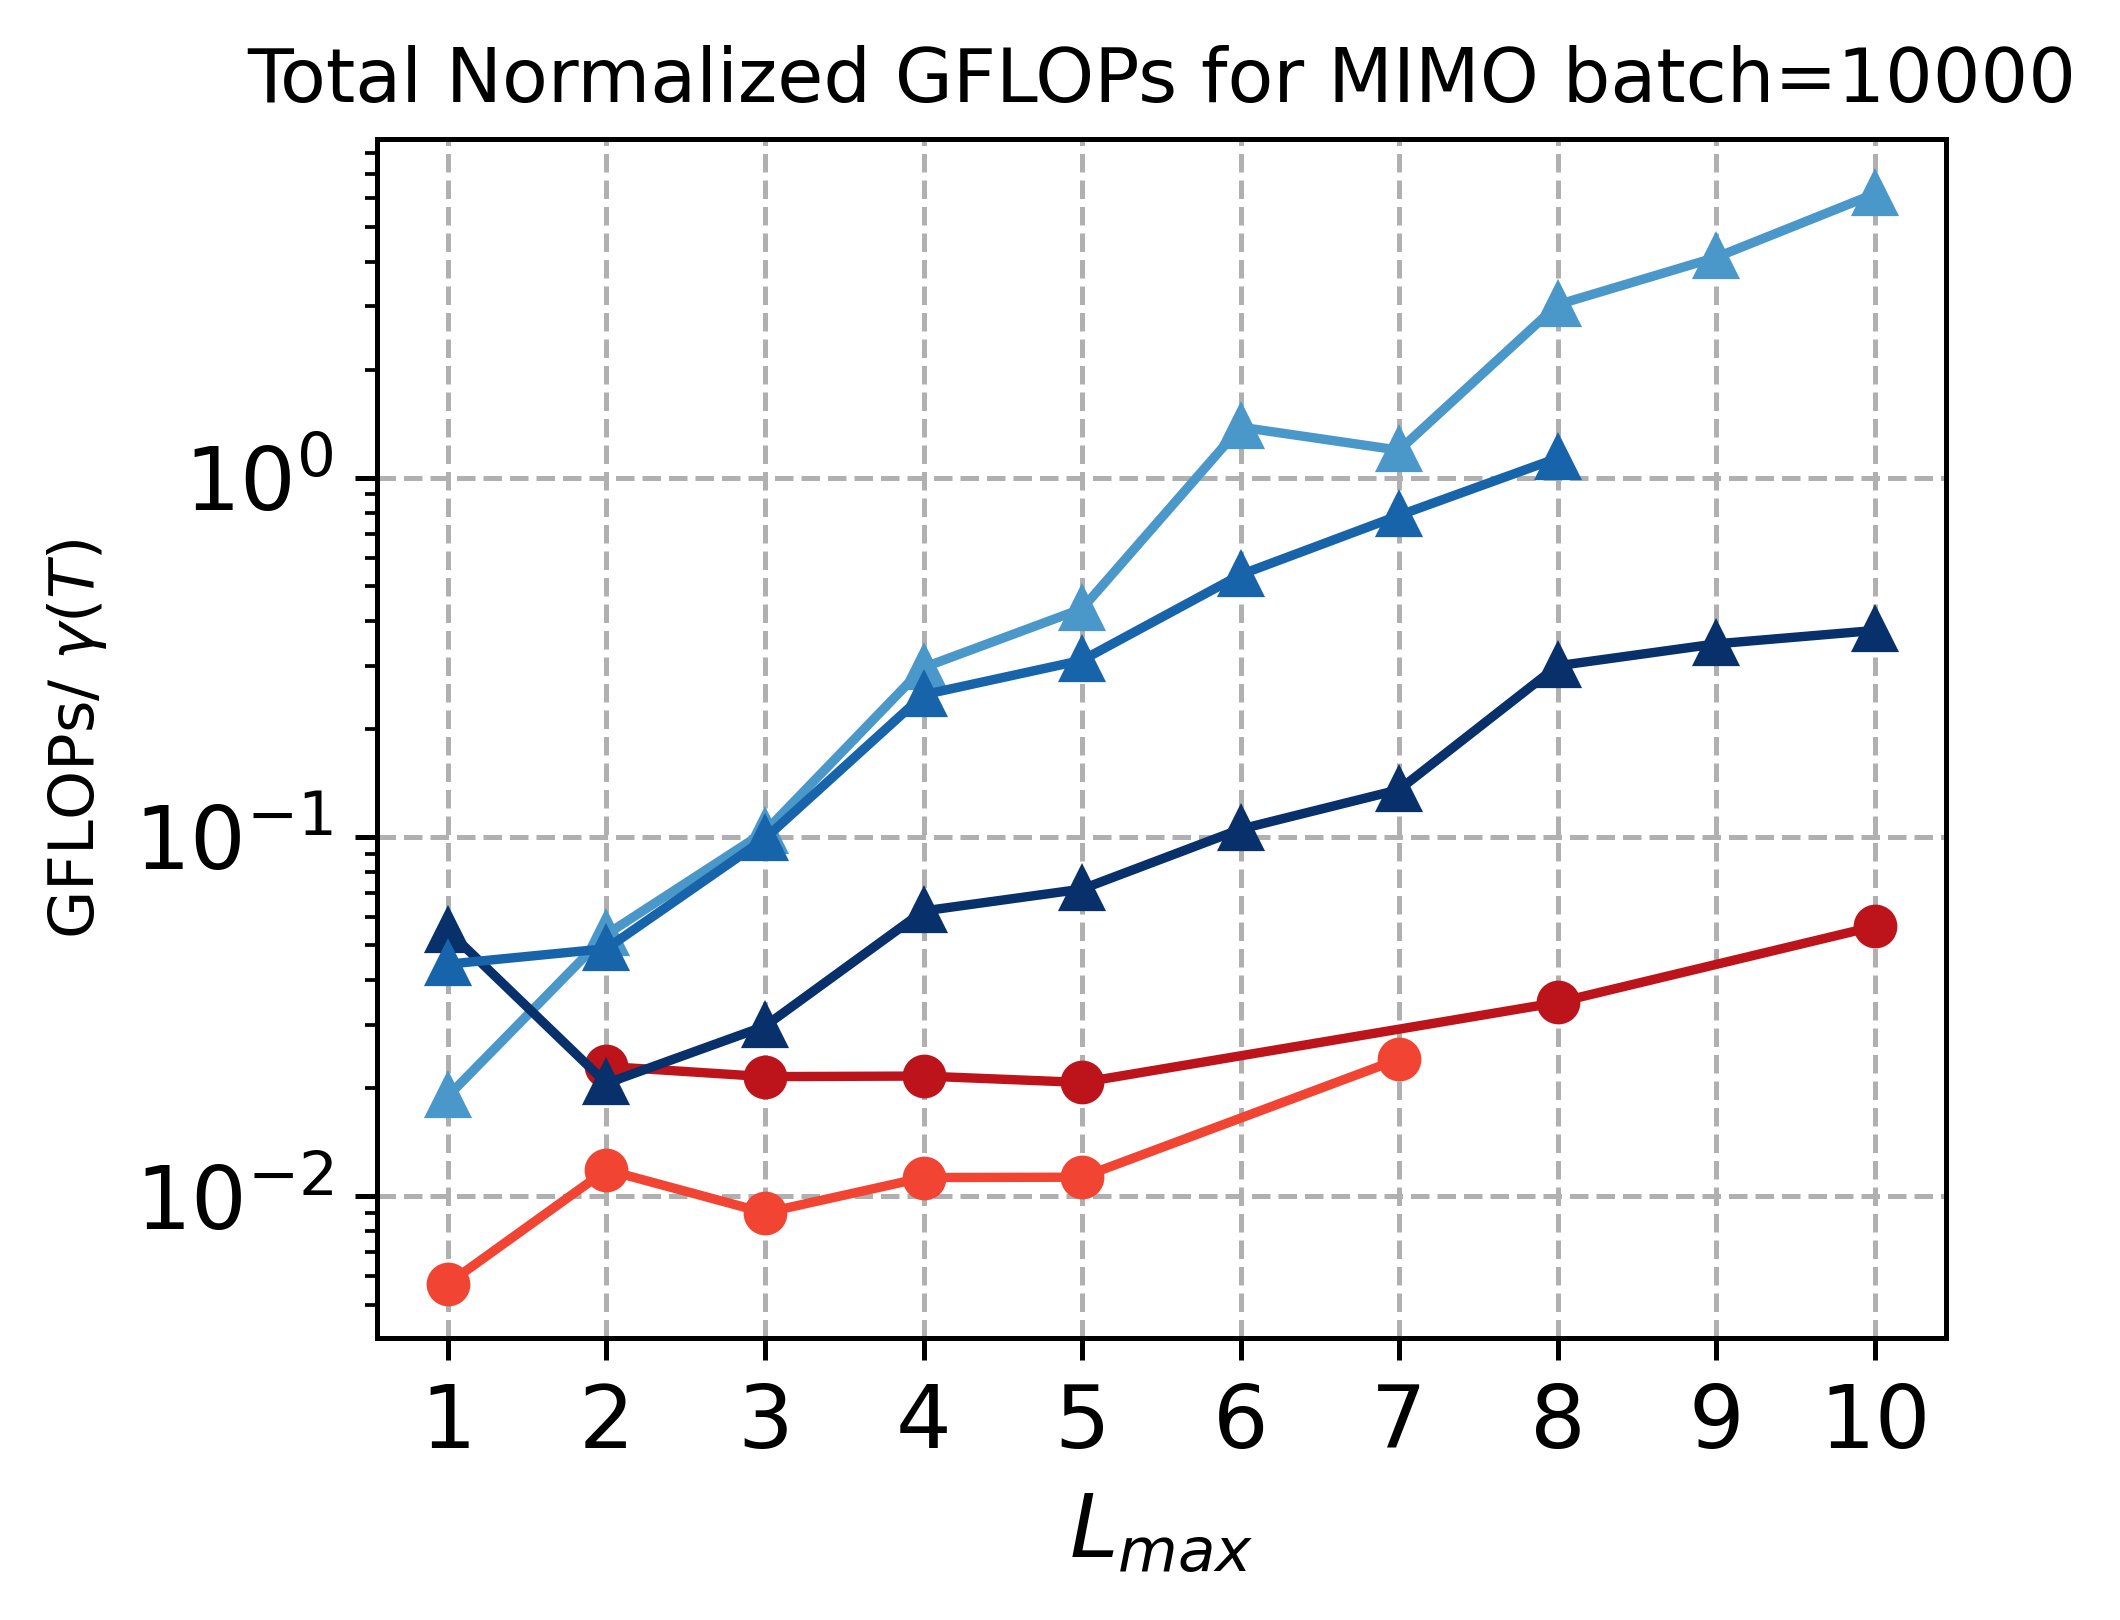

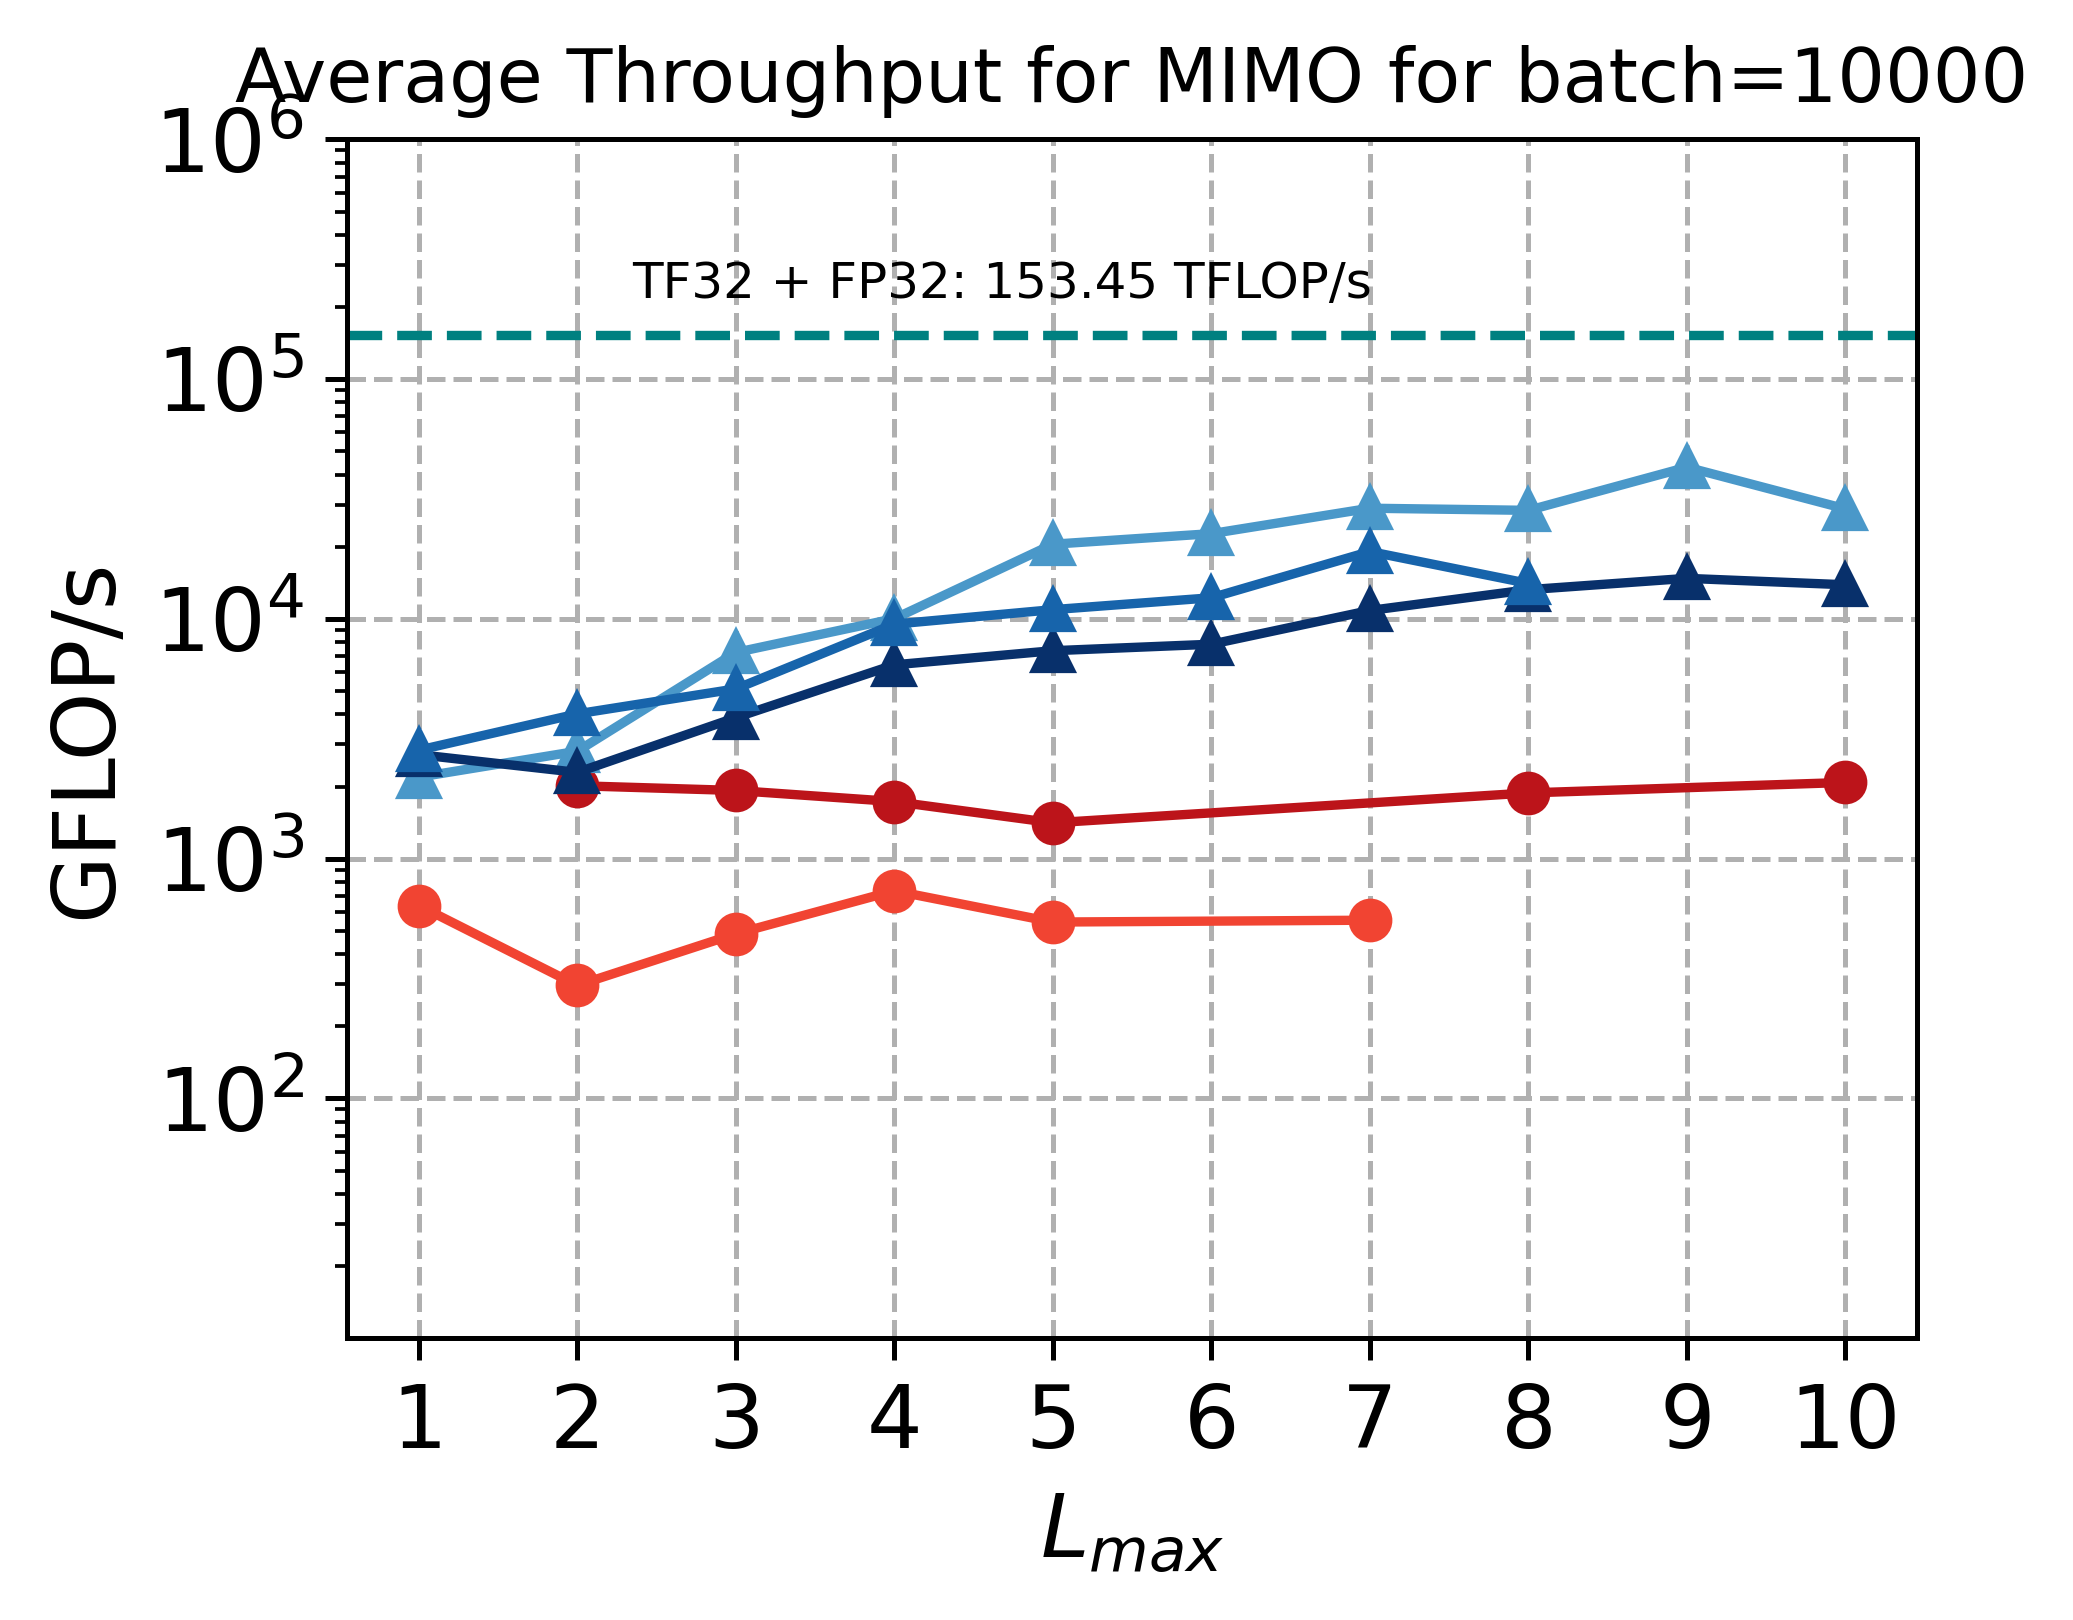

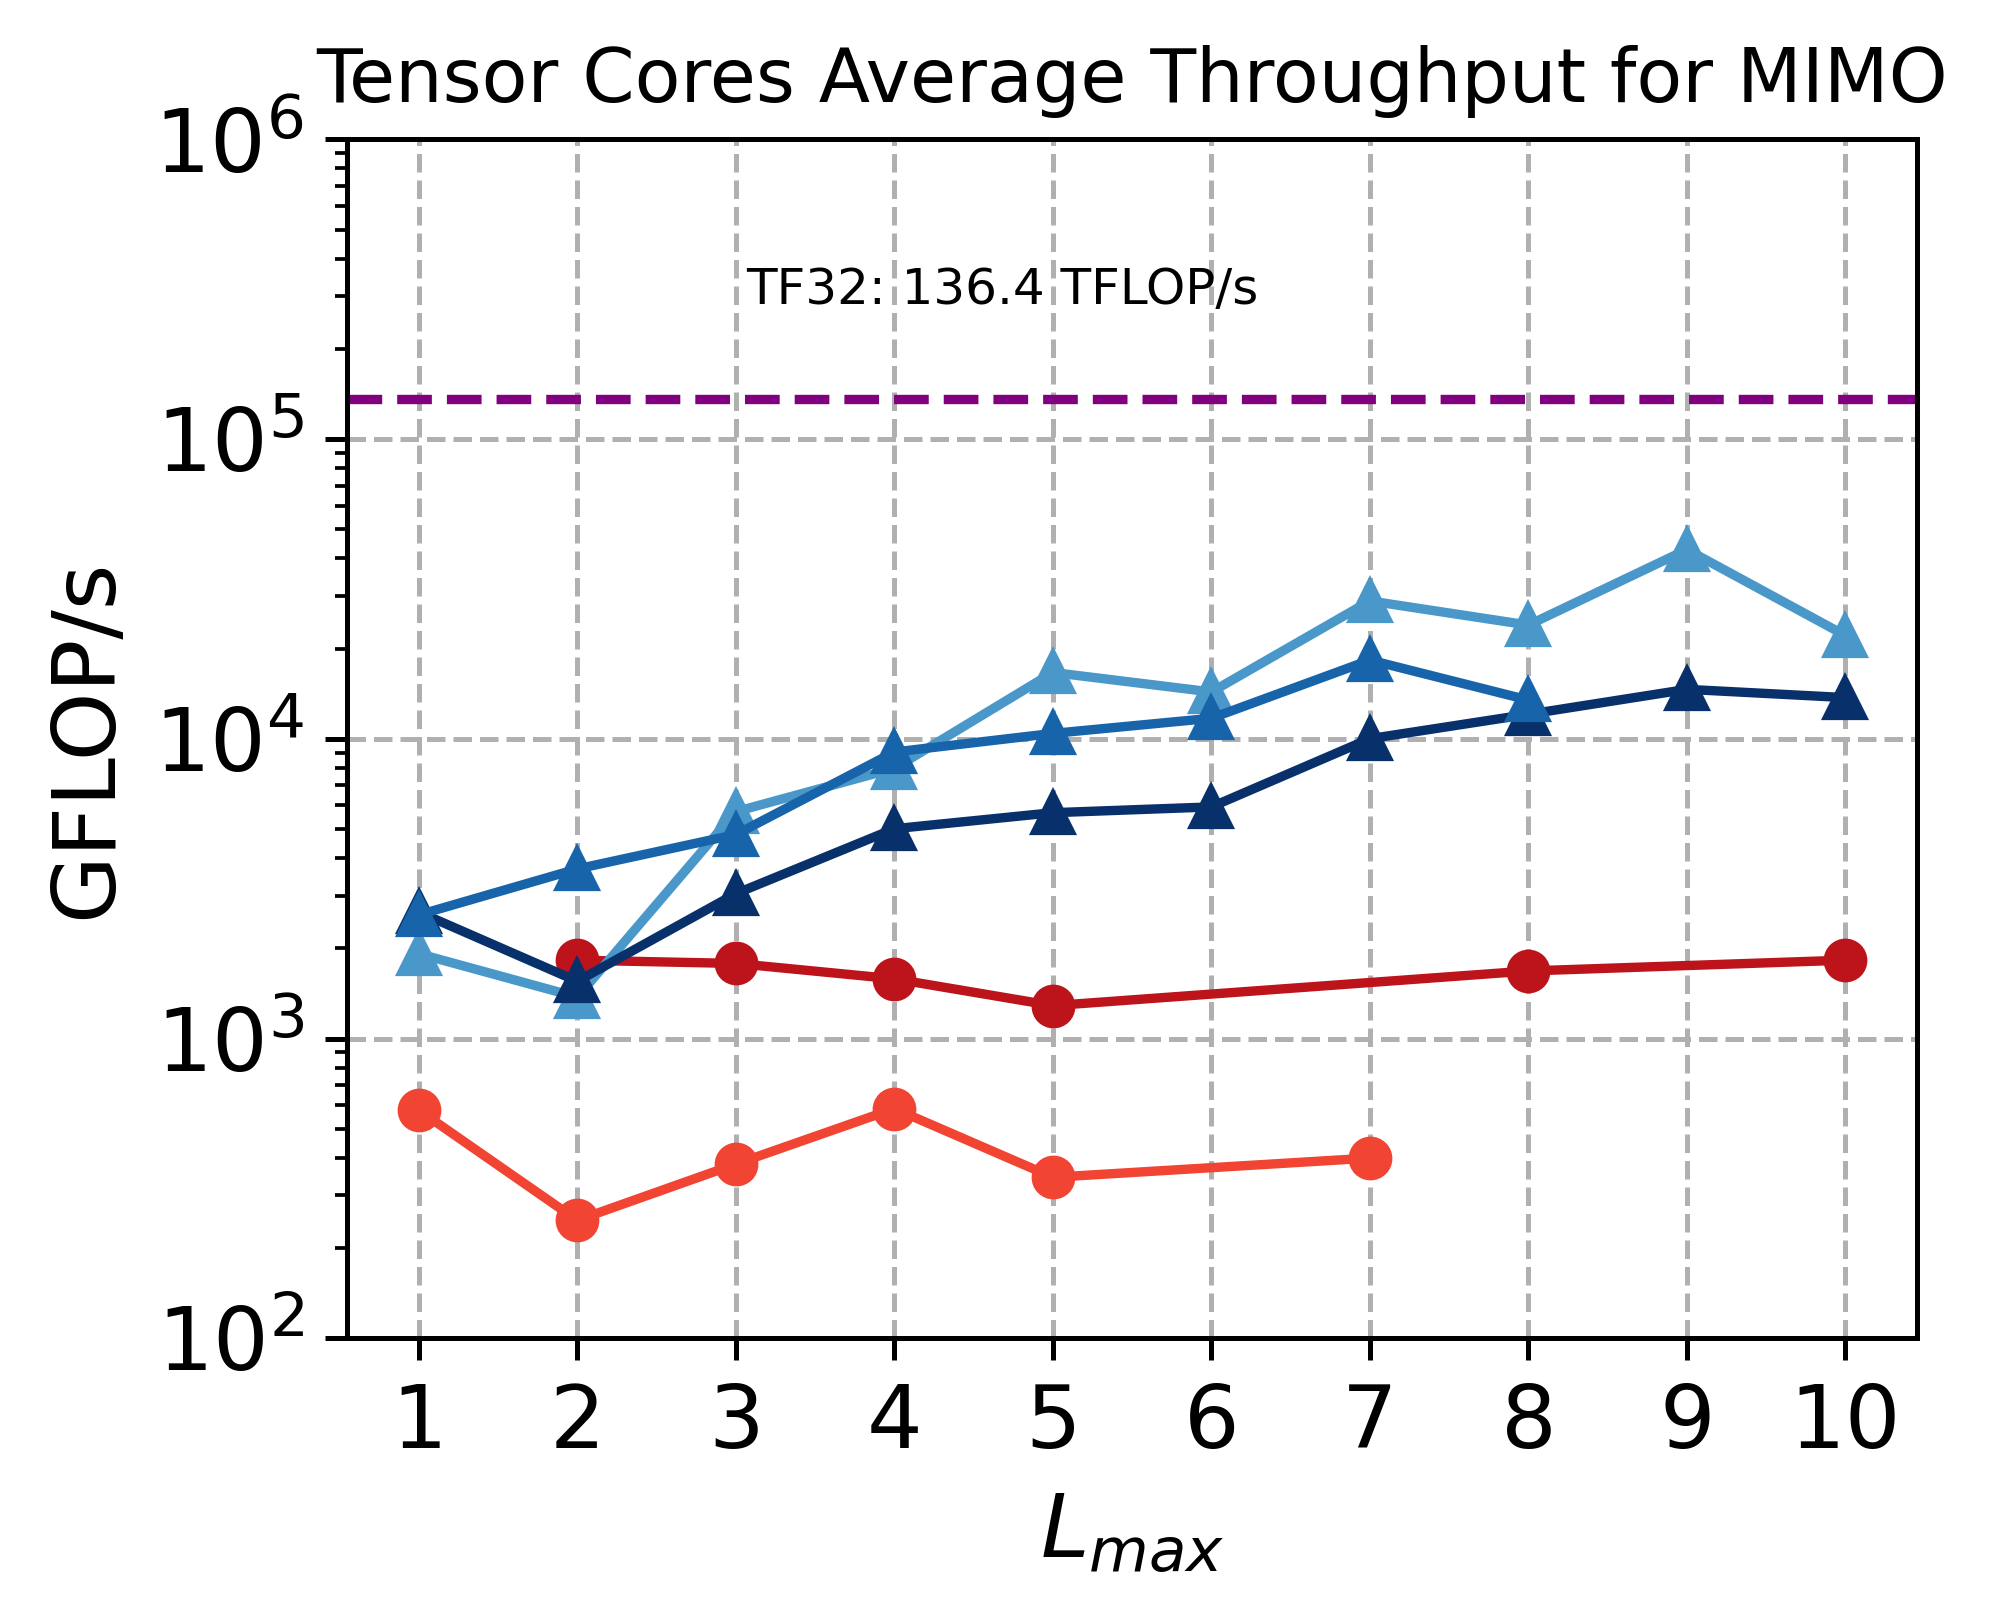

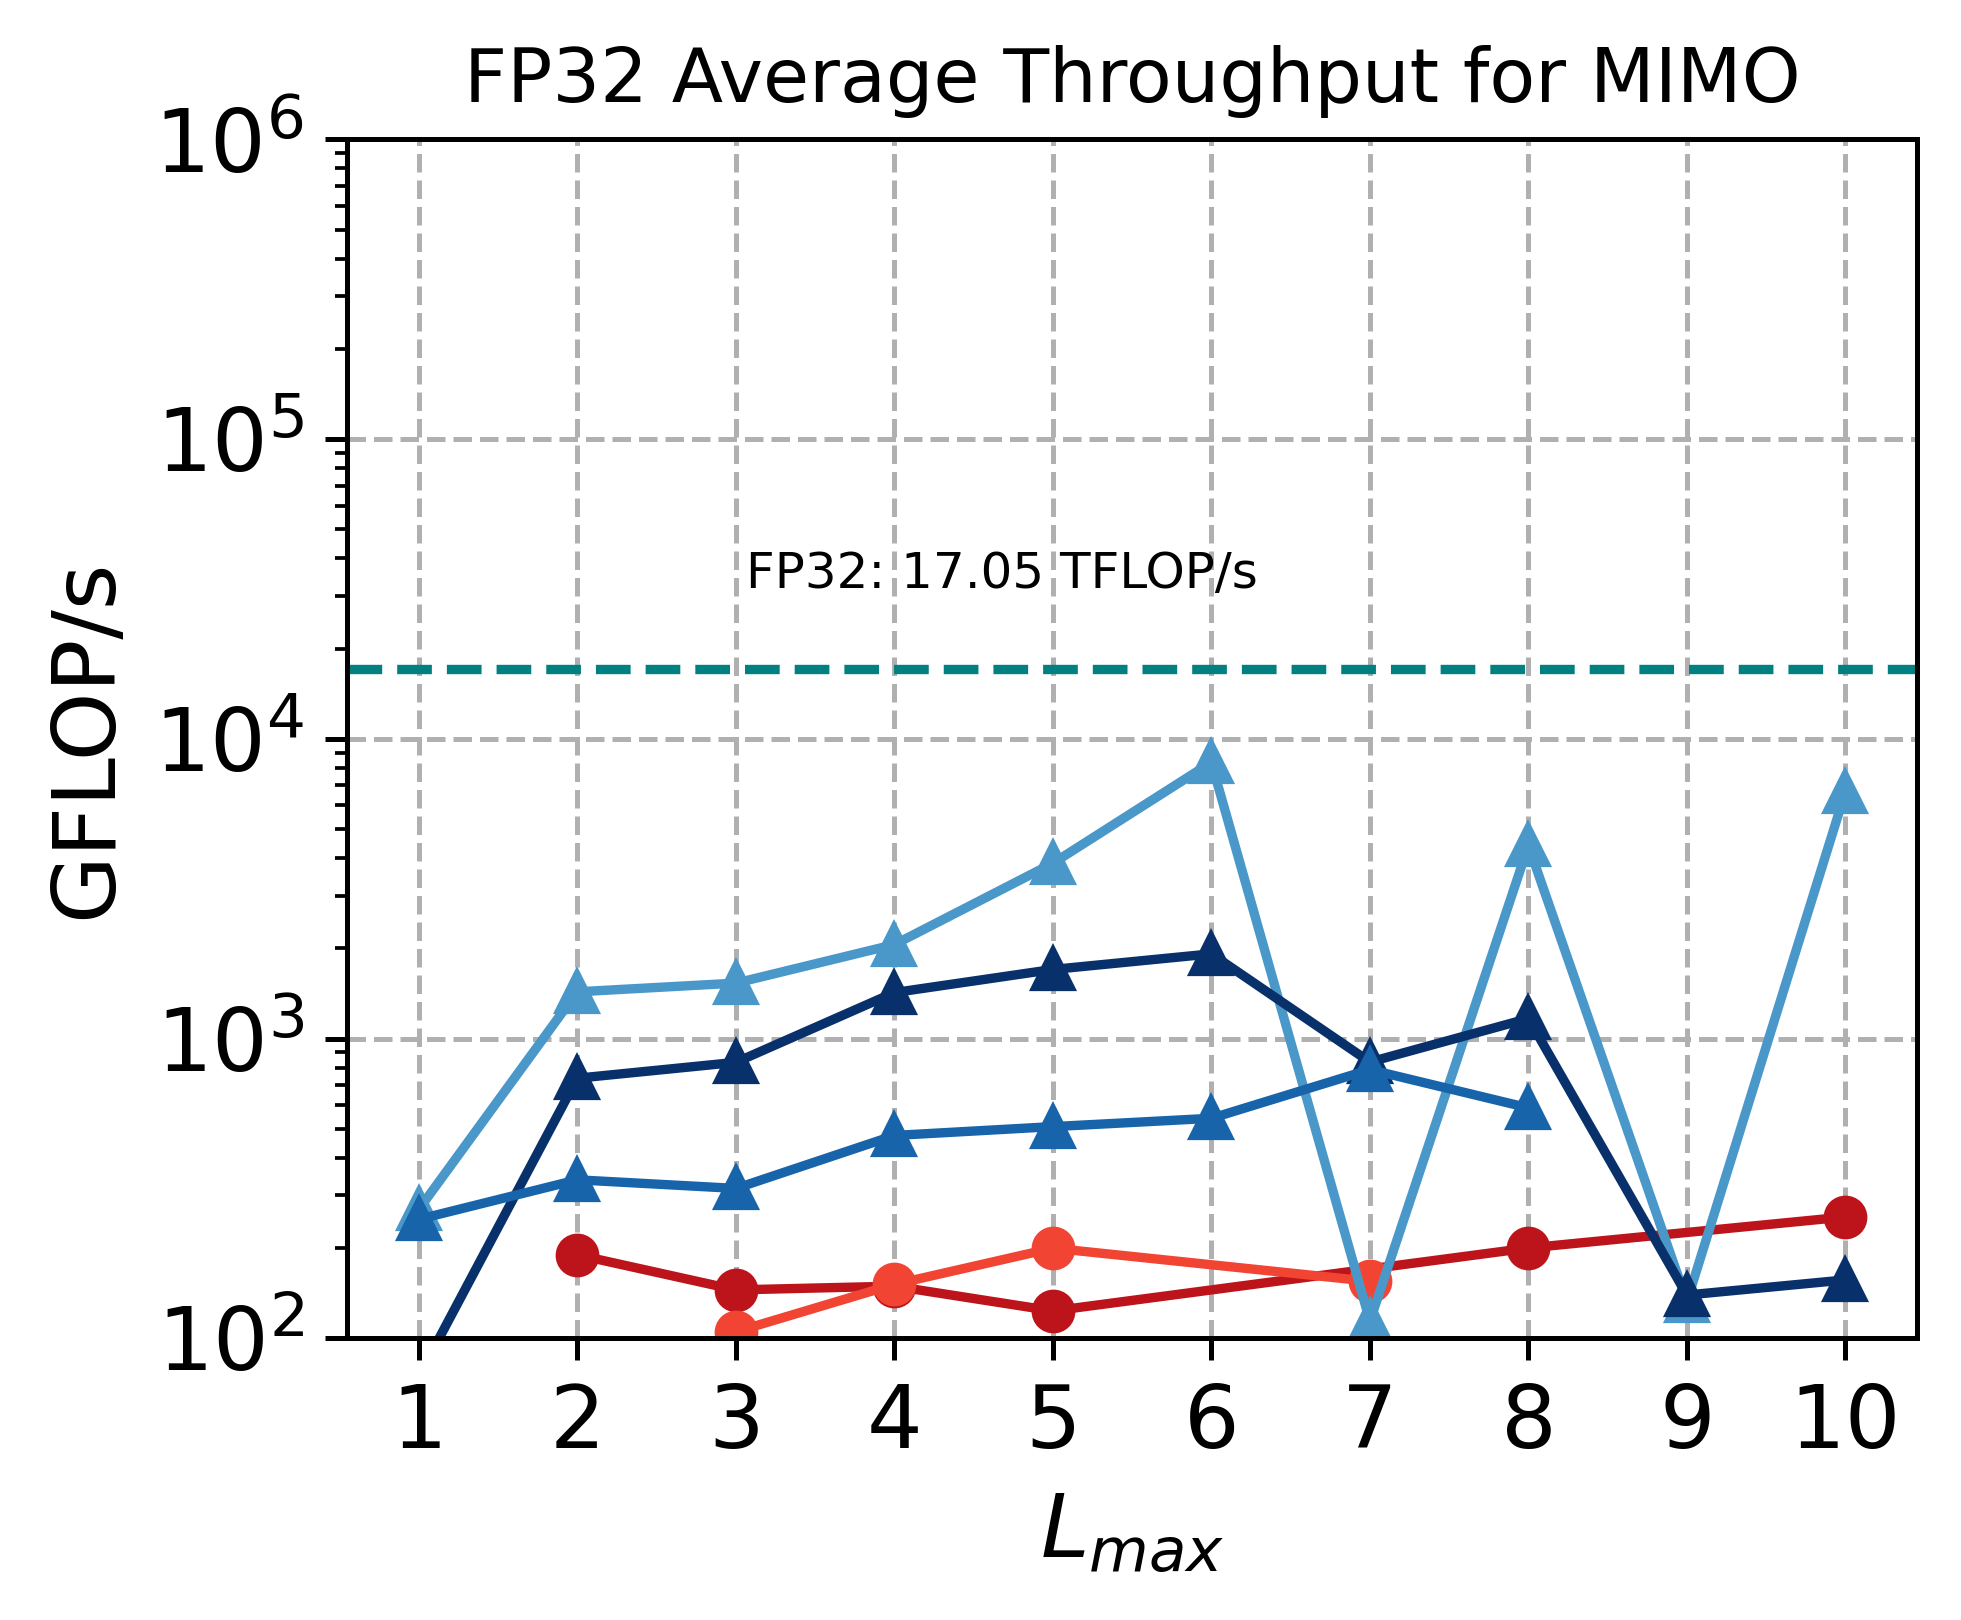

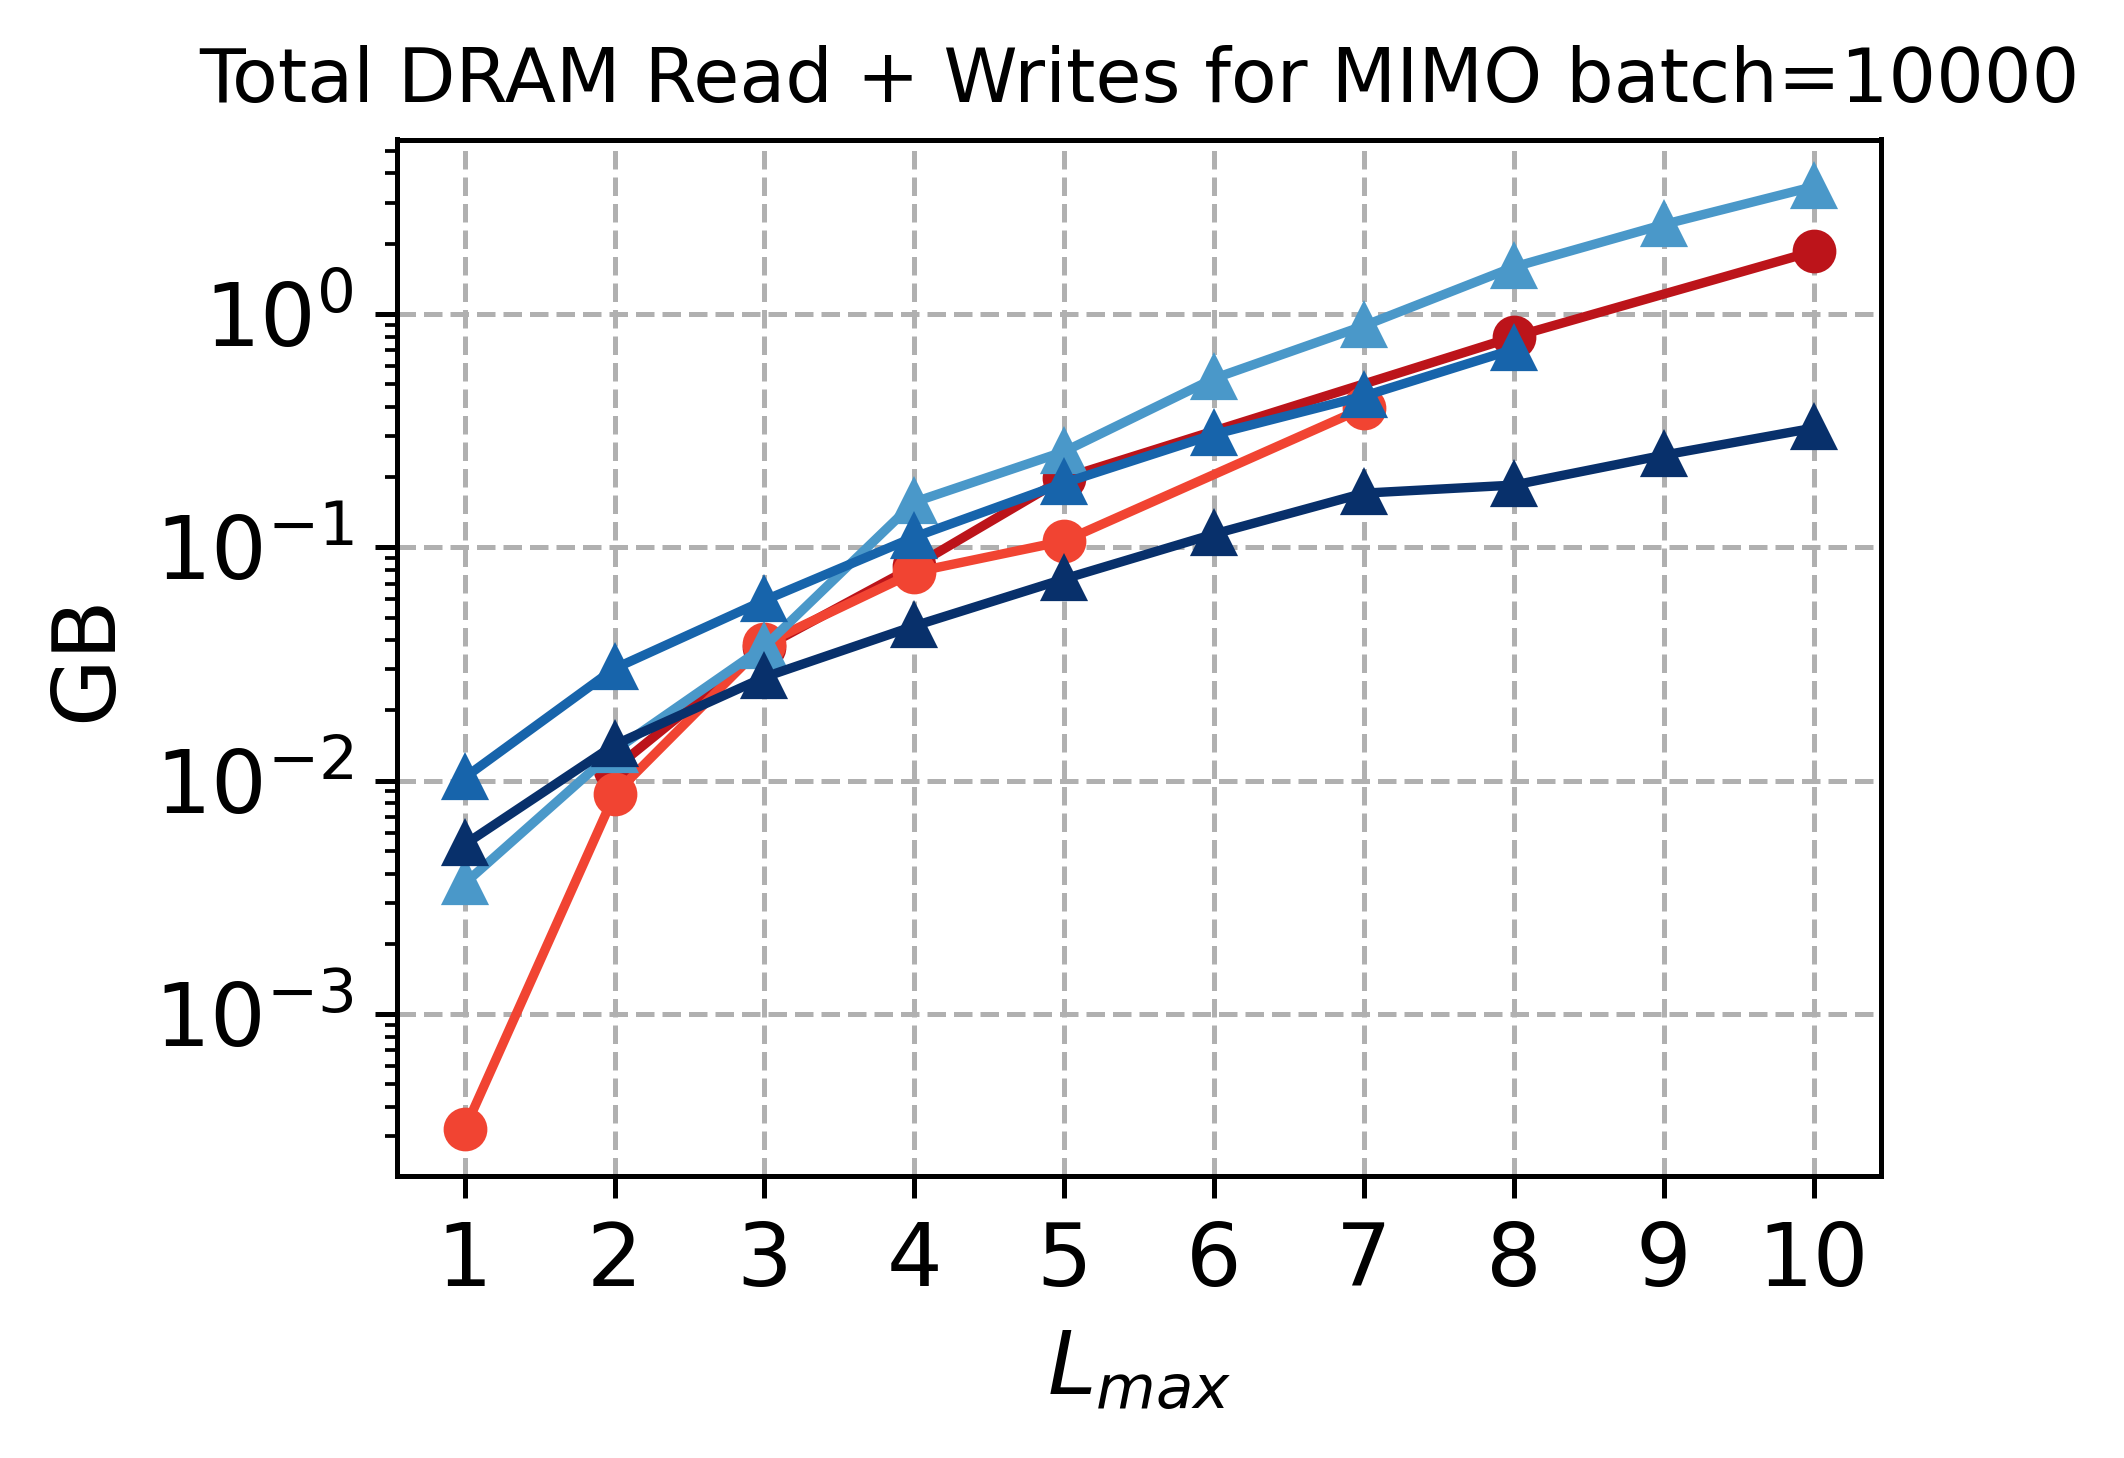

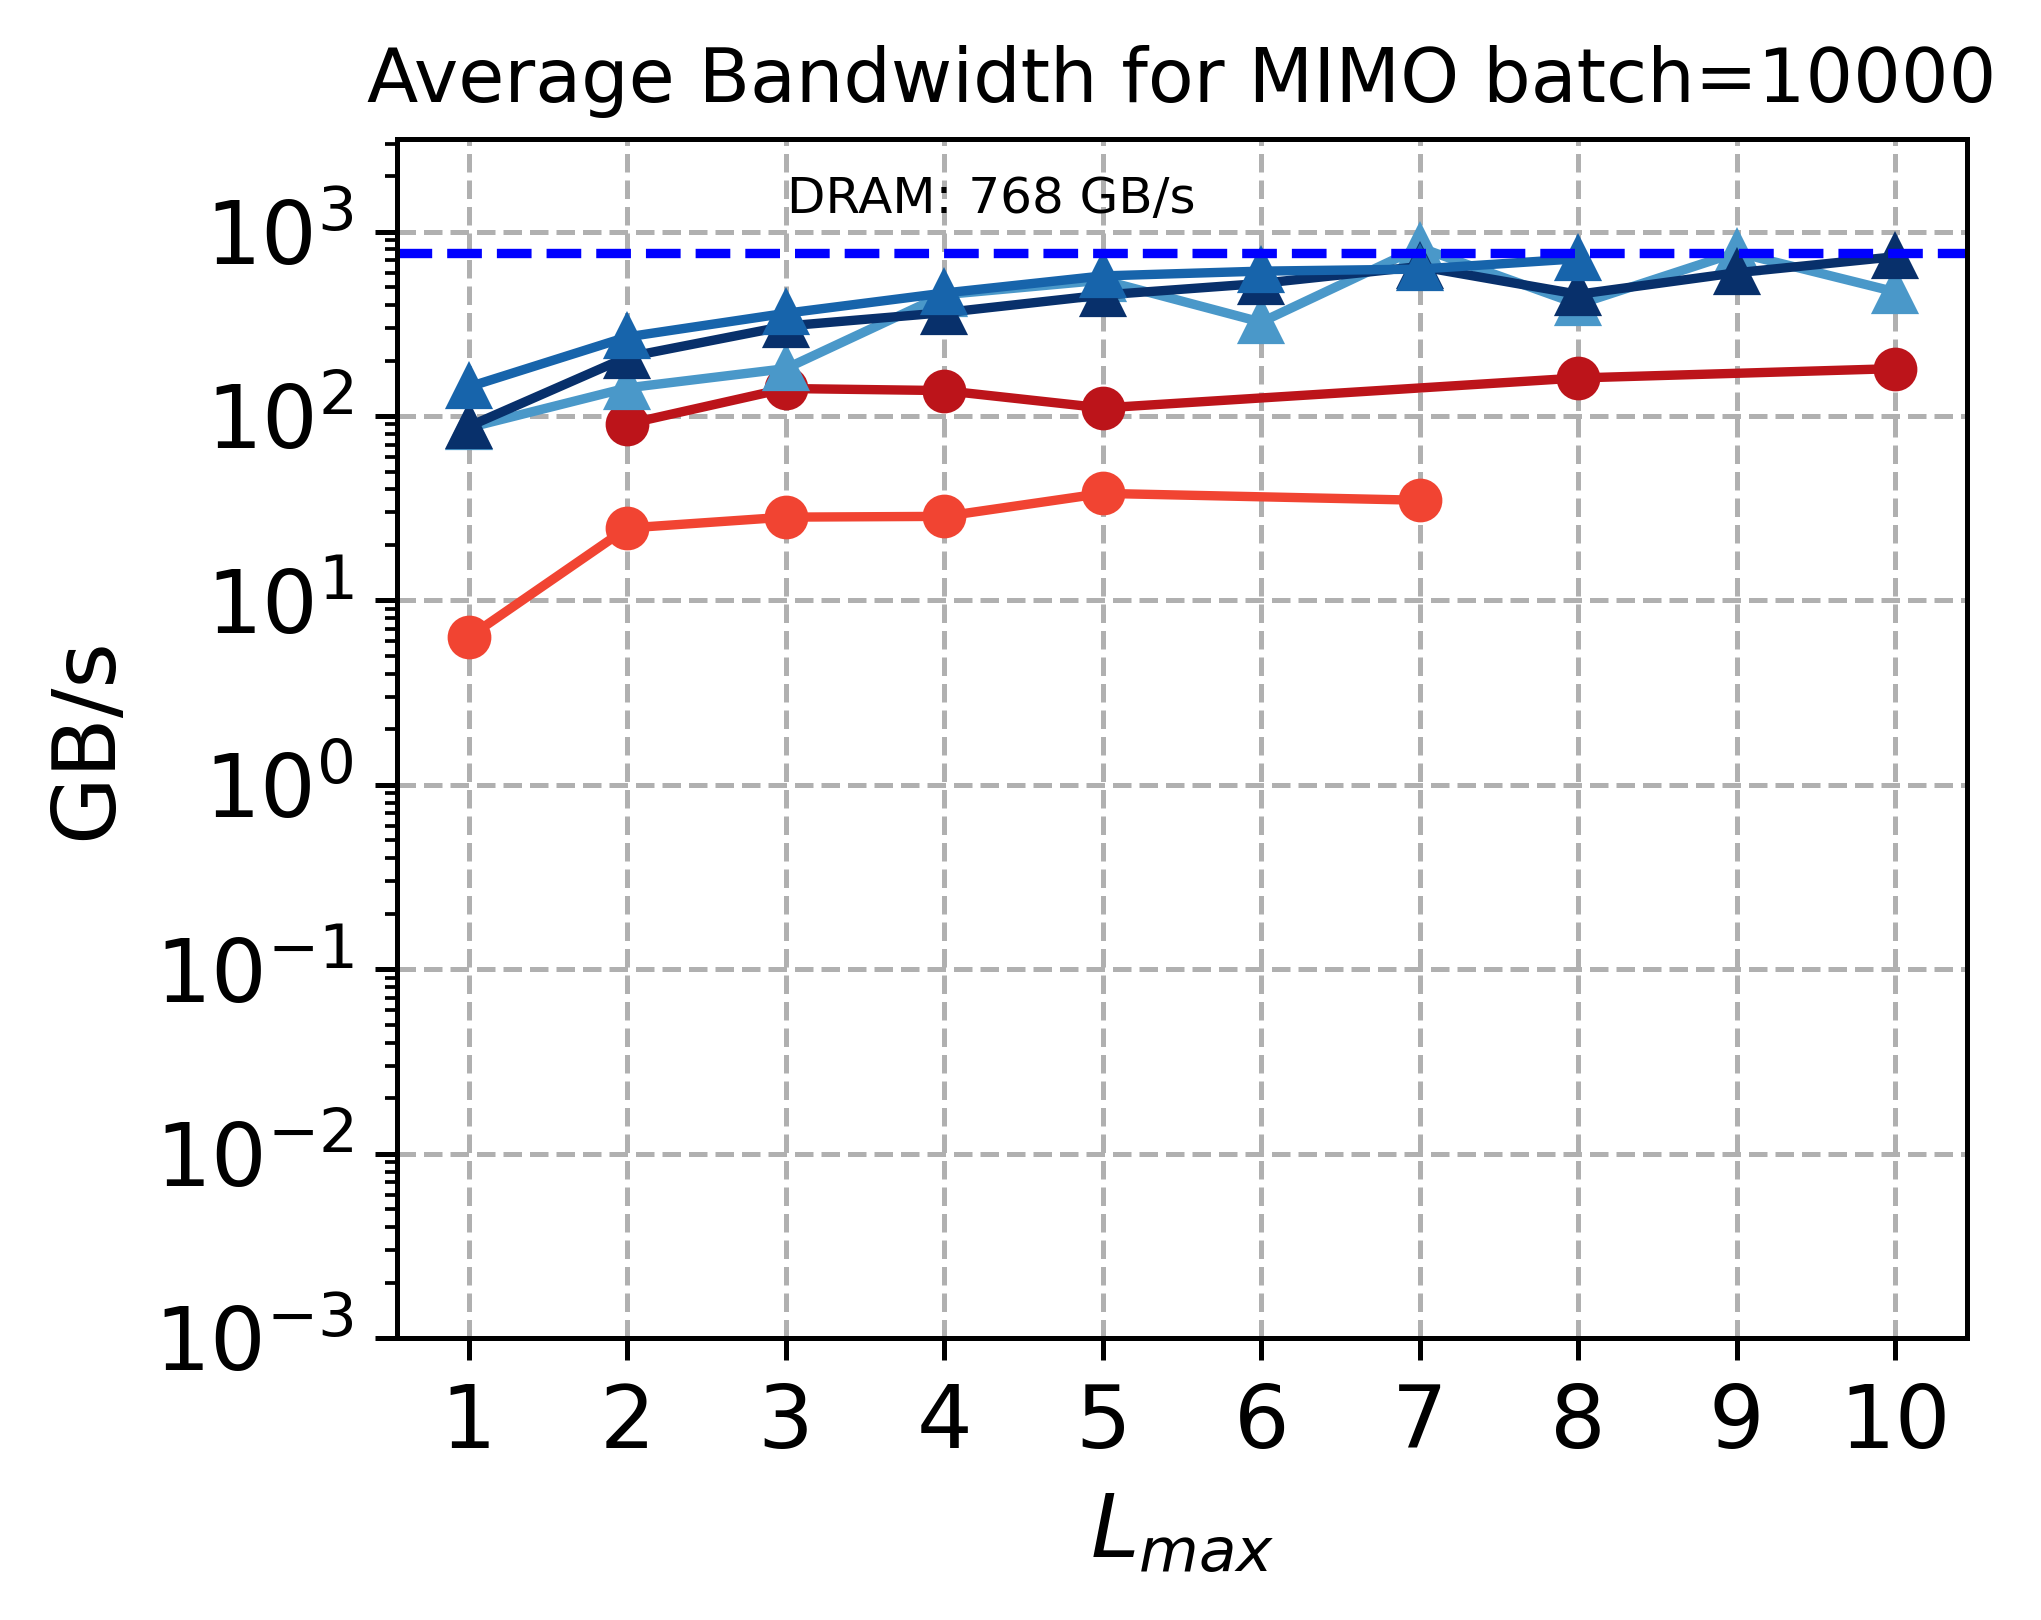

In [16]:
plot_iclr_sweep("MIMO", 10000)

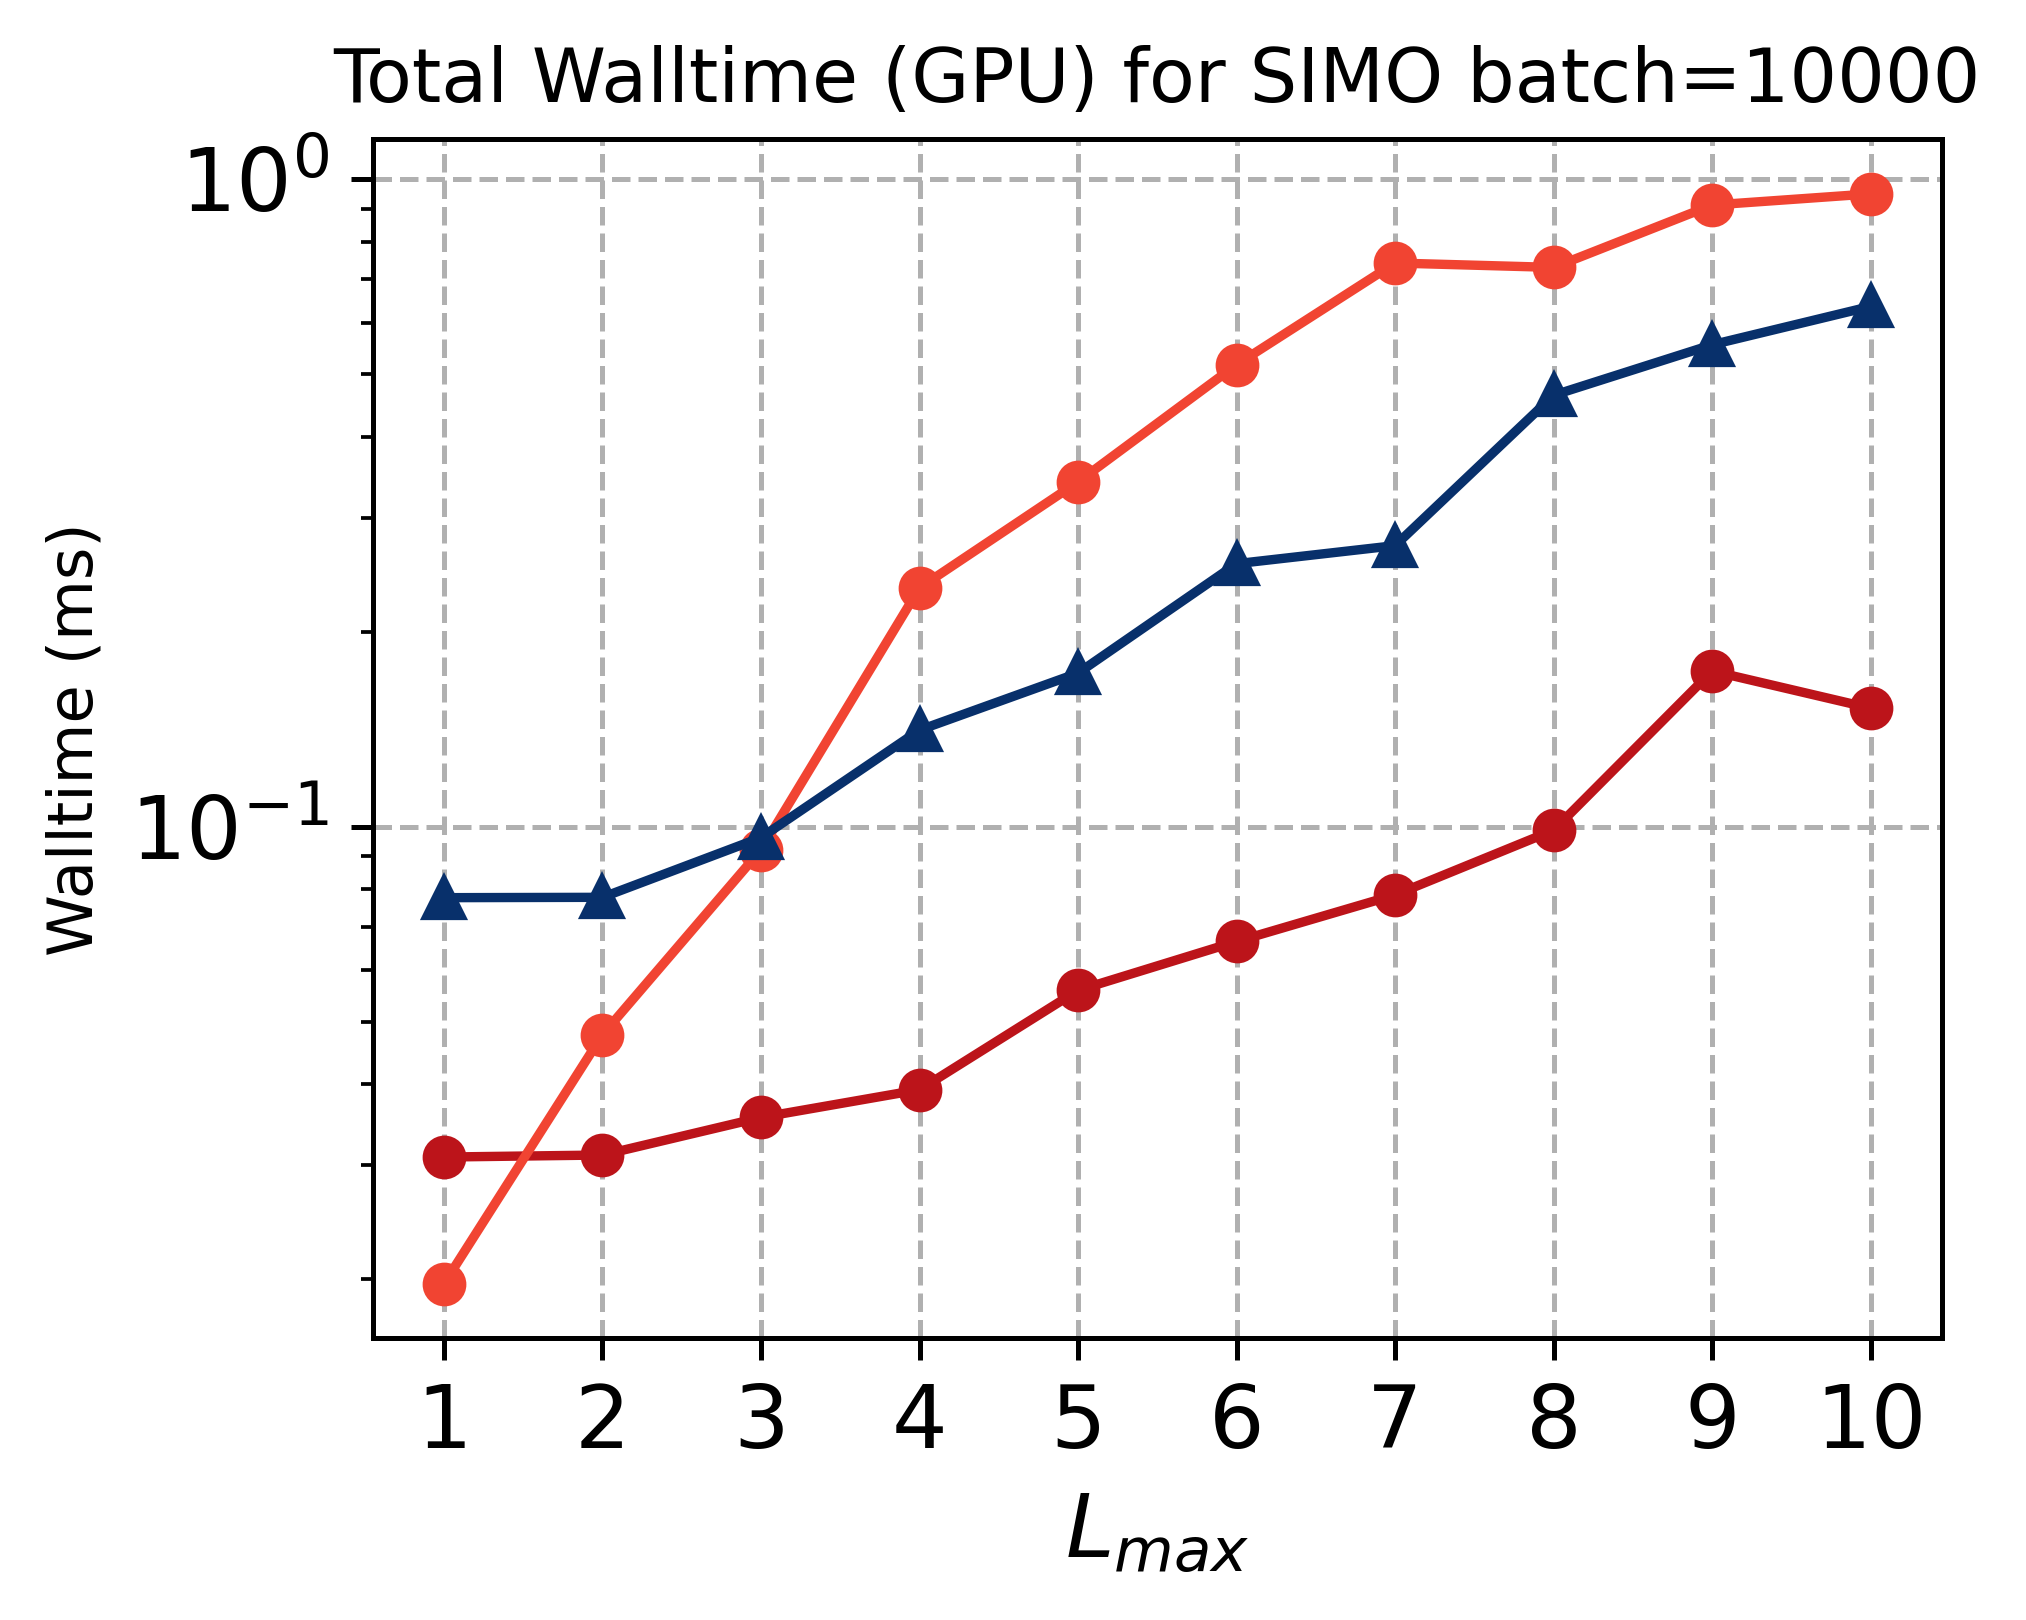

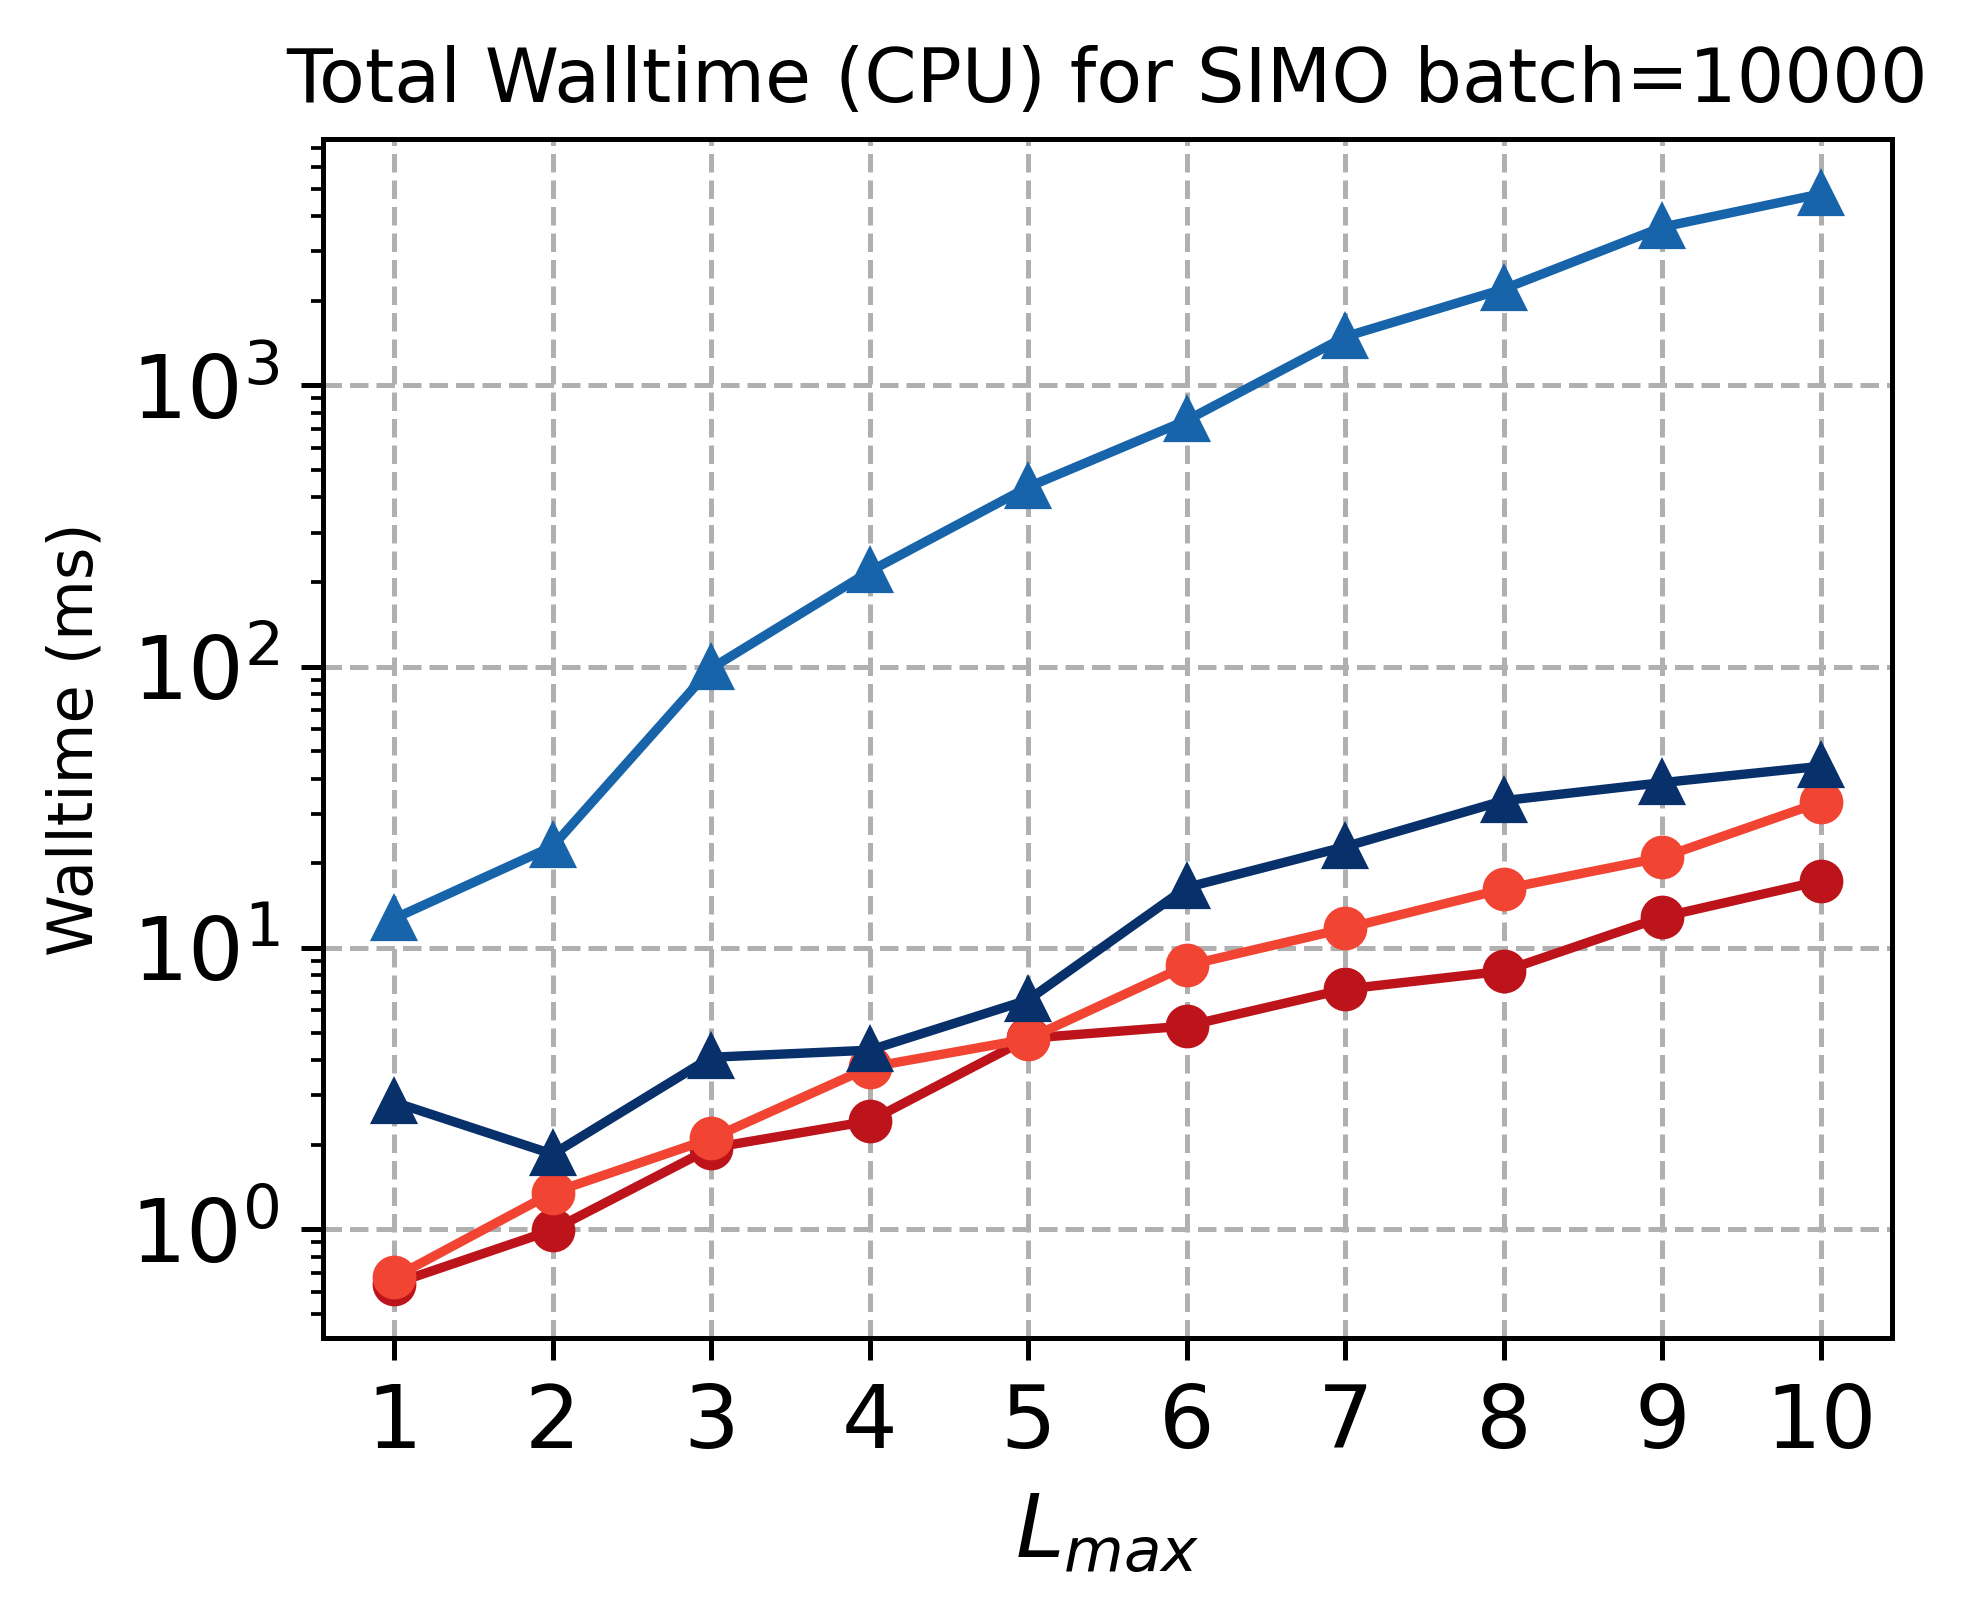

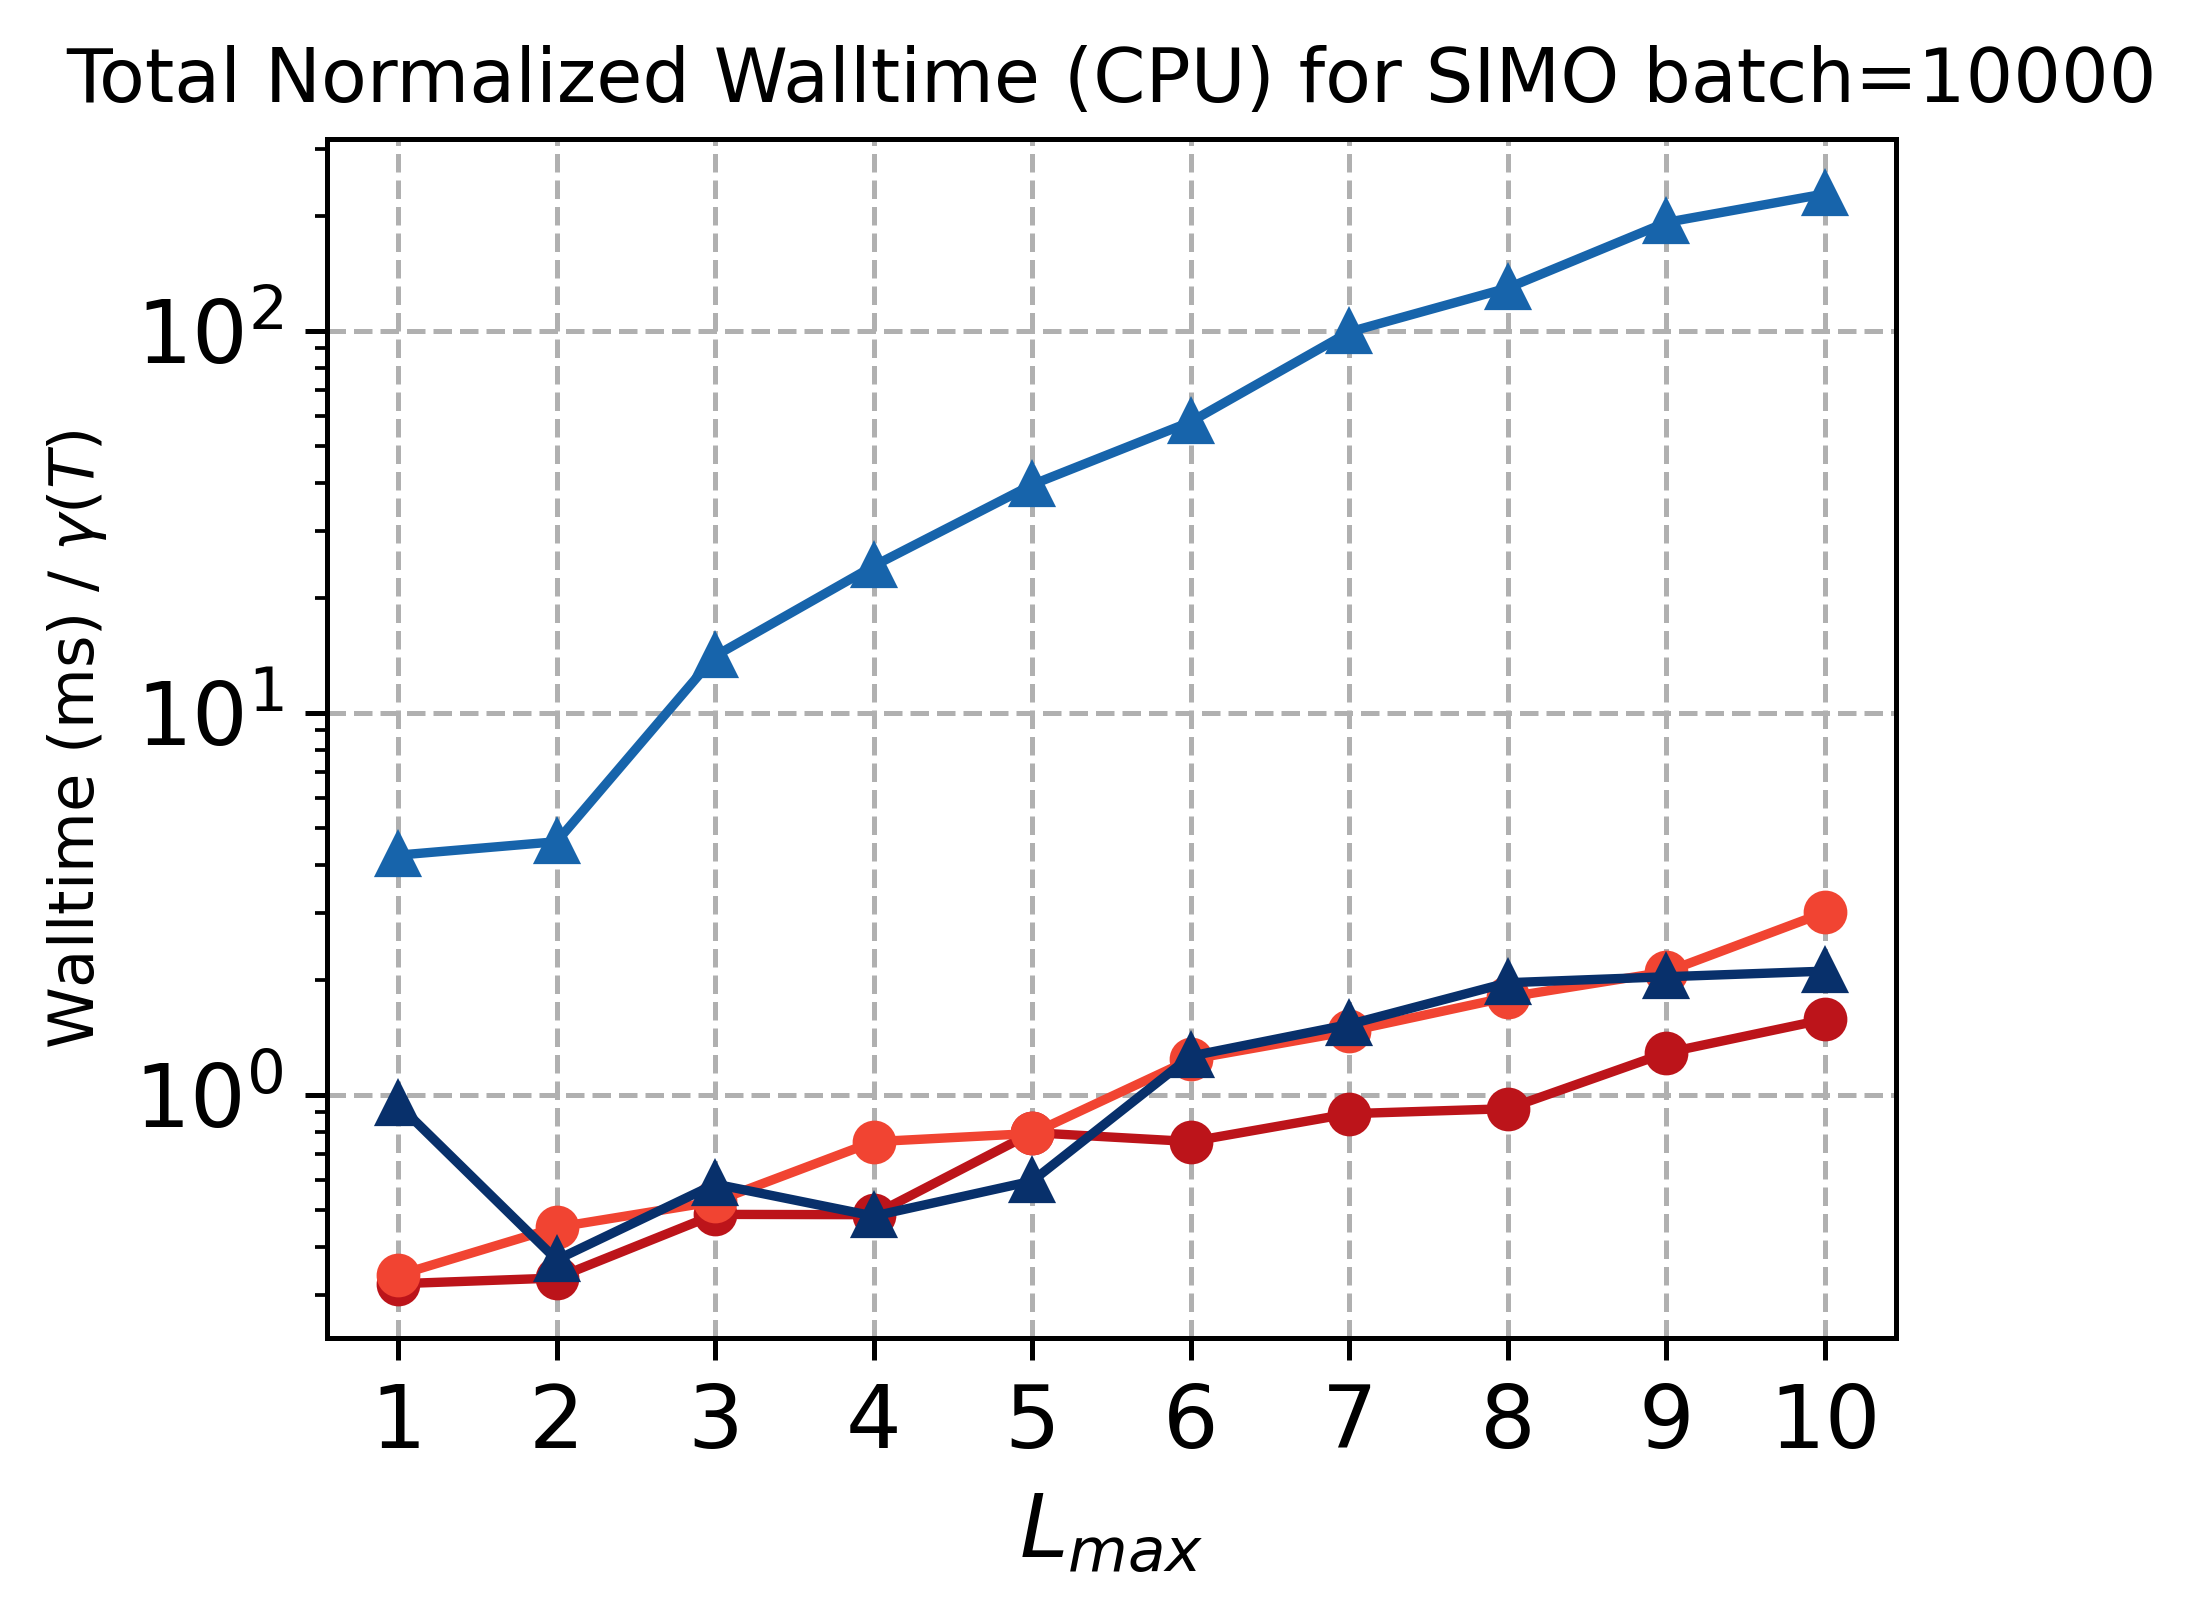

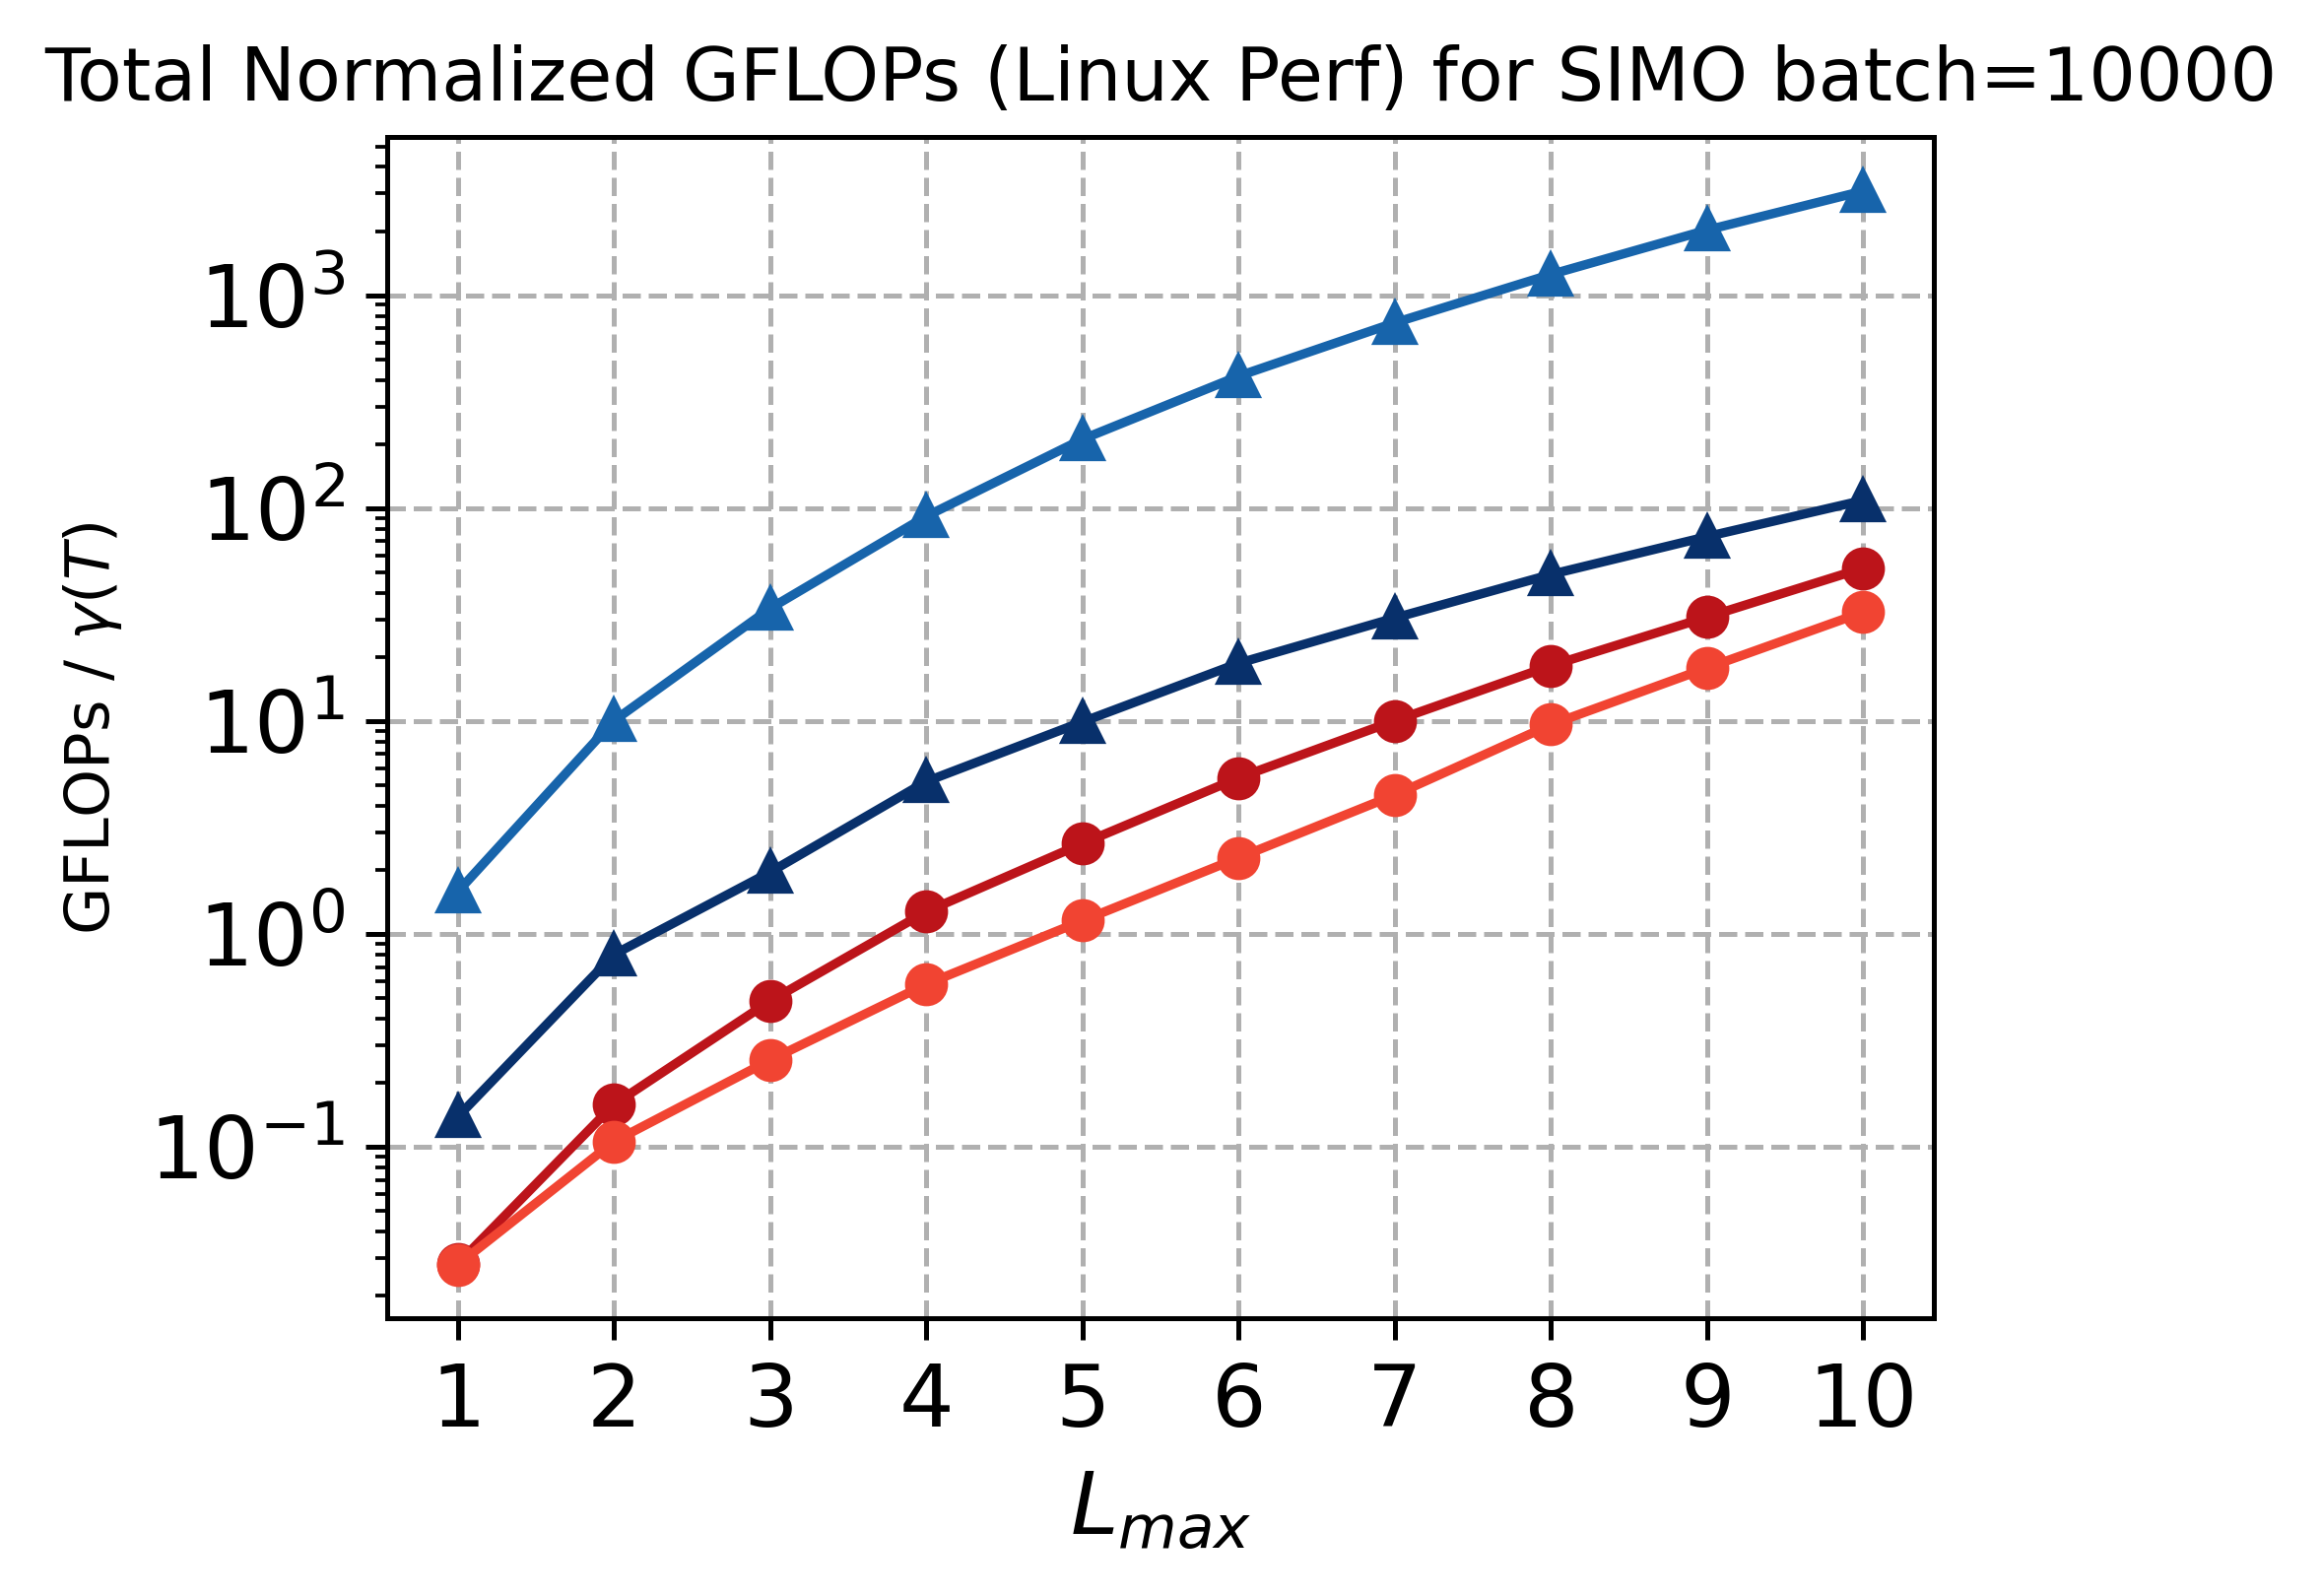

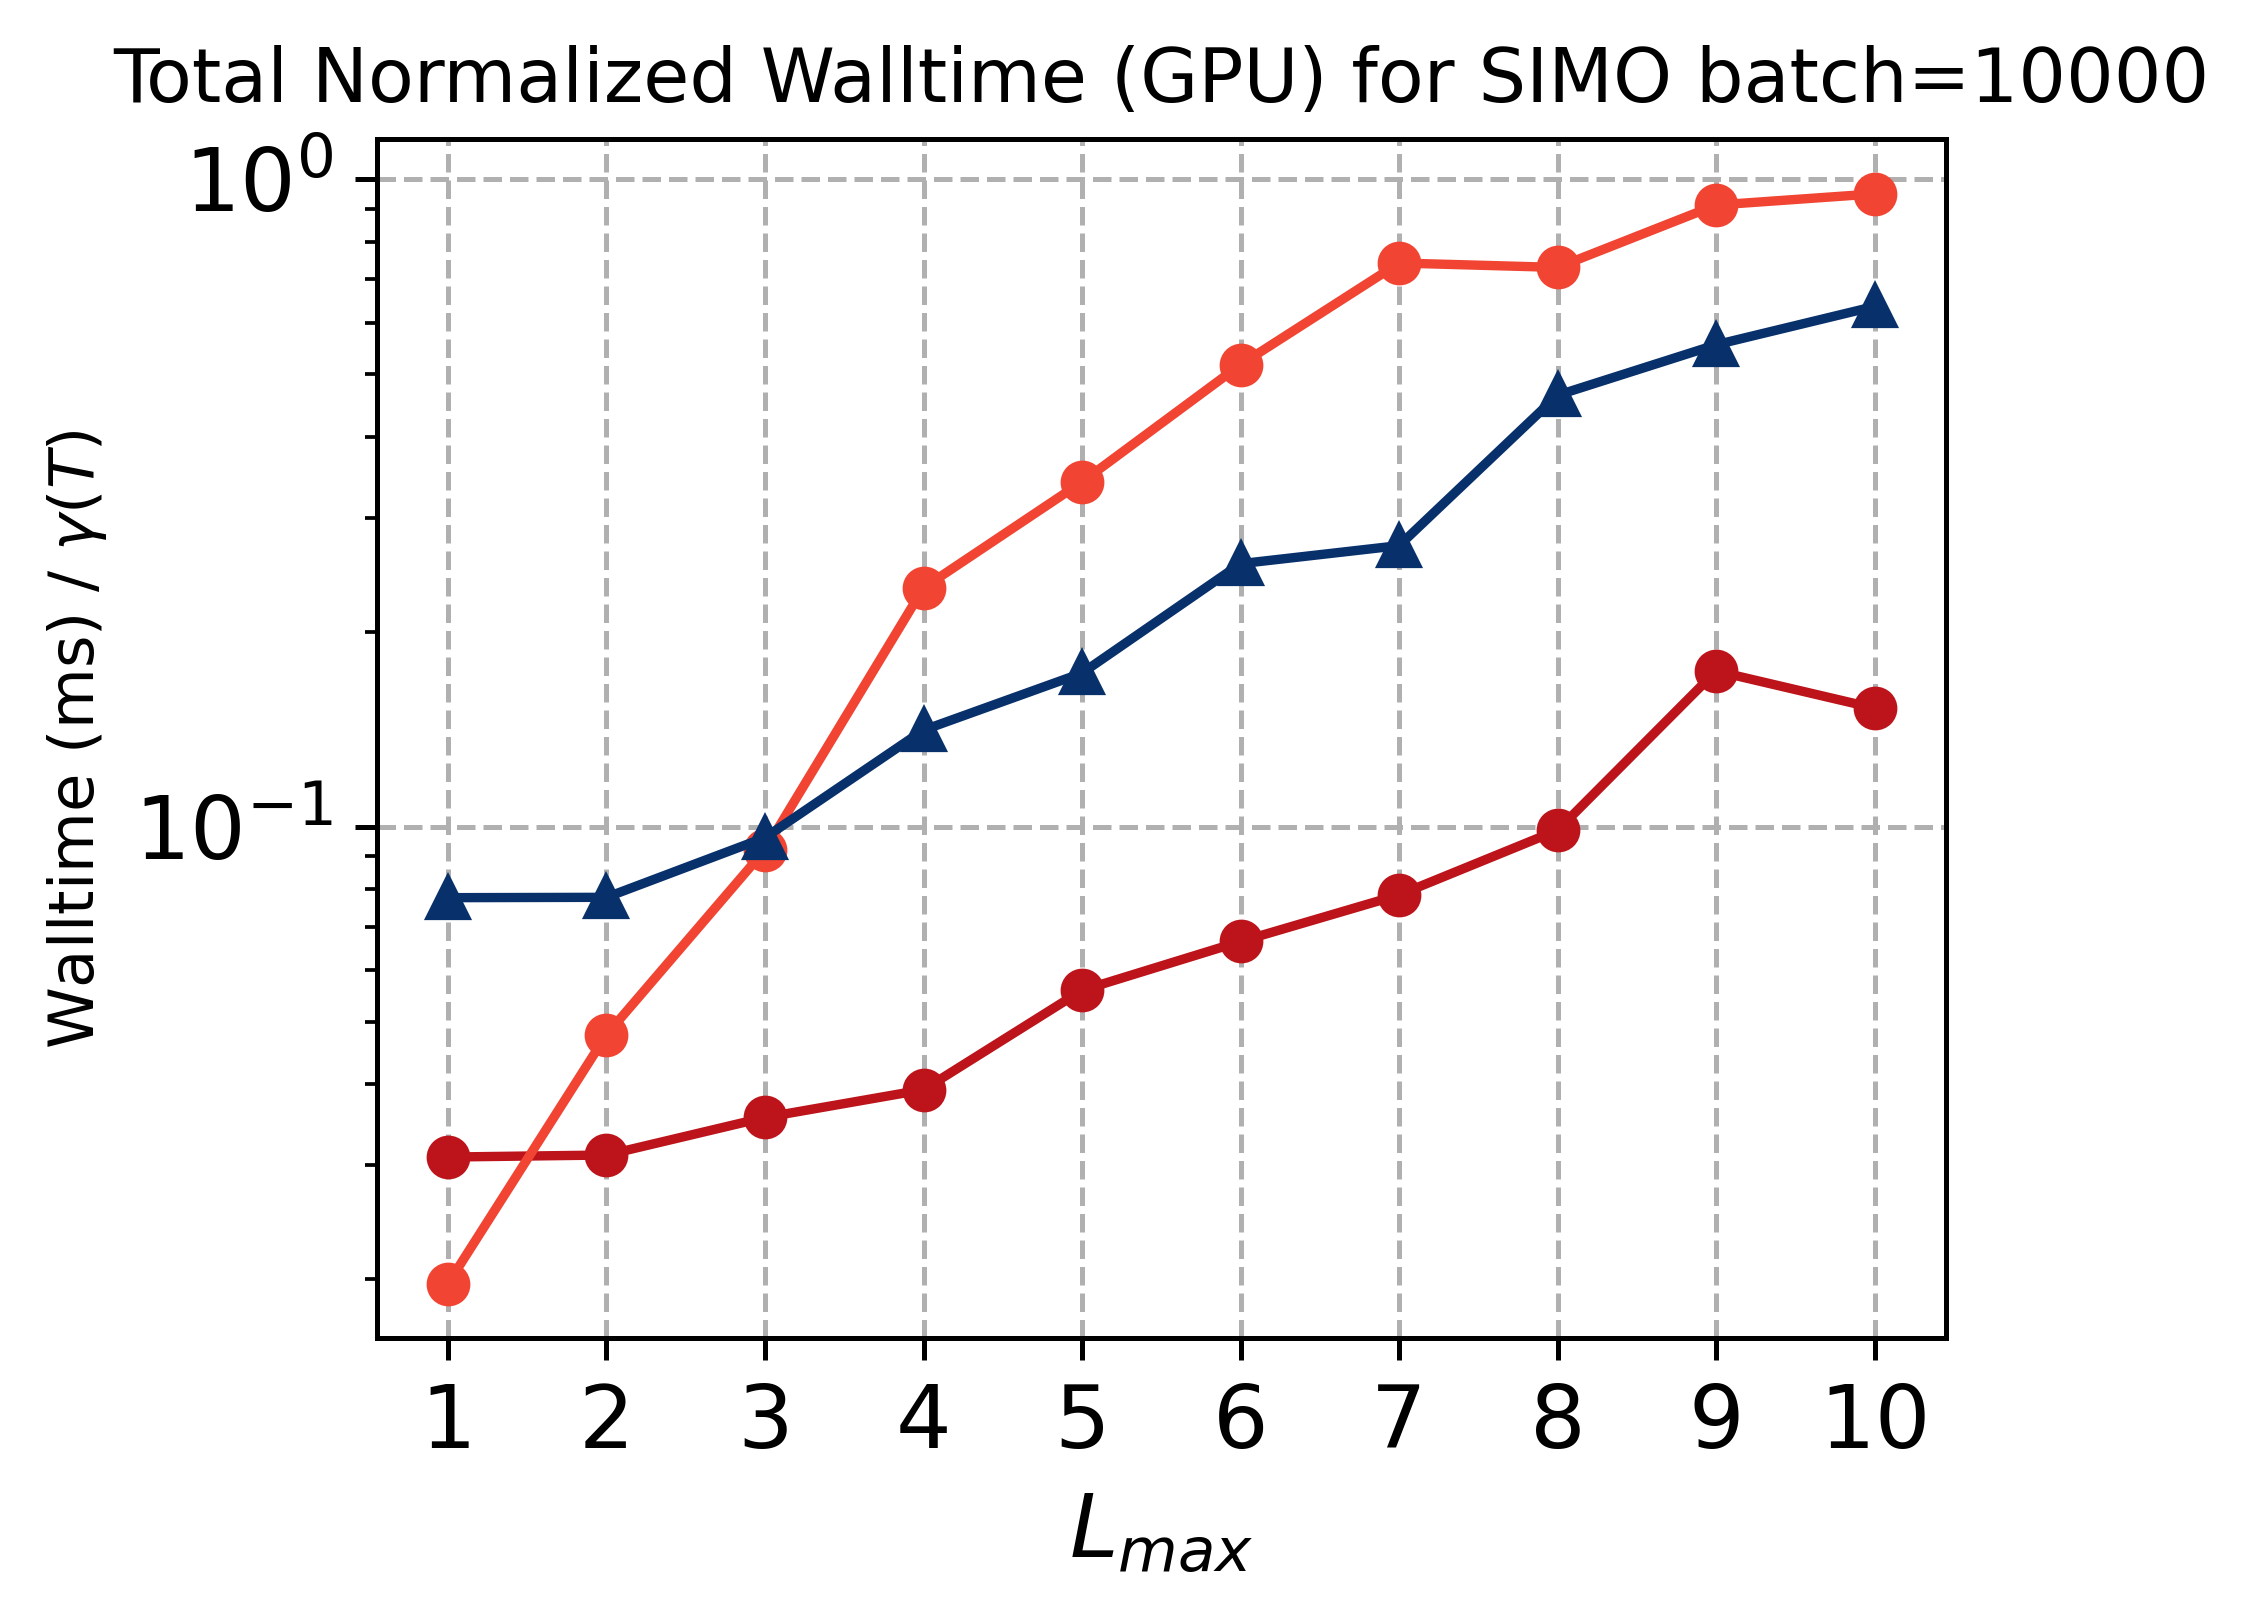

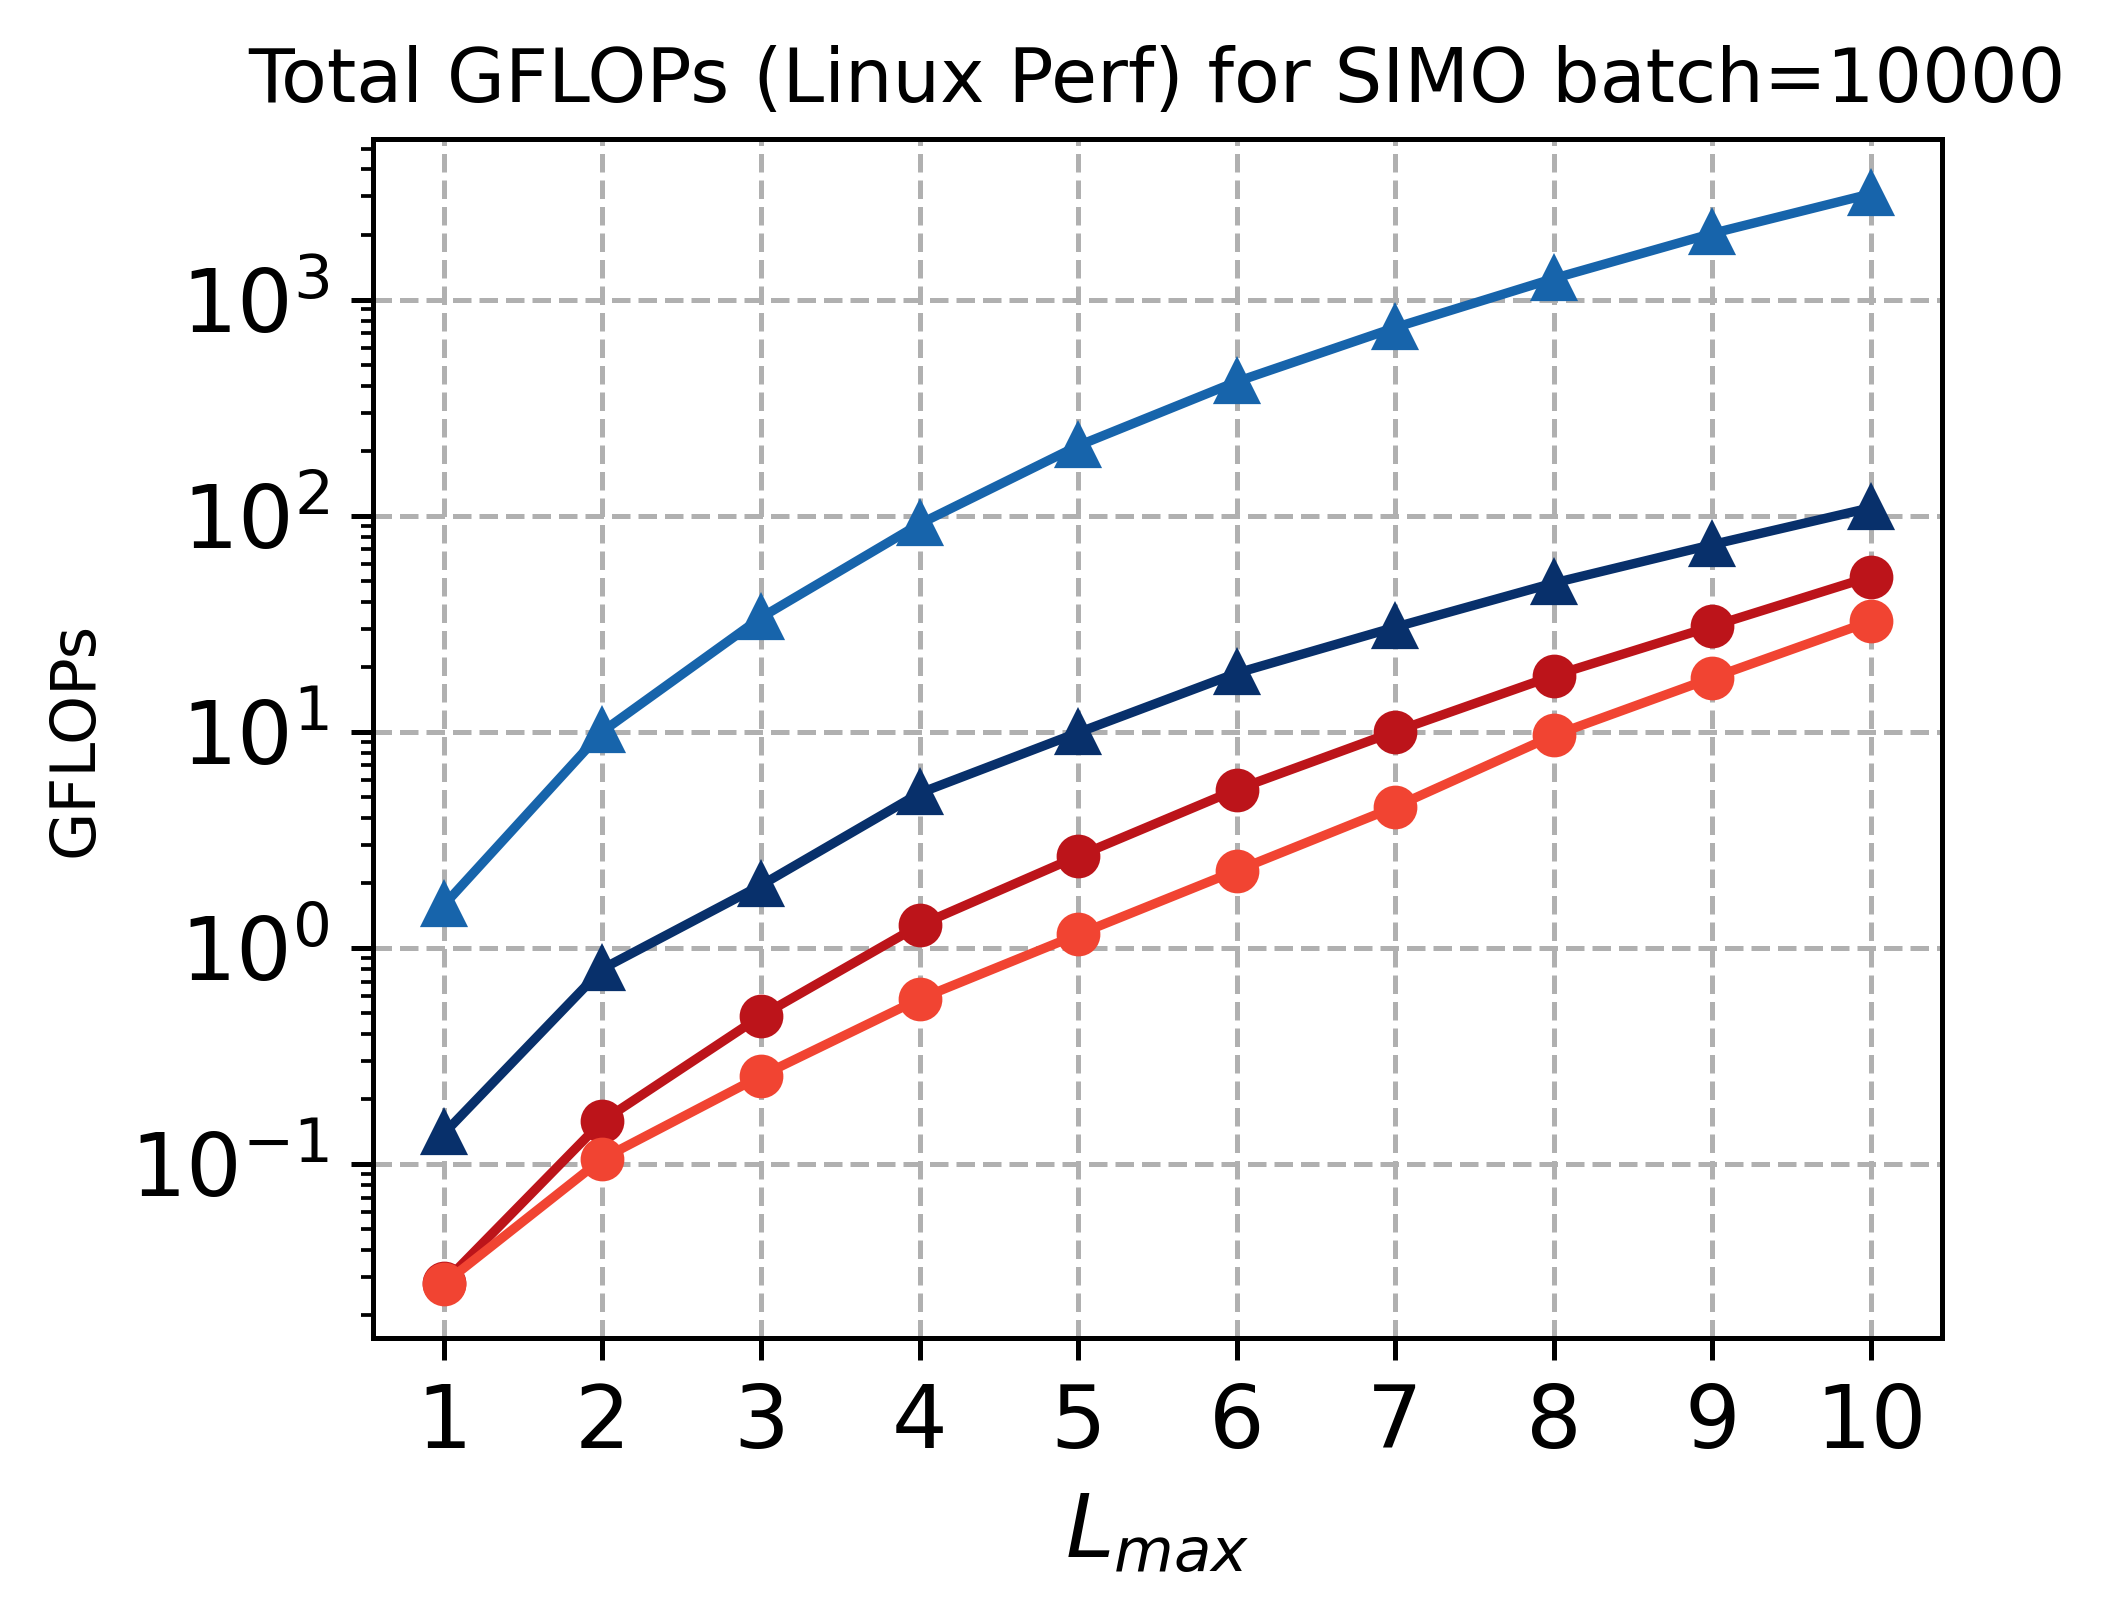

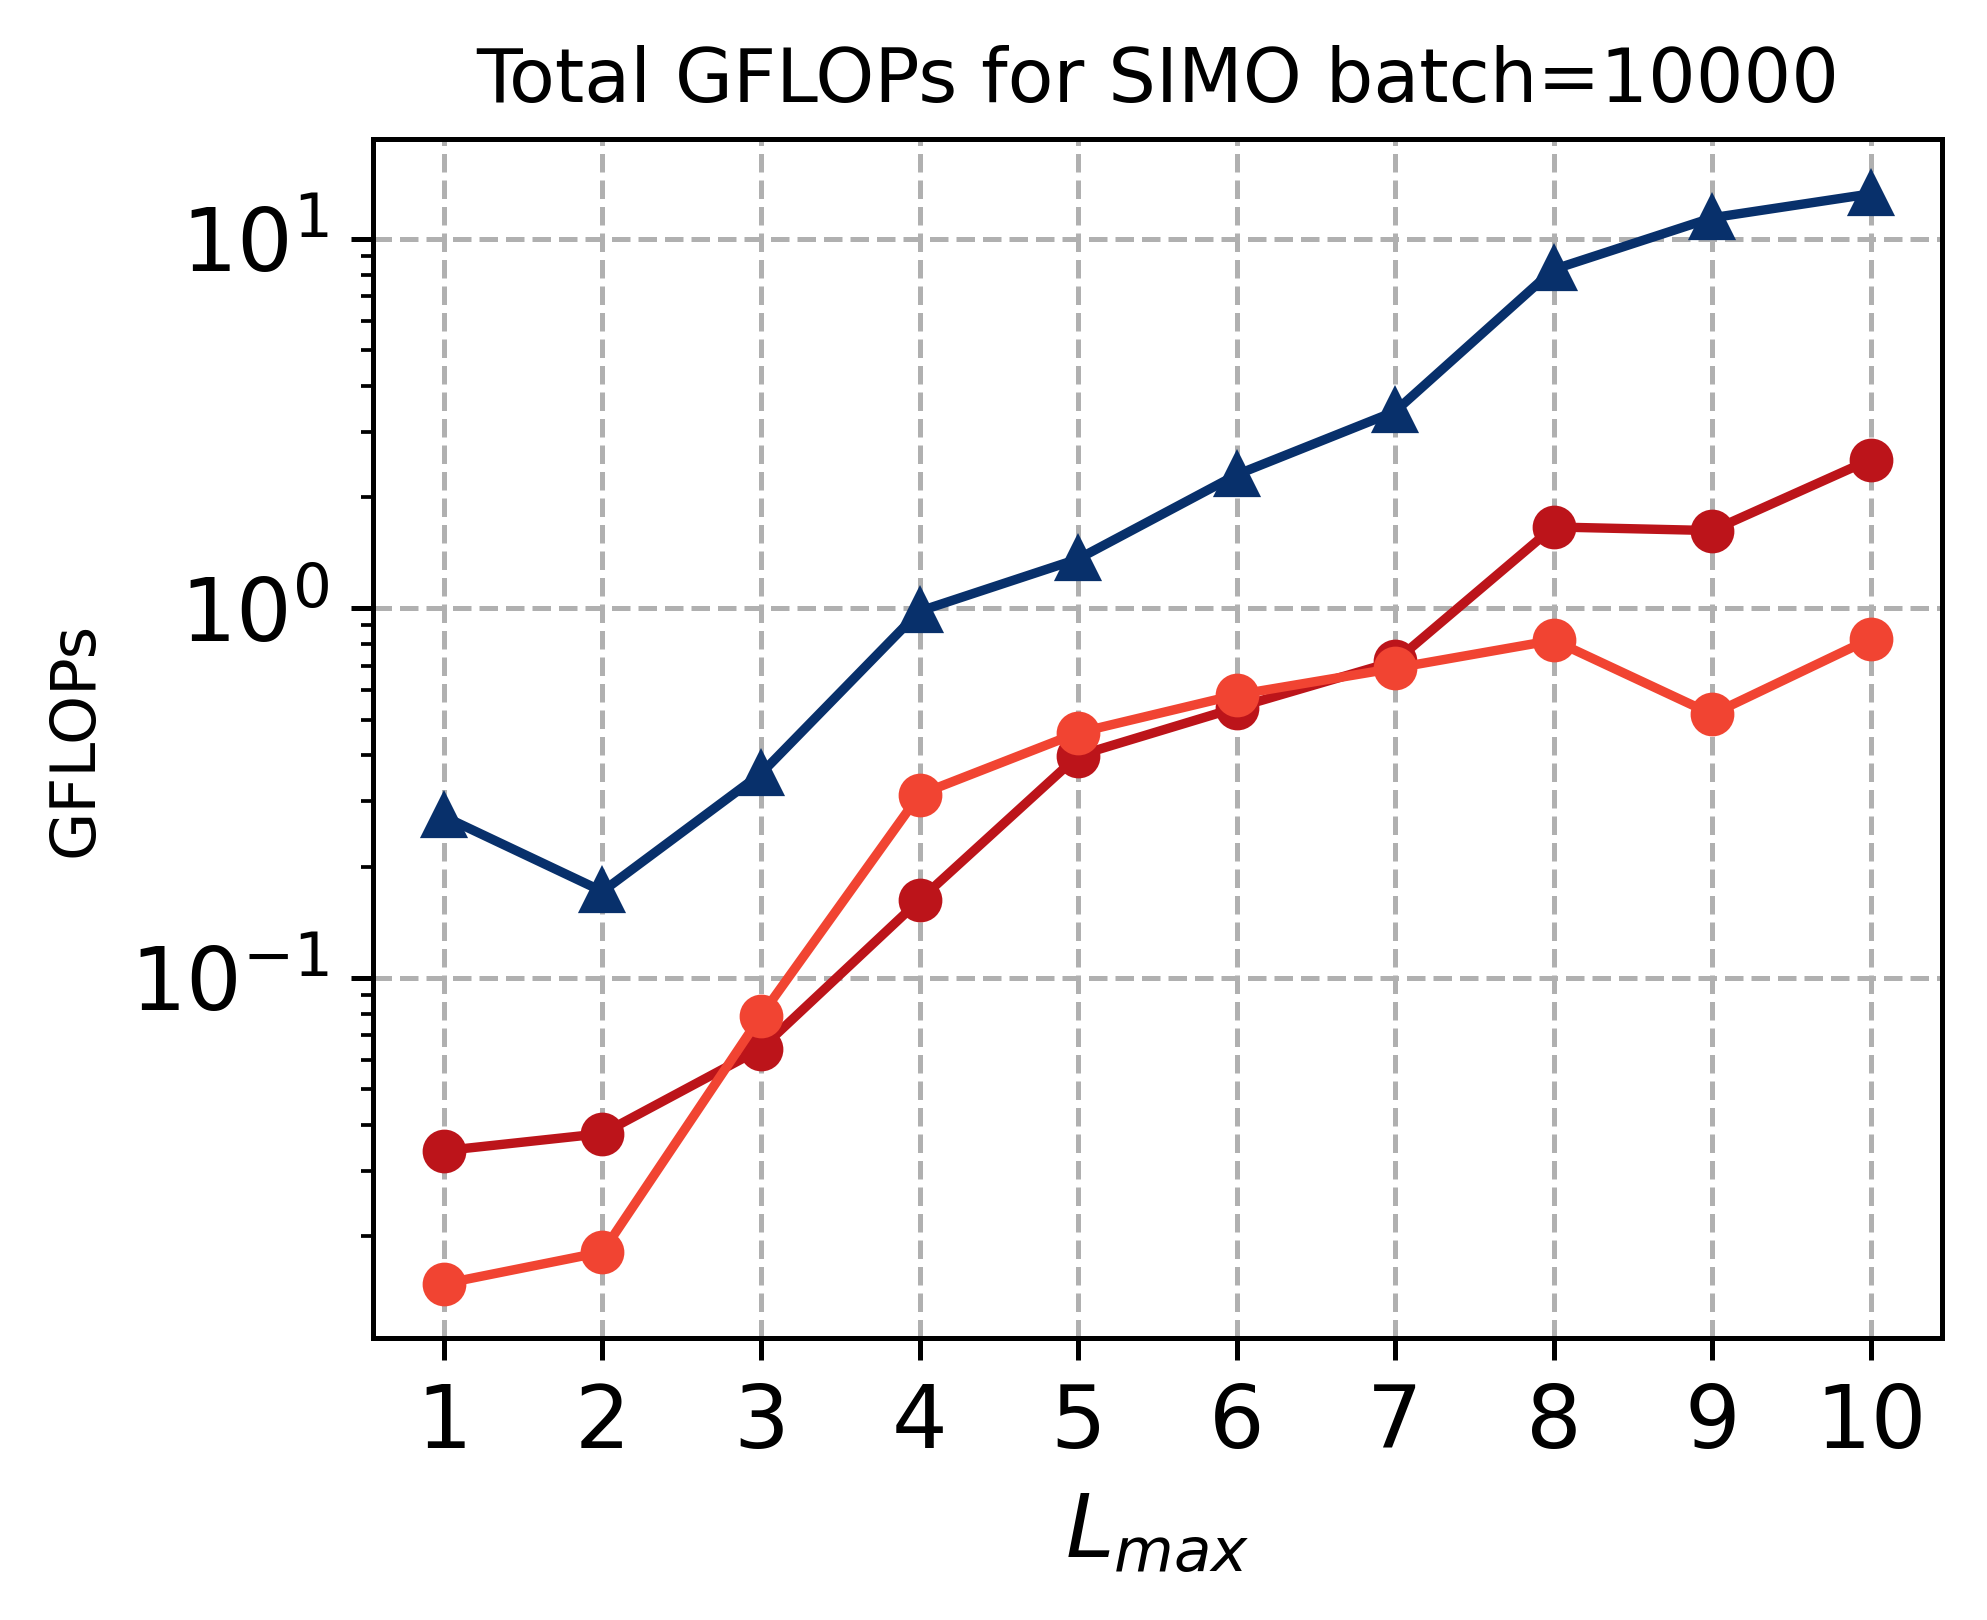

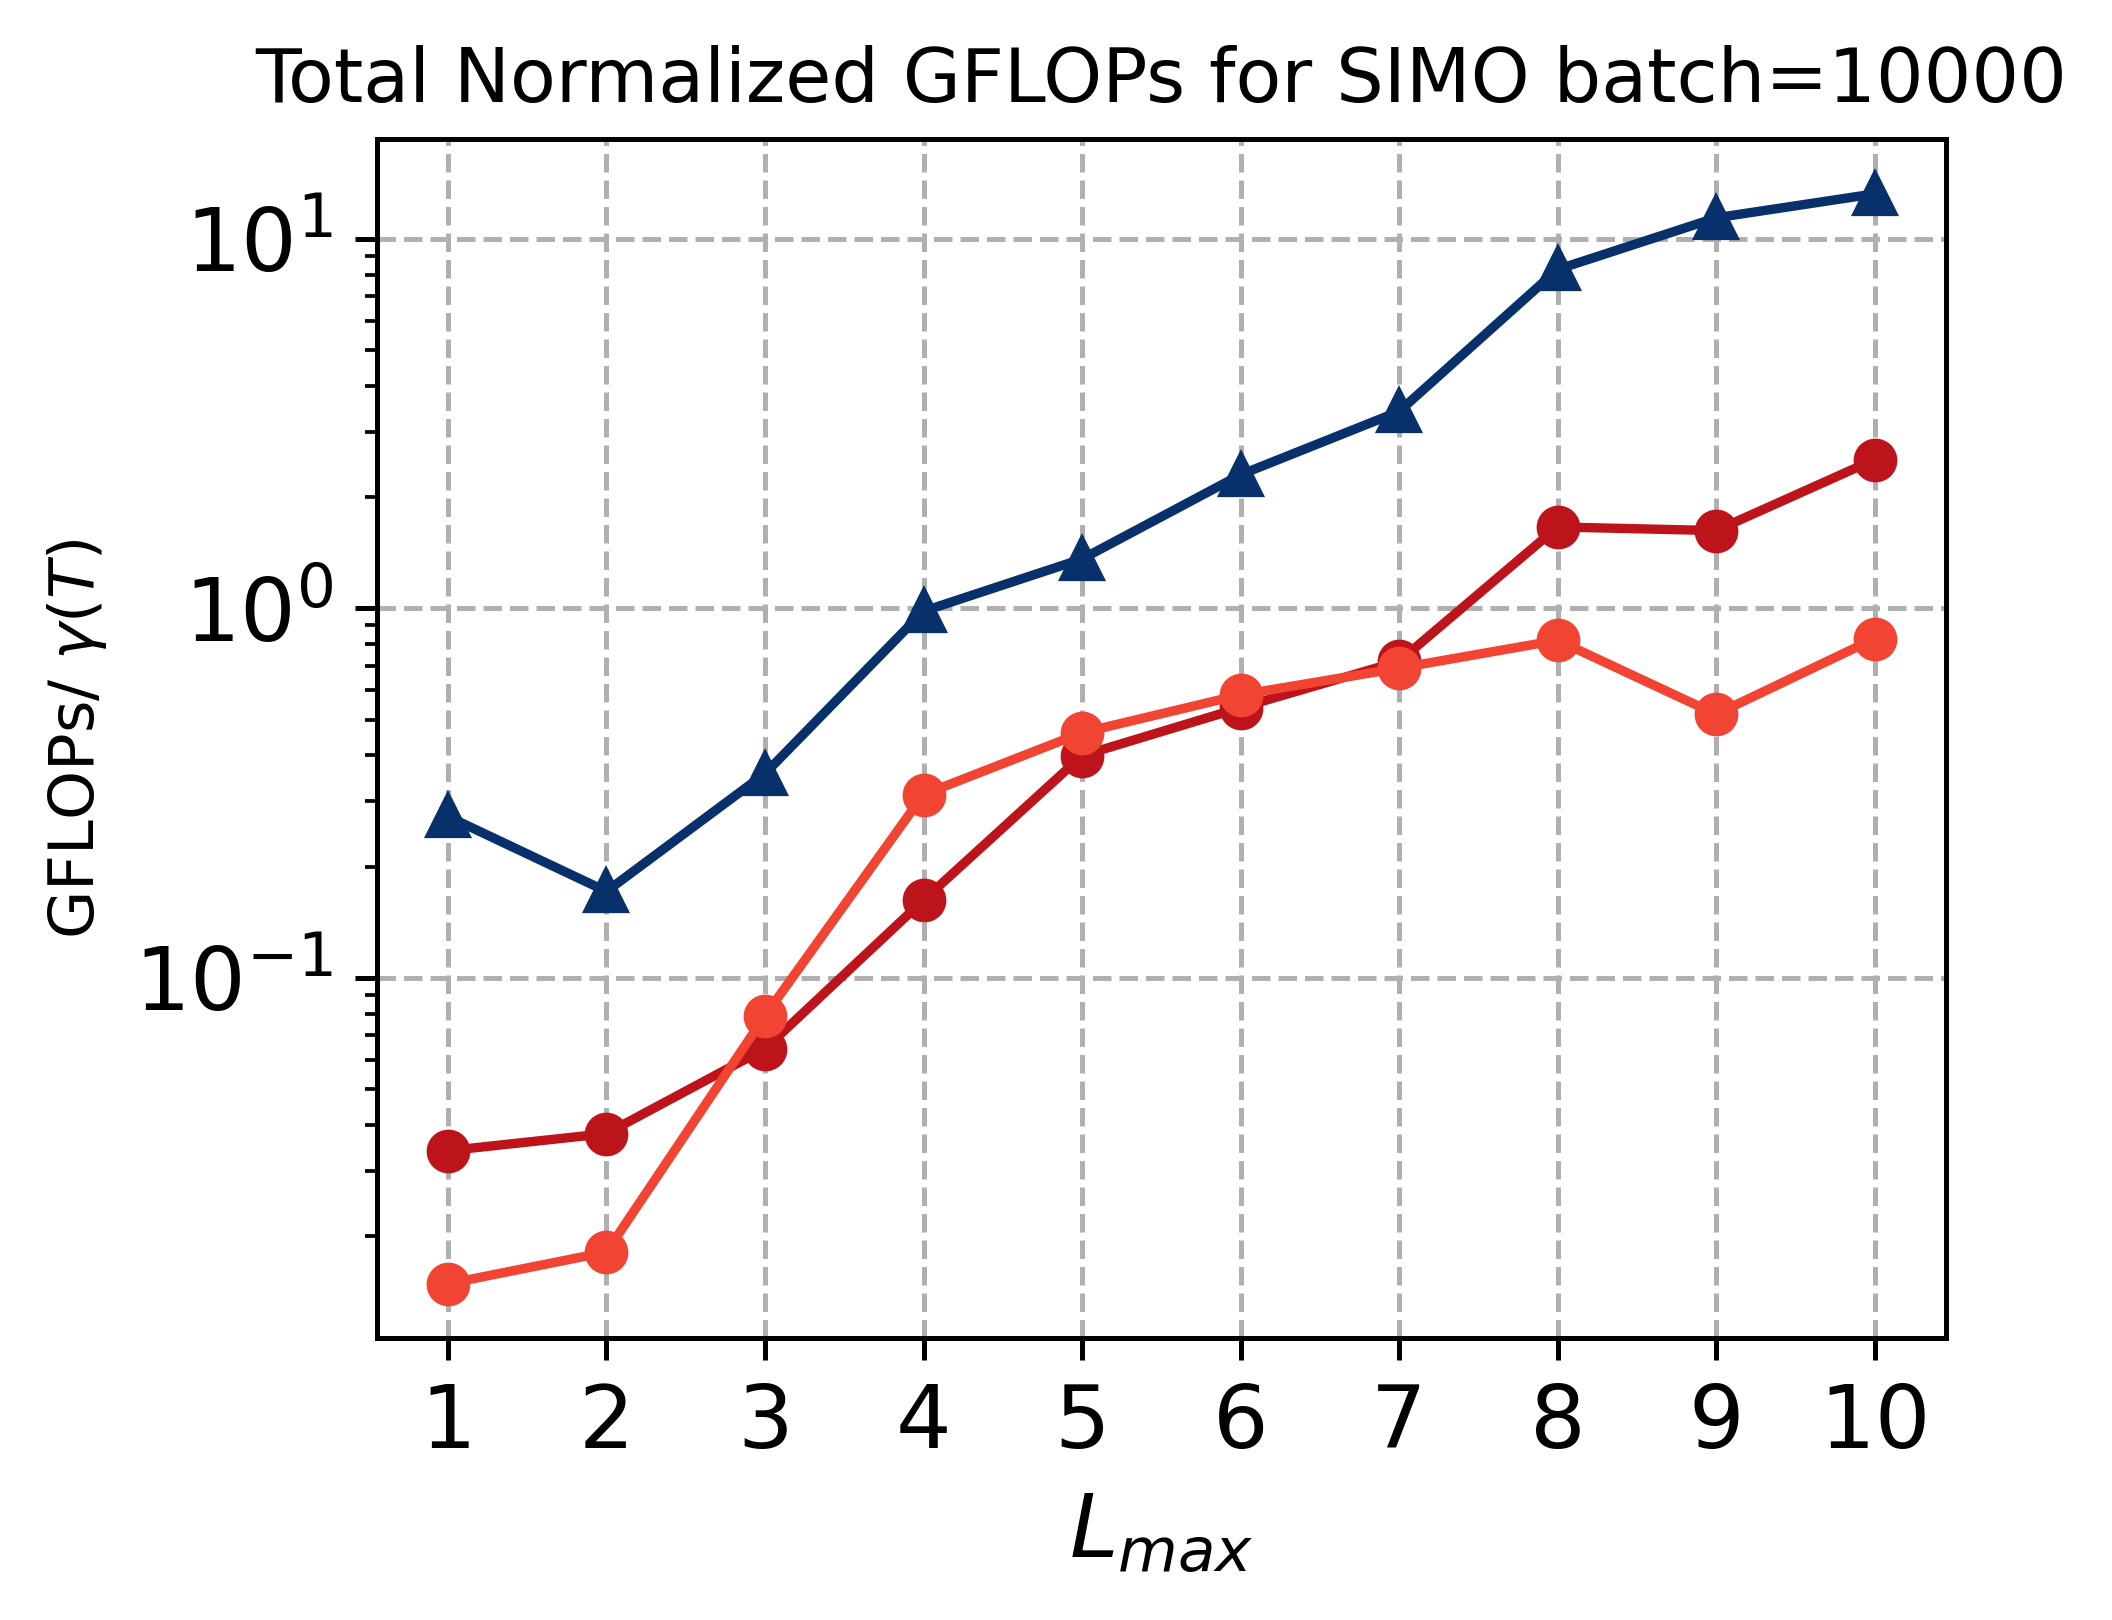

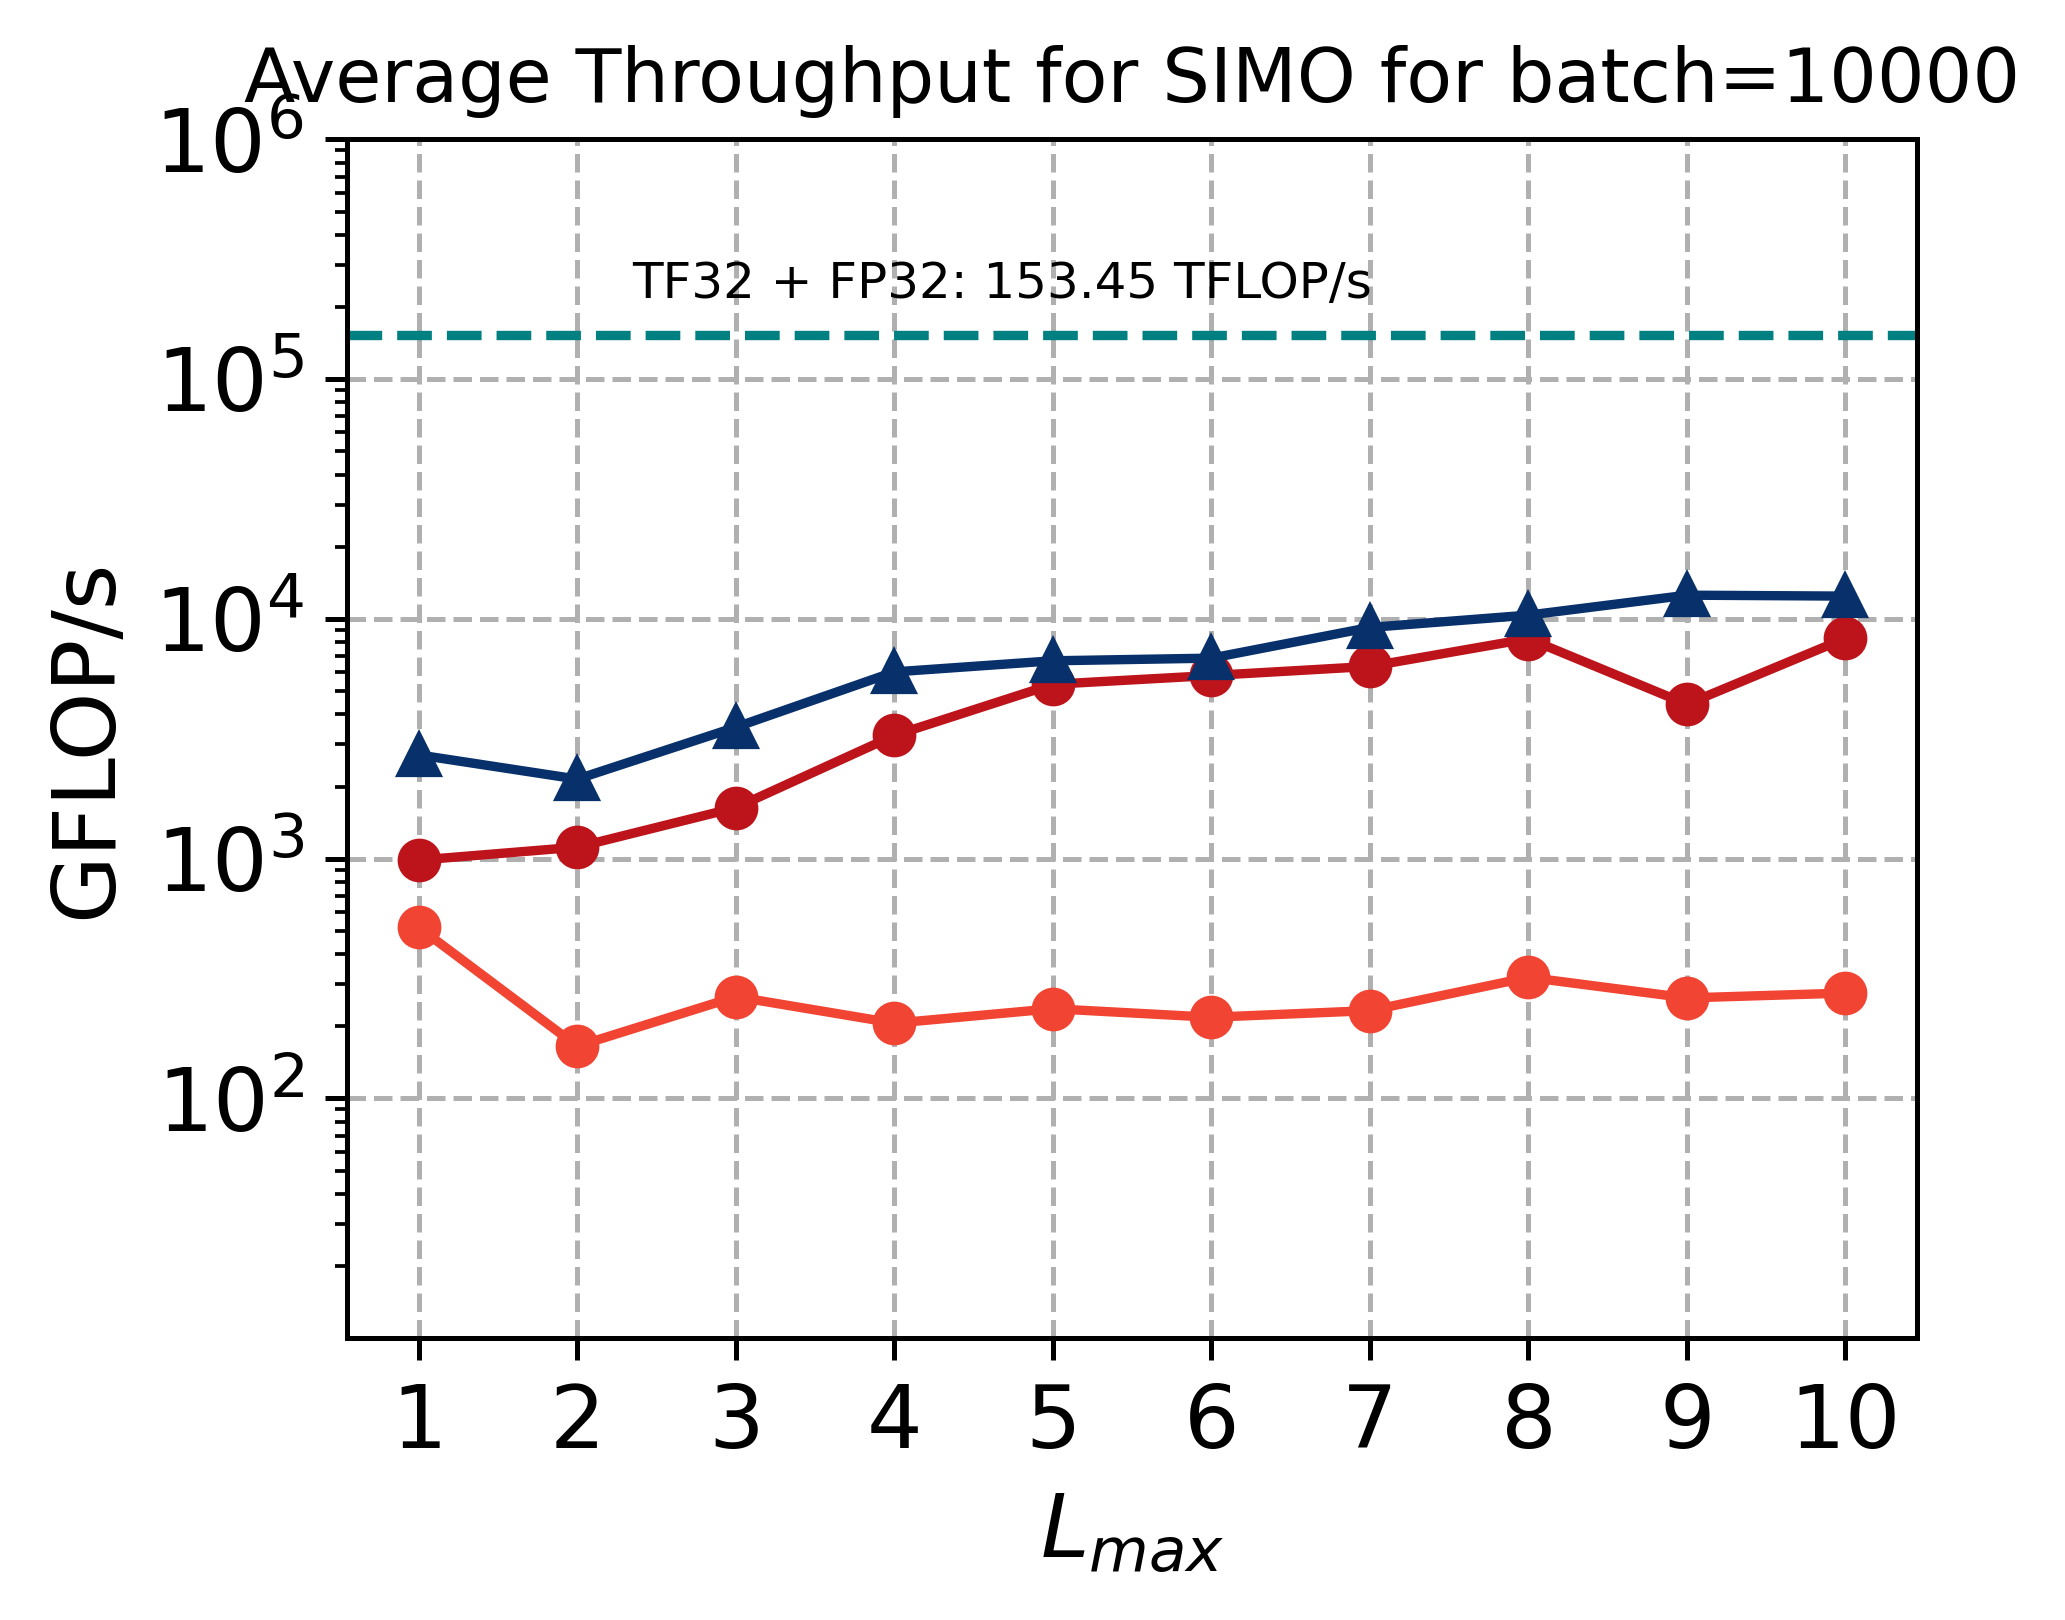

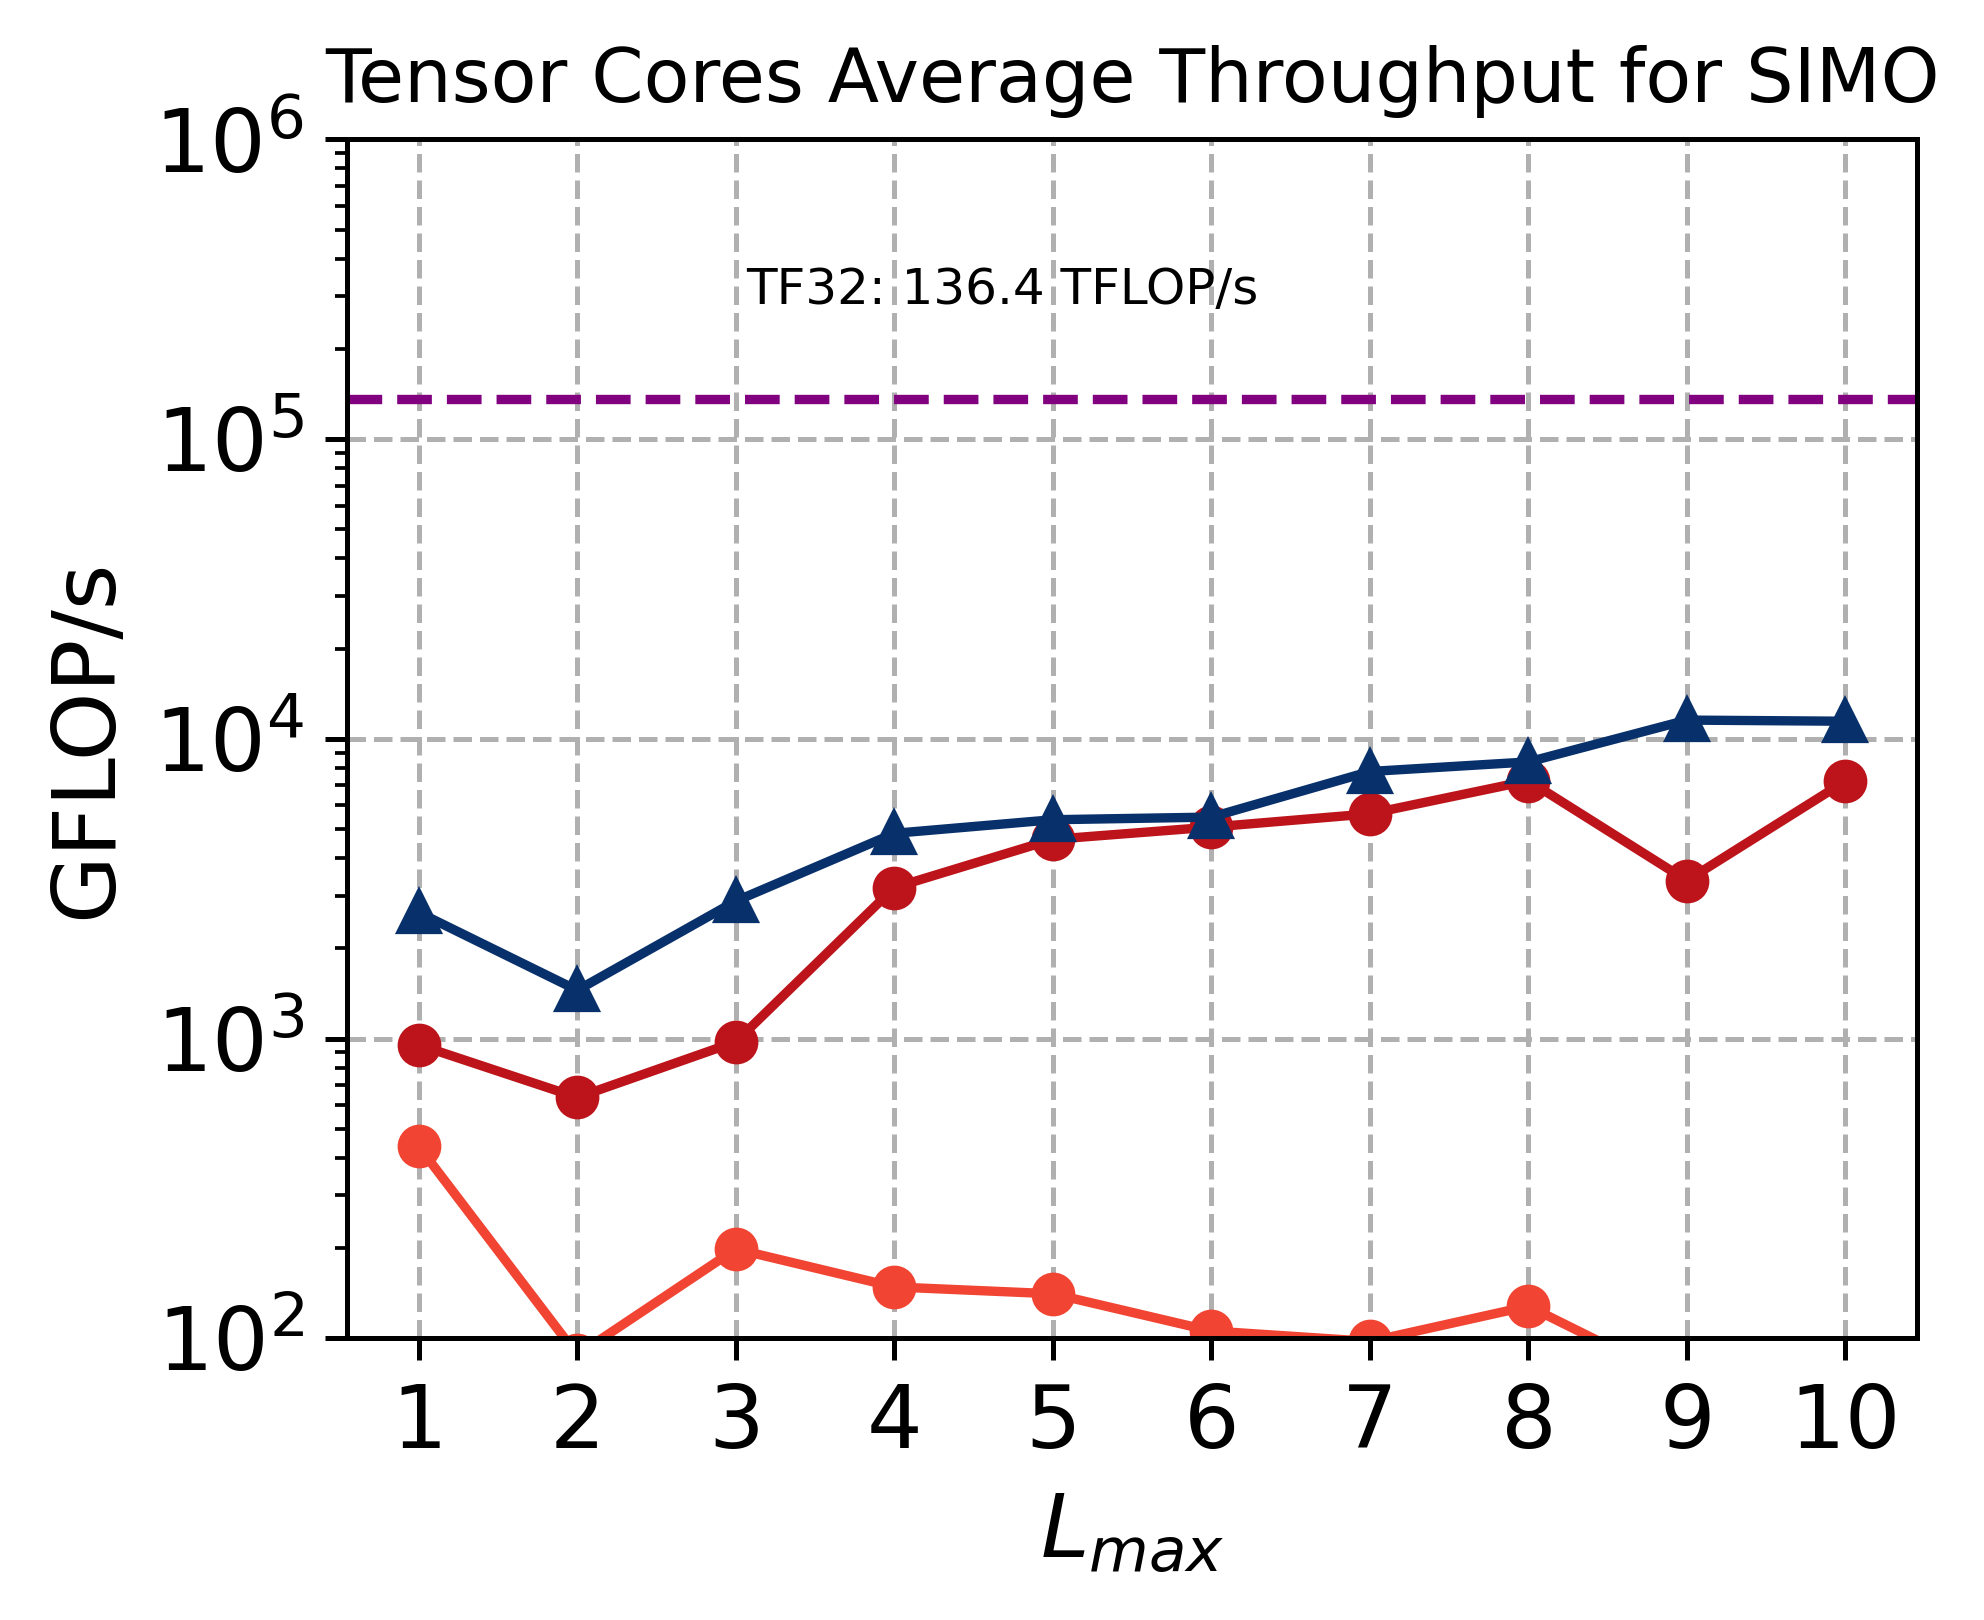

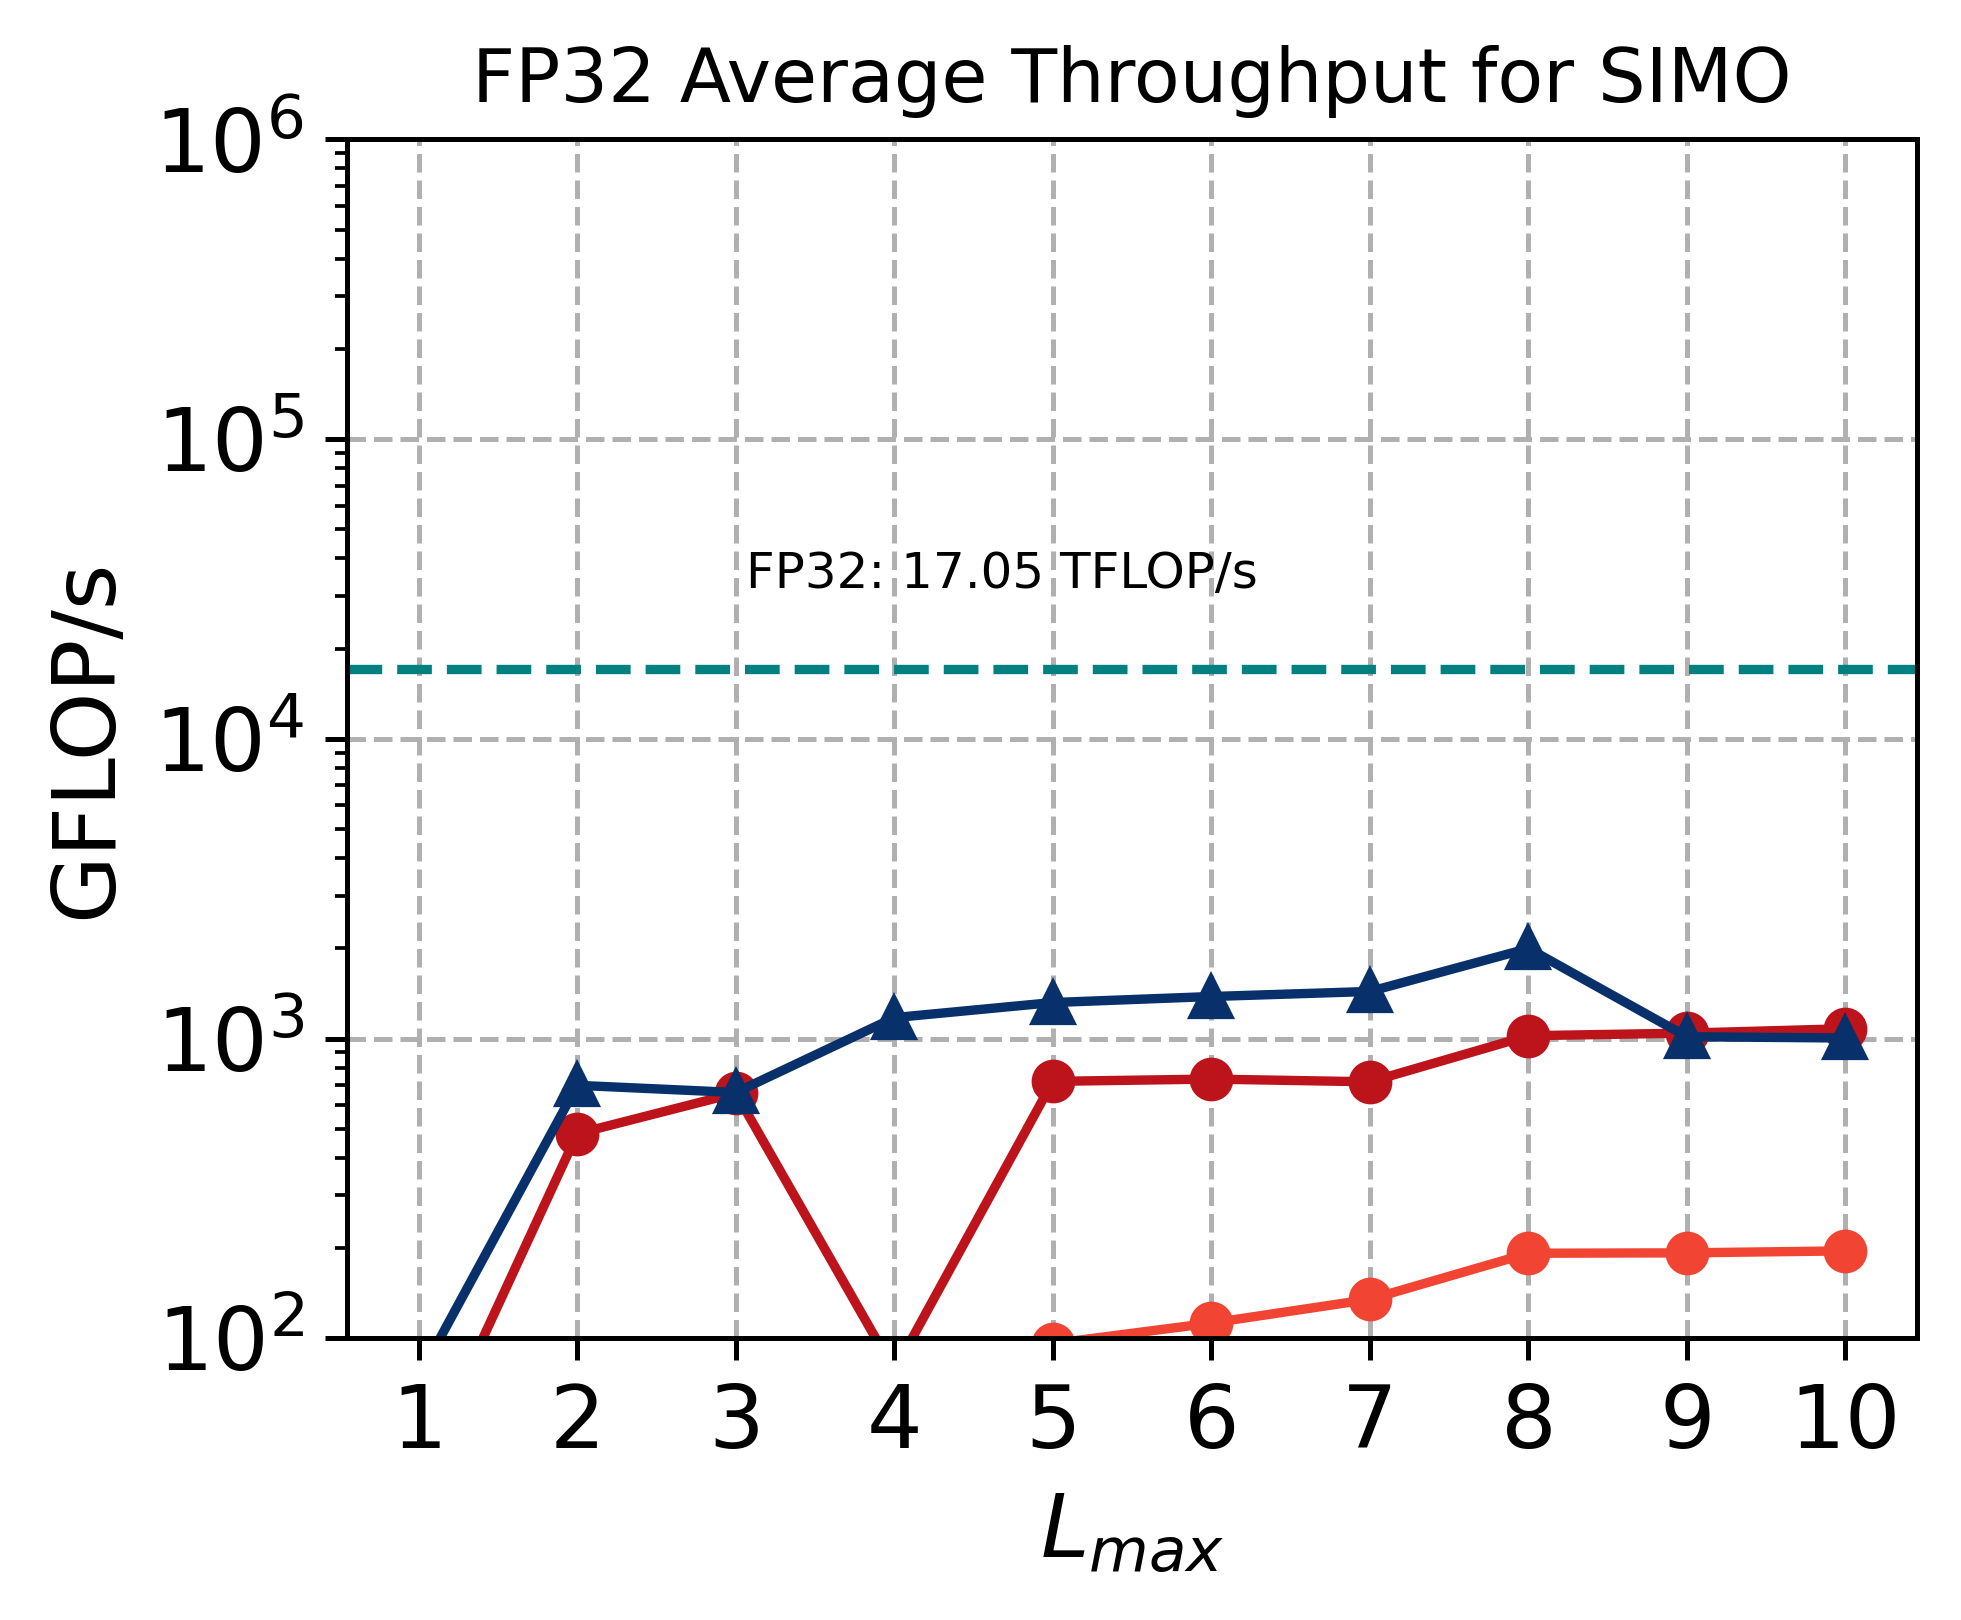

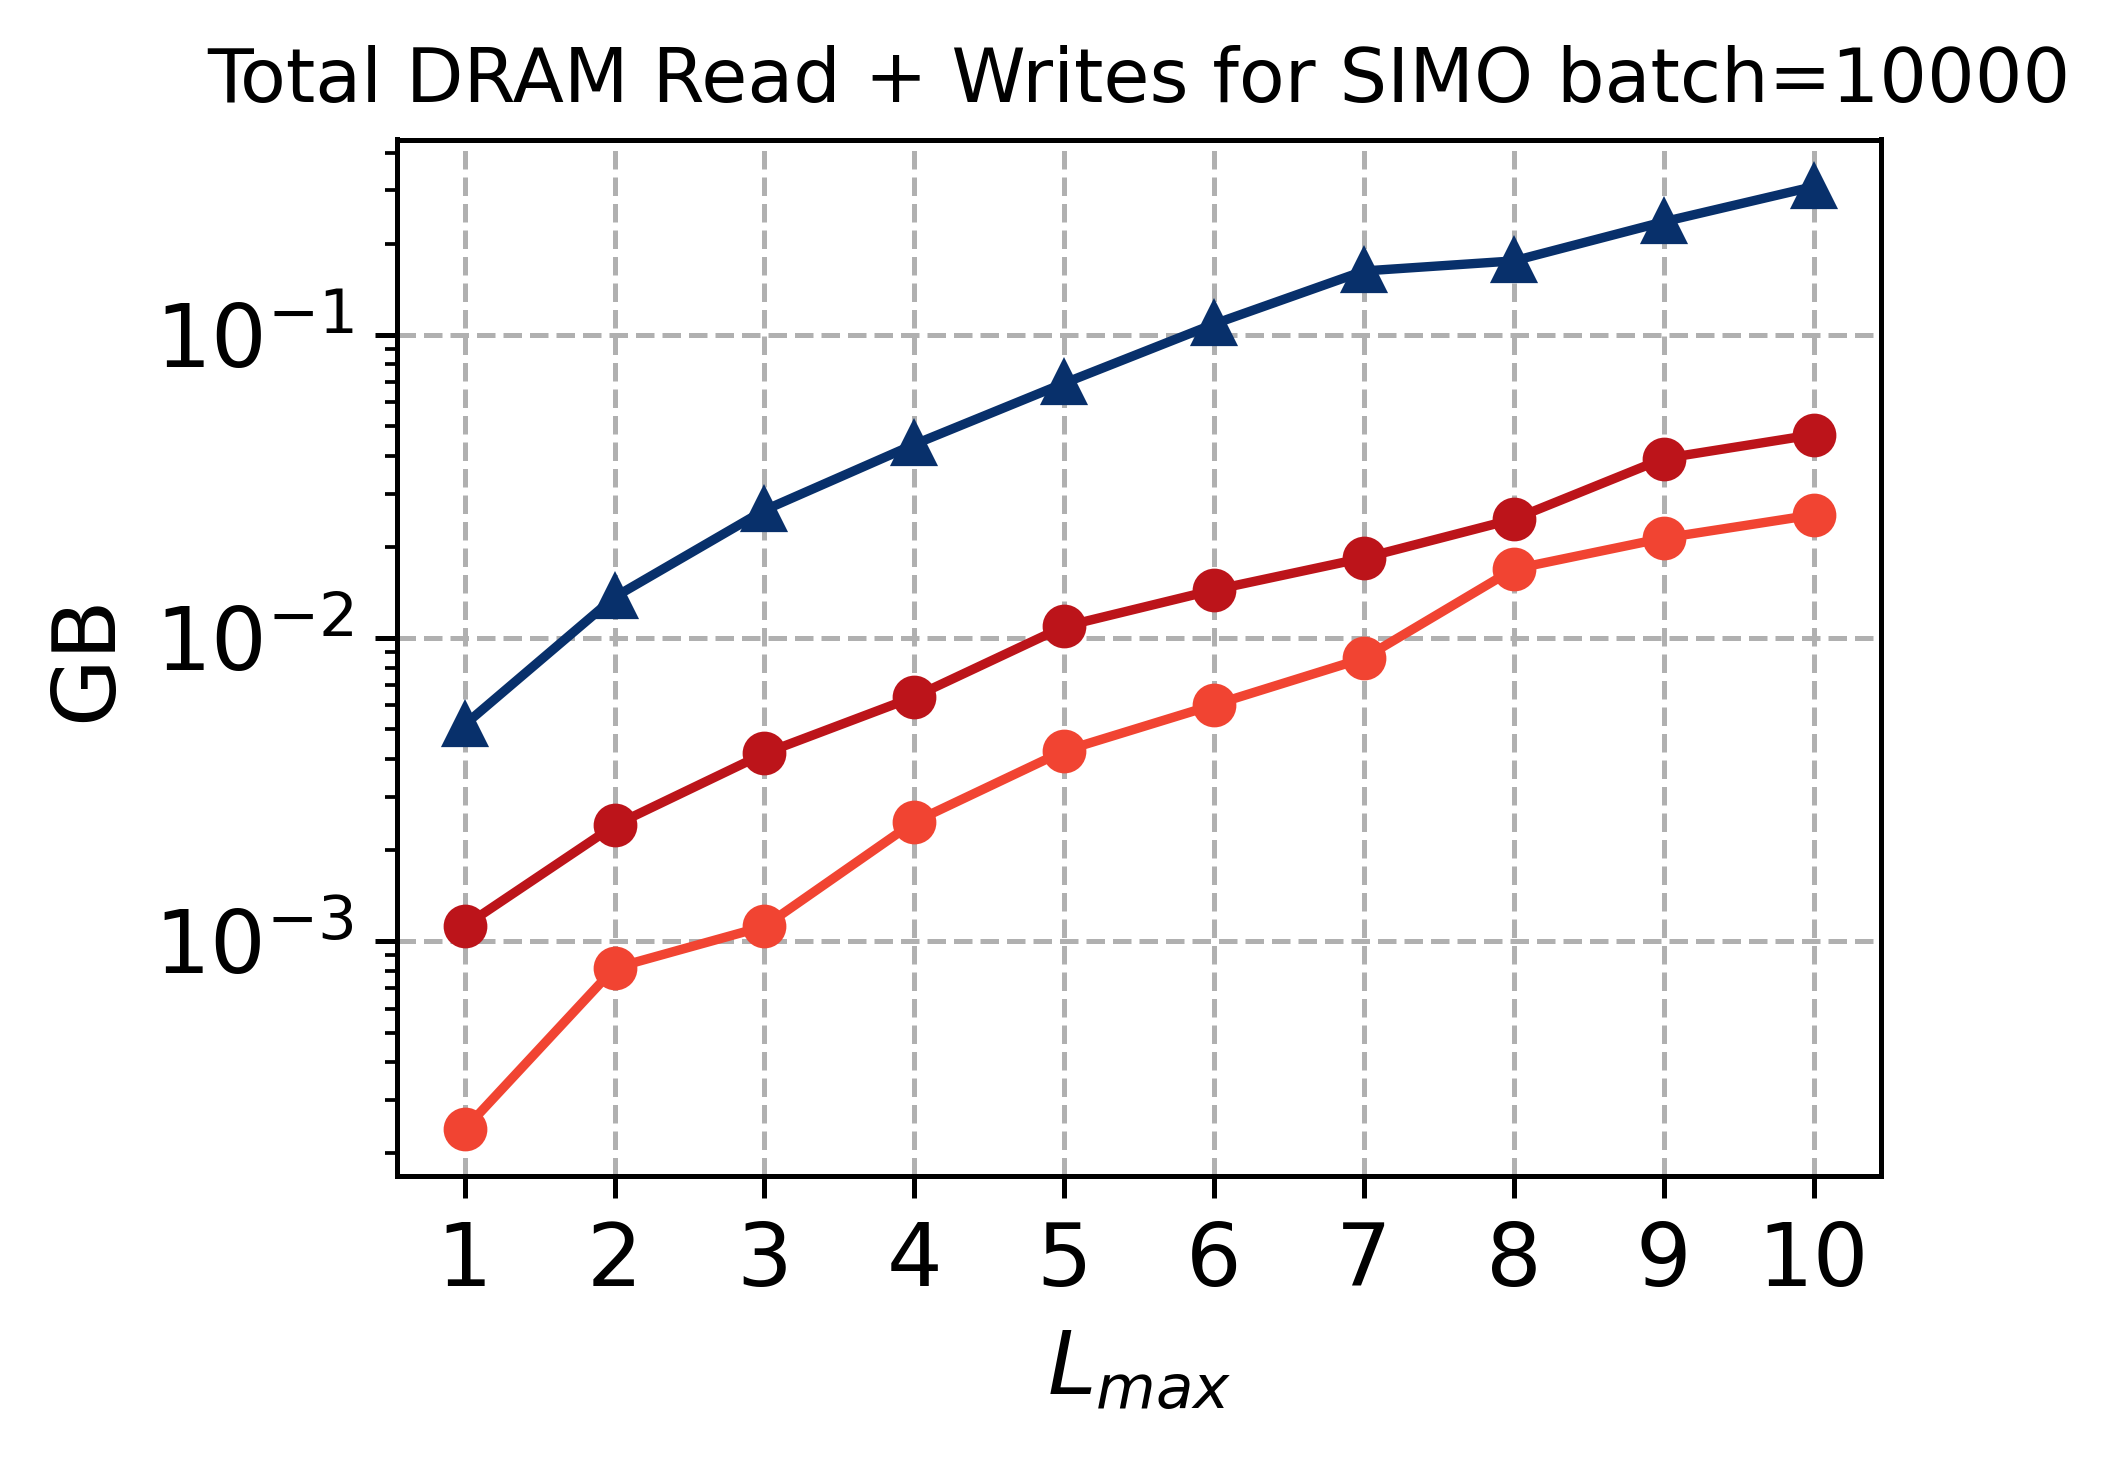

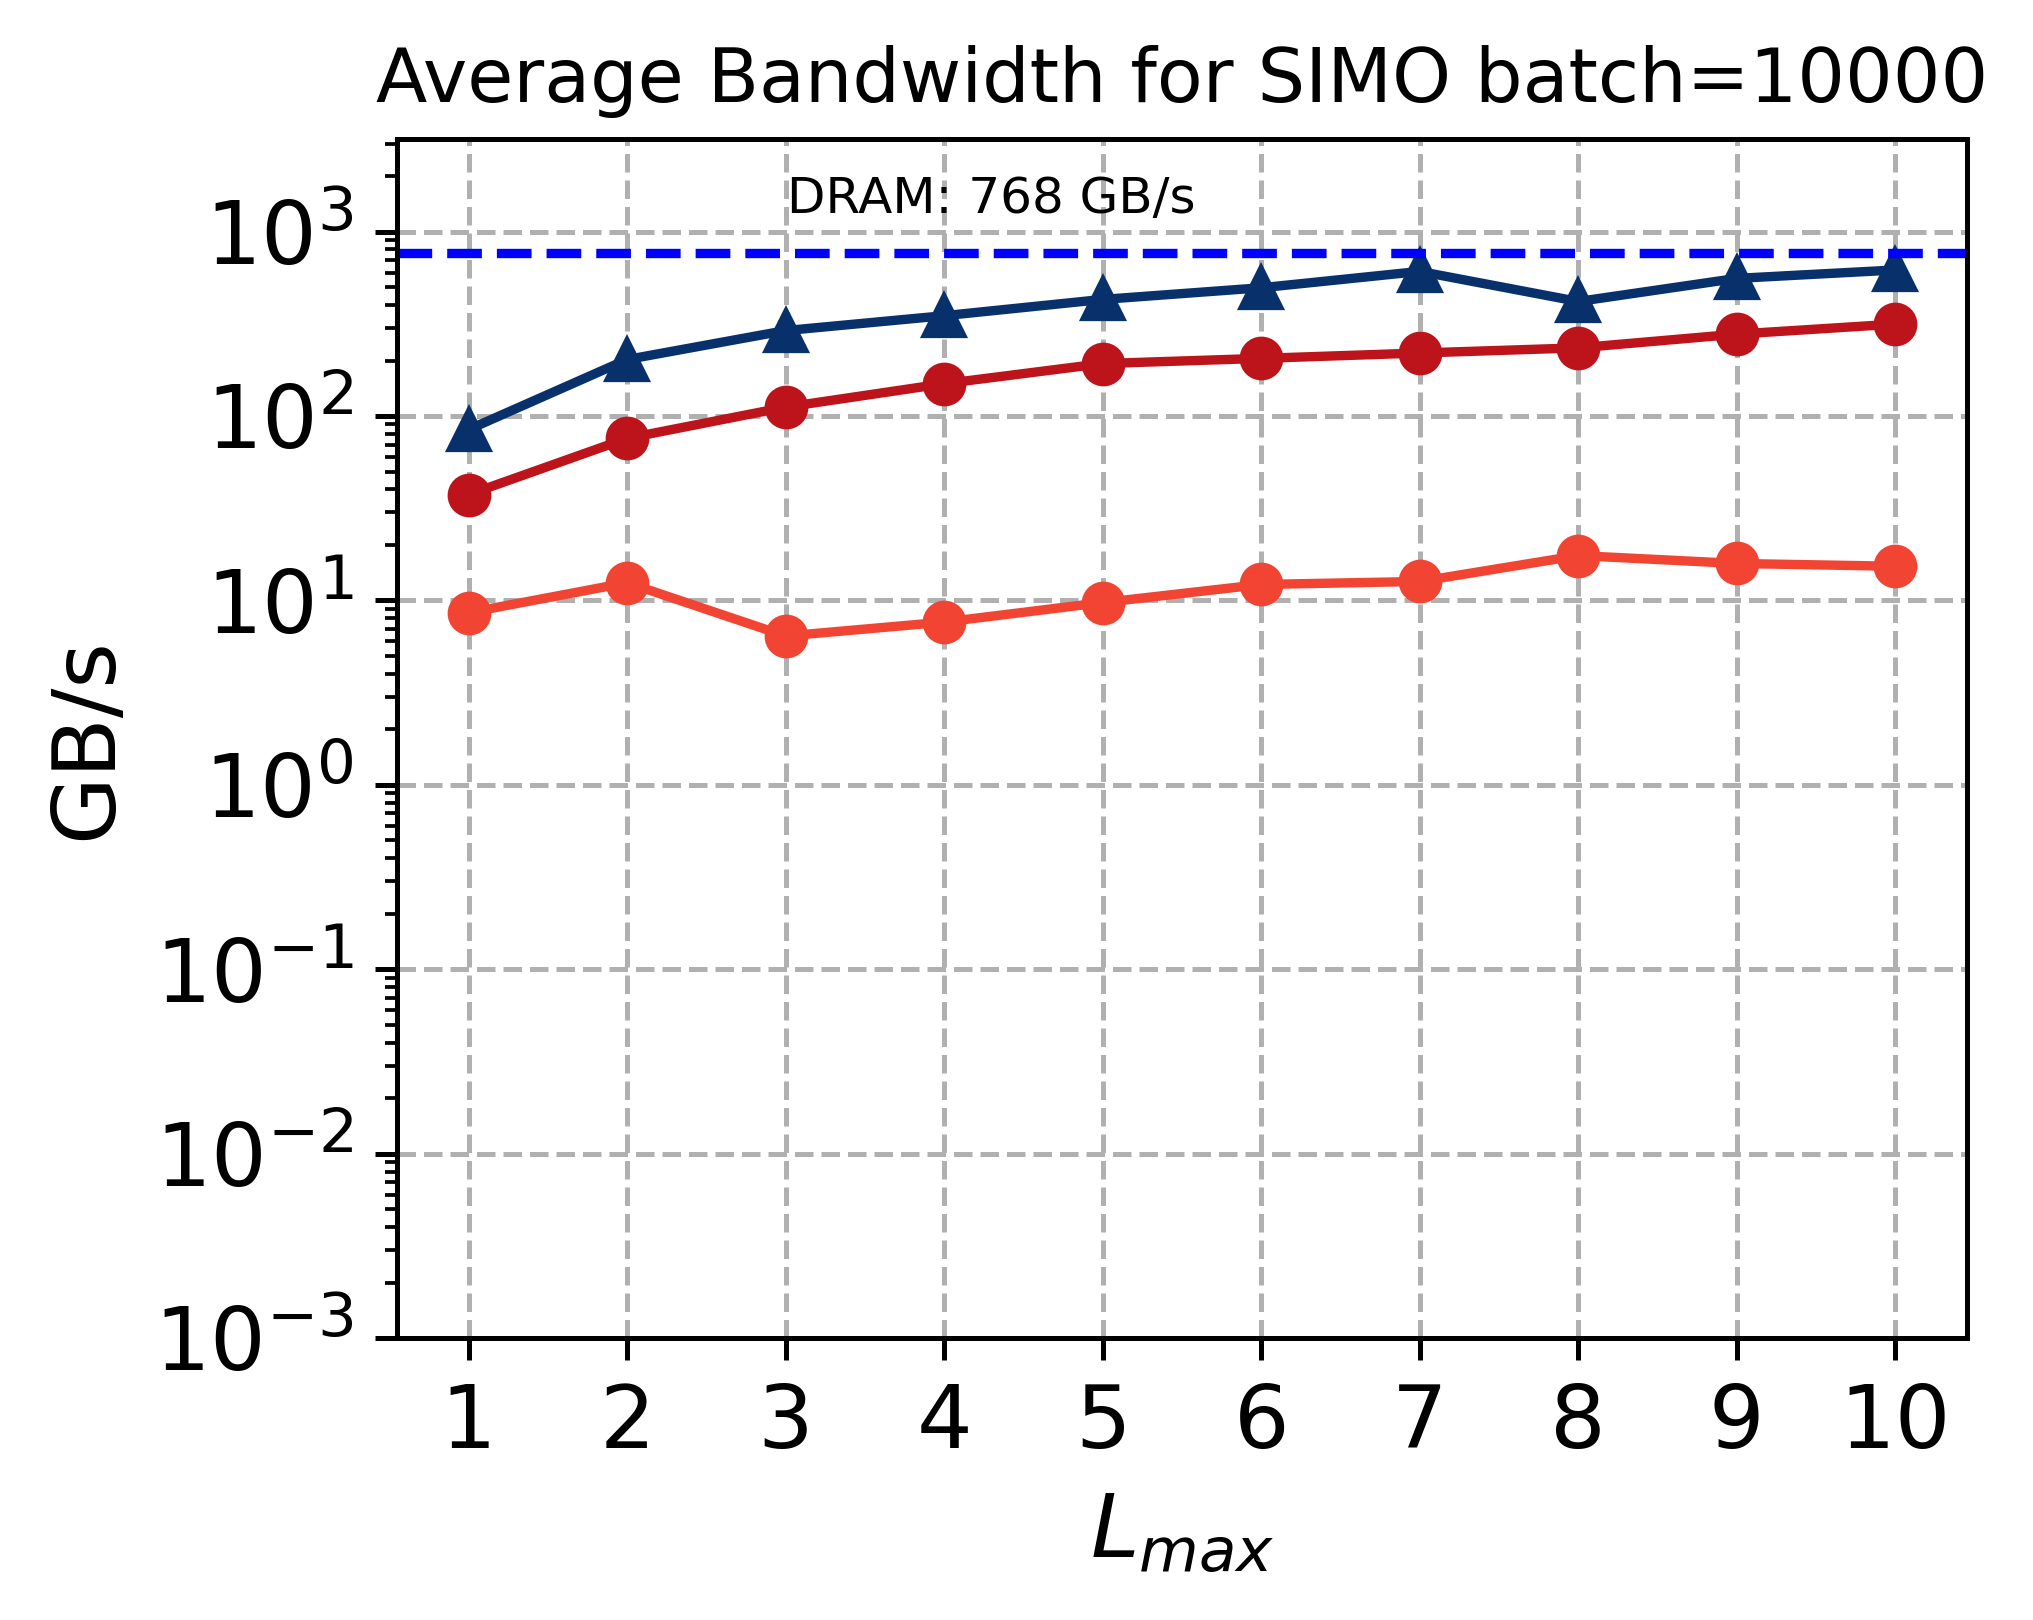

In [19]:
plot_iclr_sweep("SIMO", 10000)

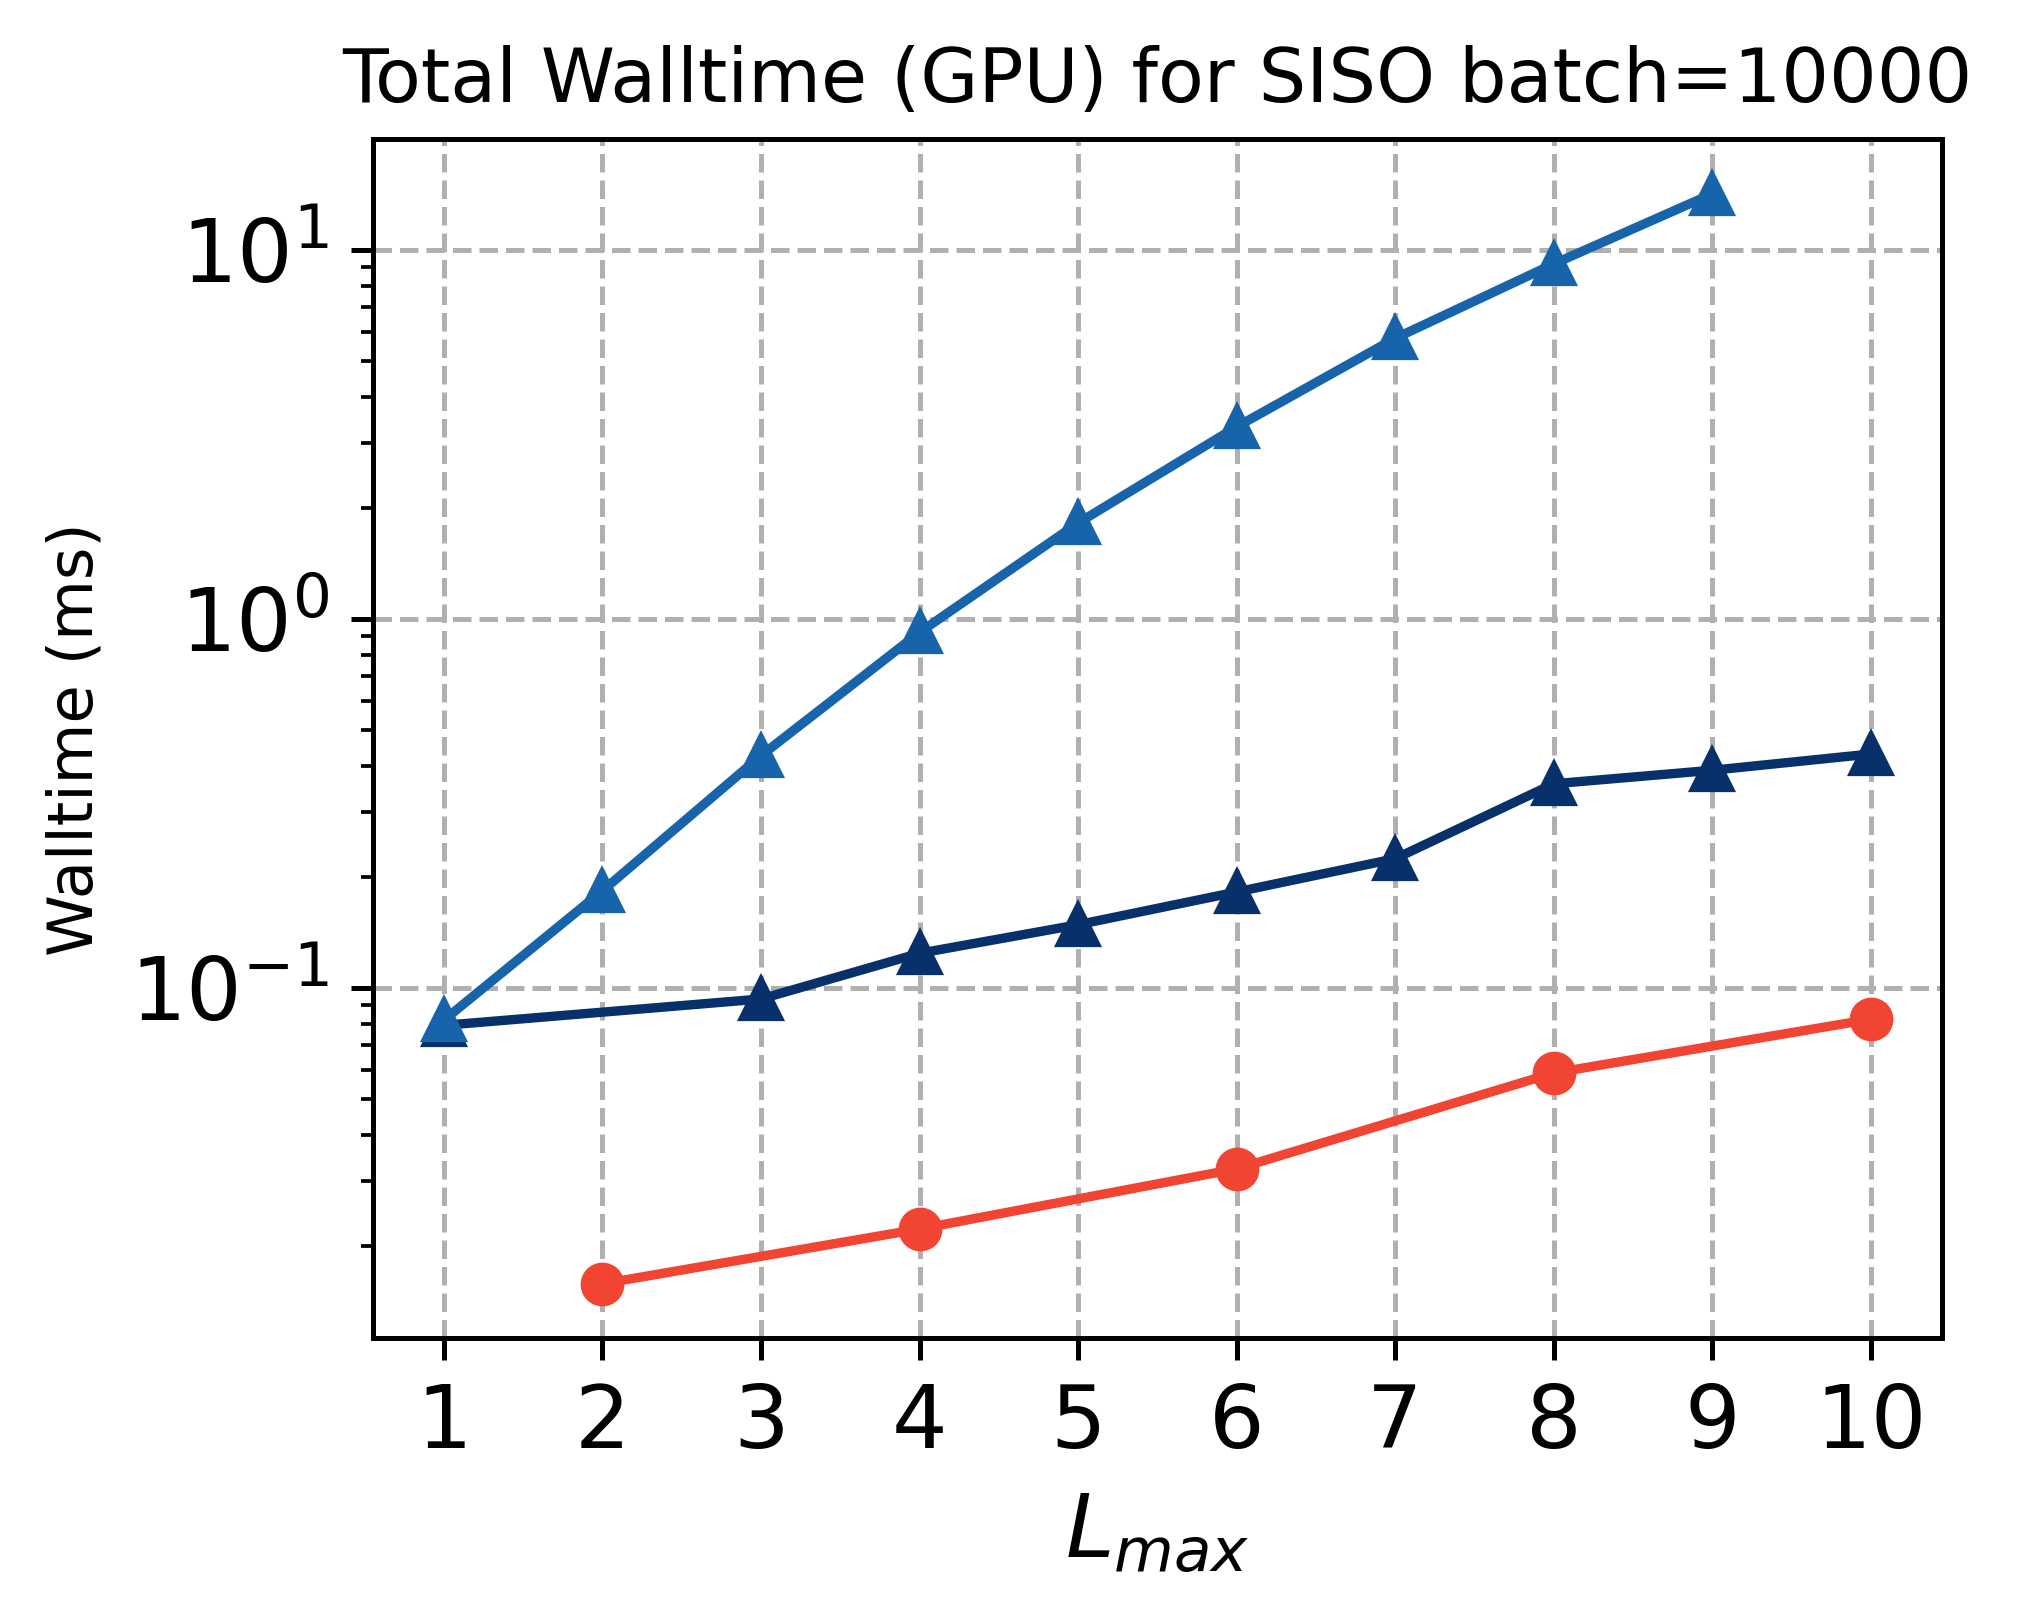

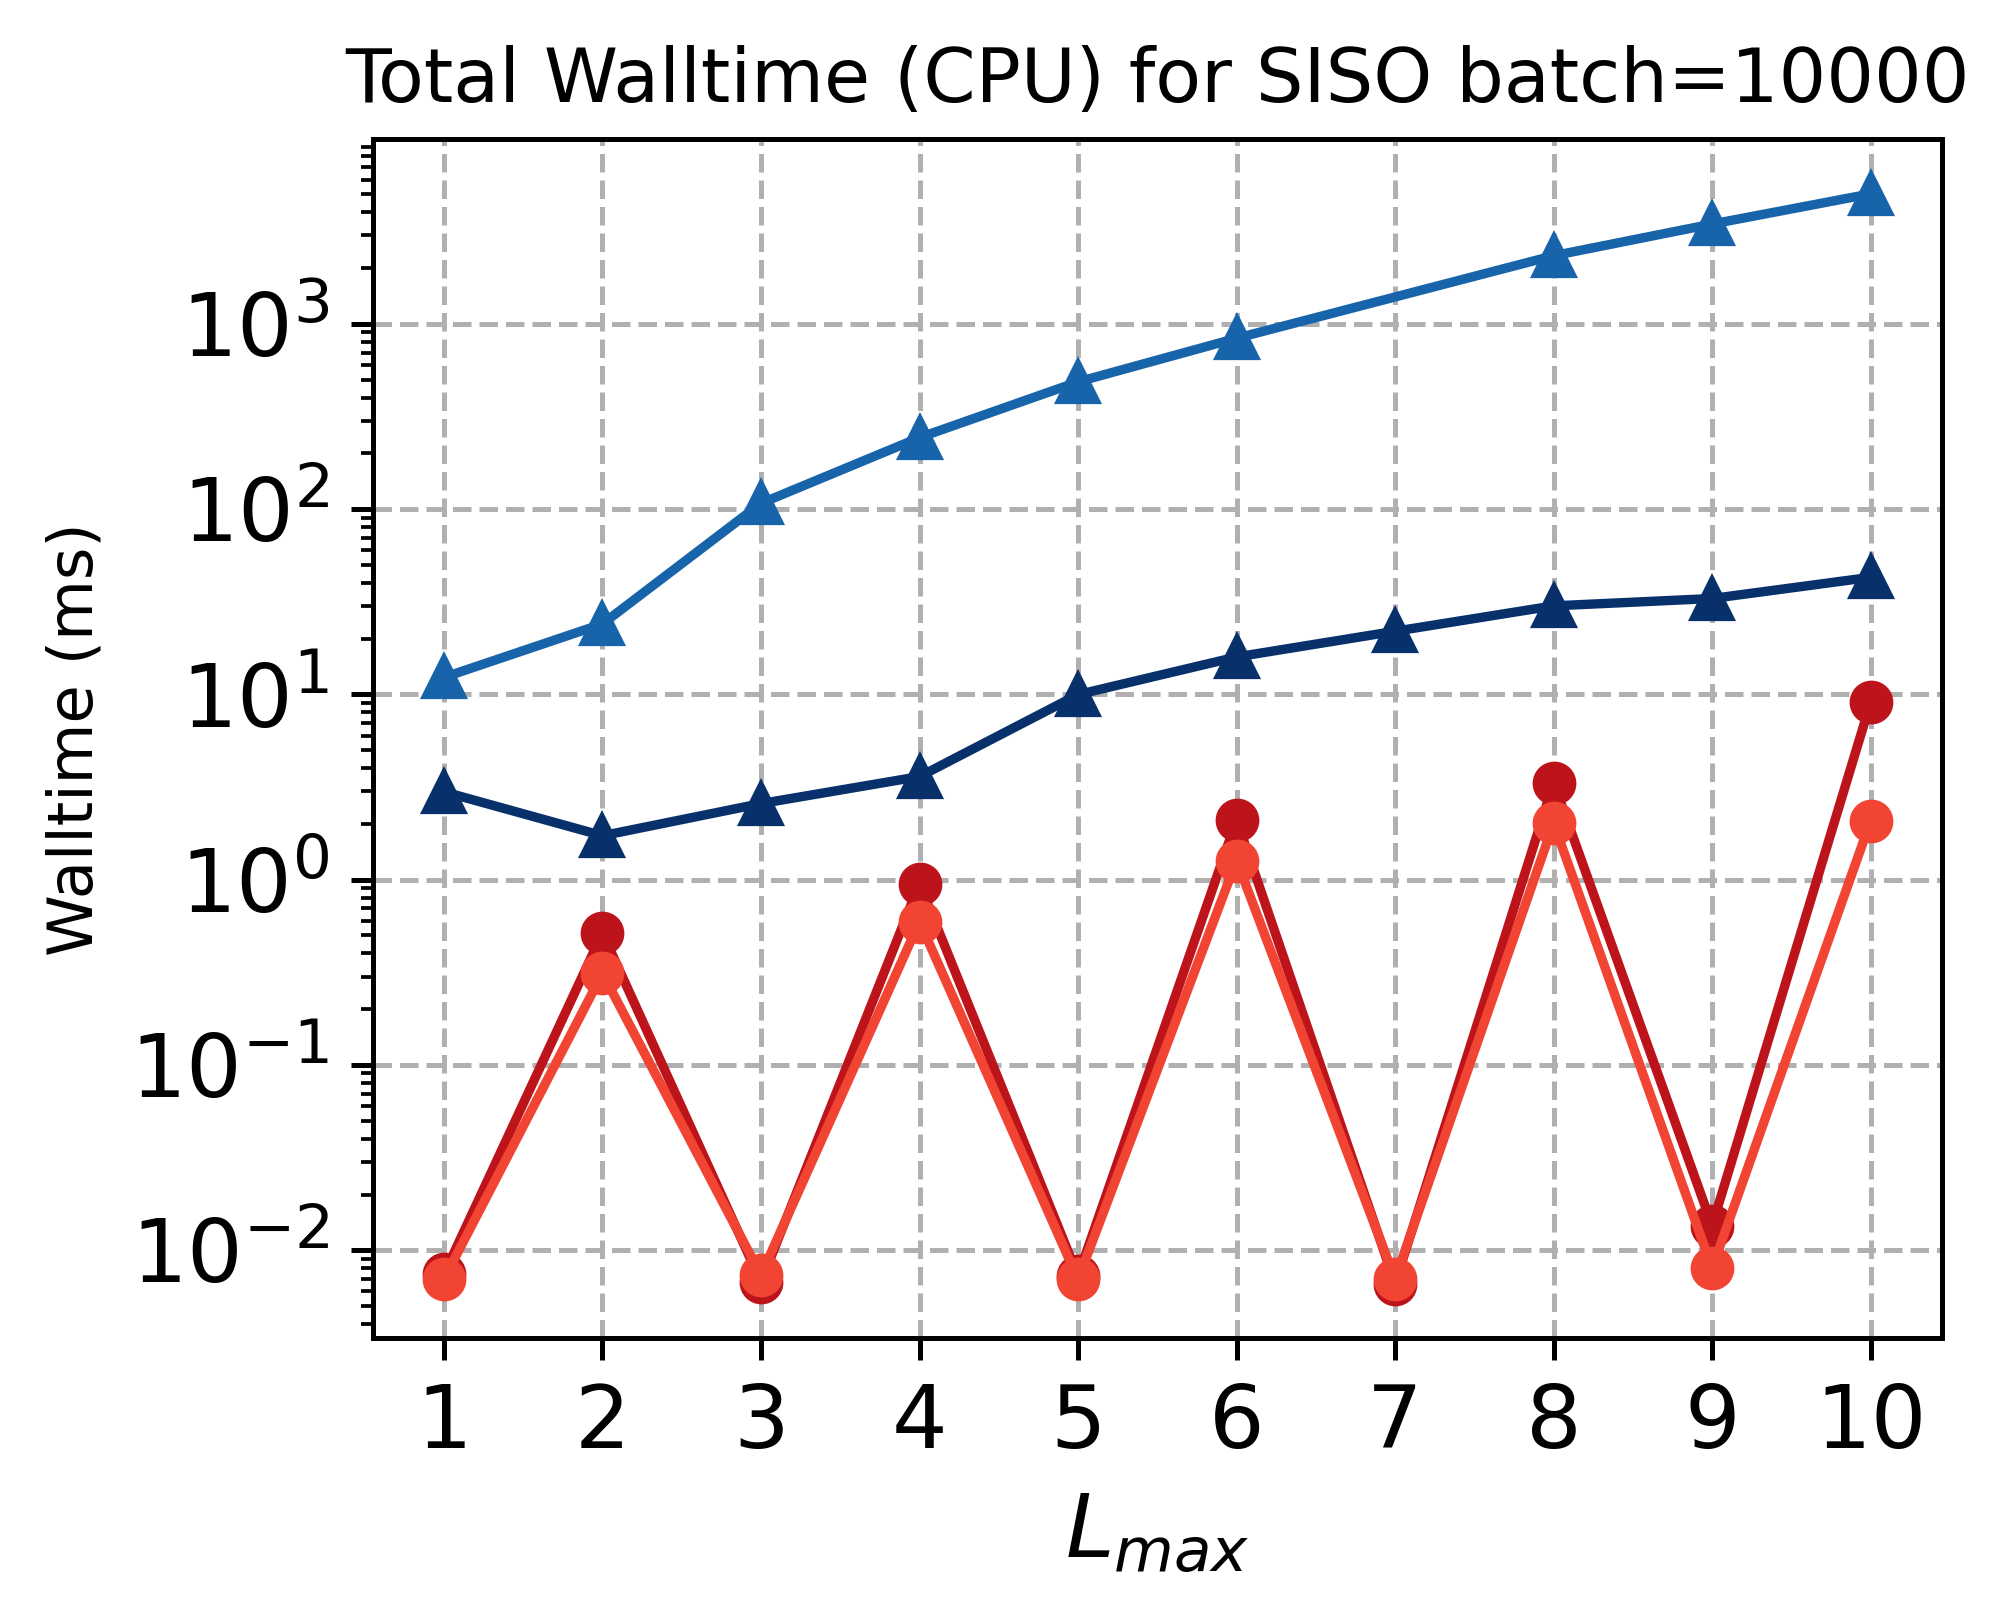

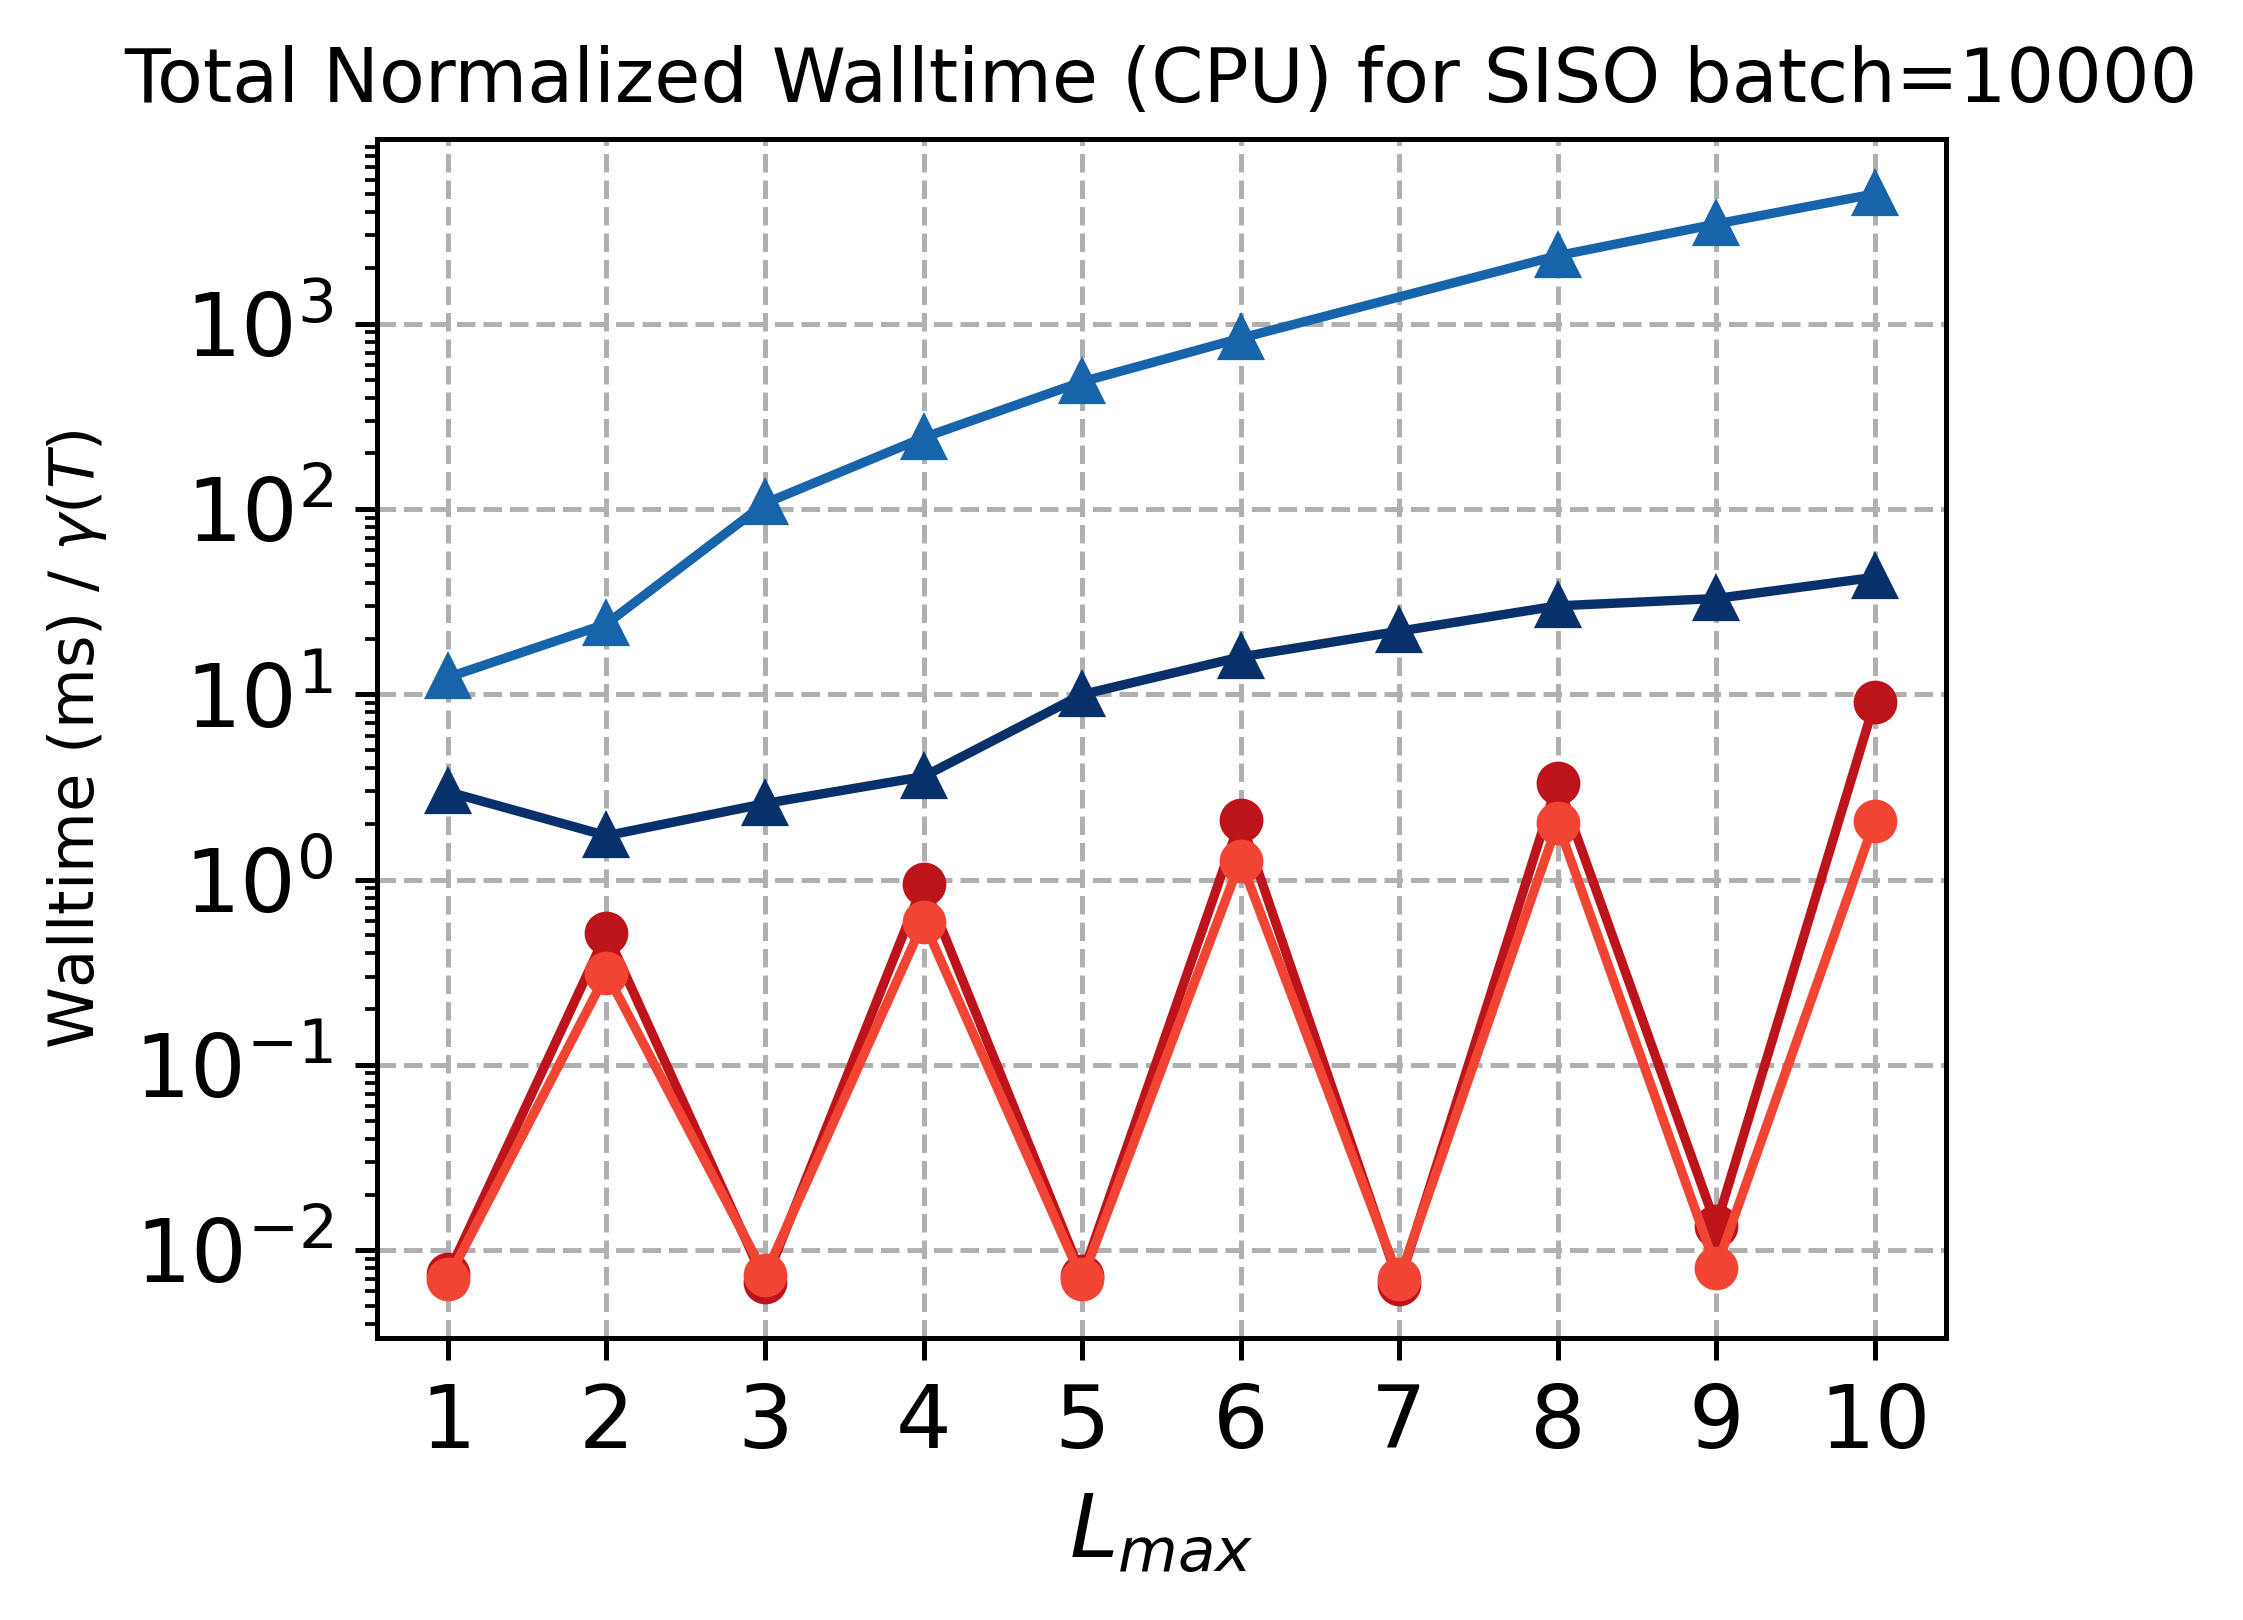

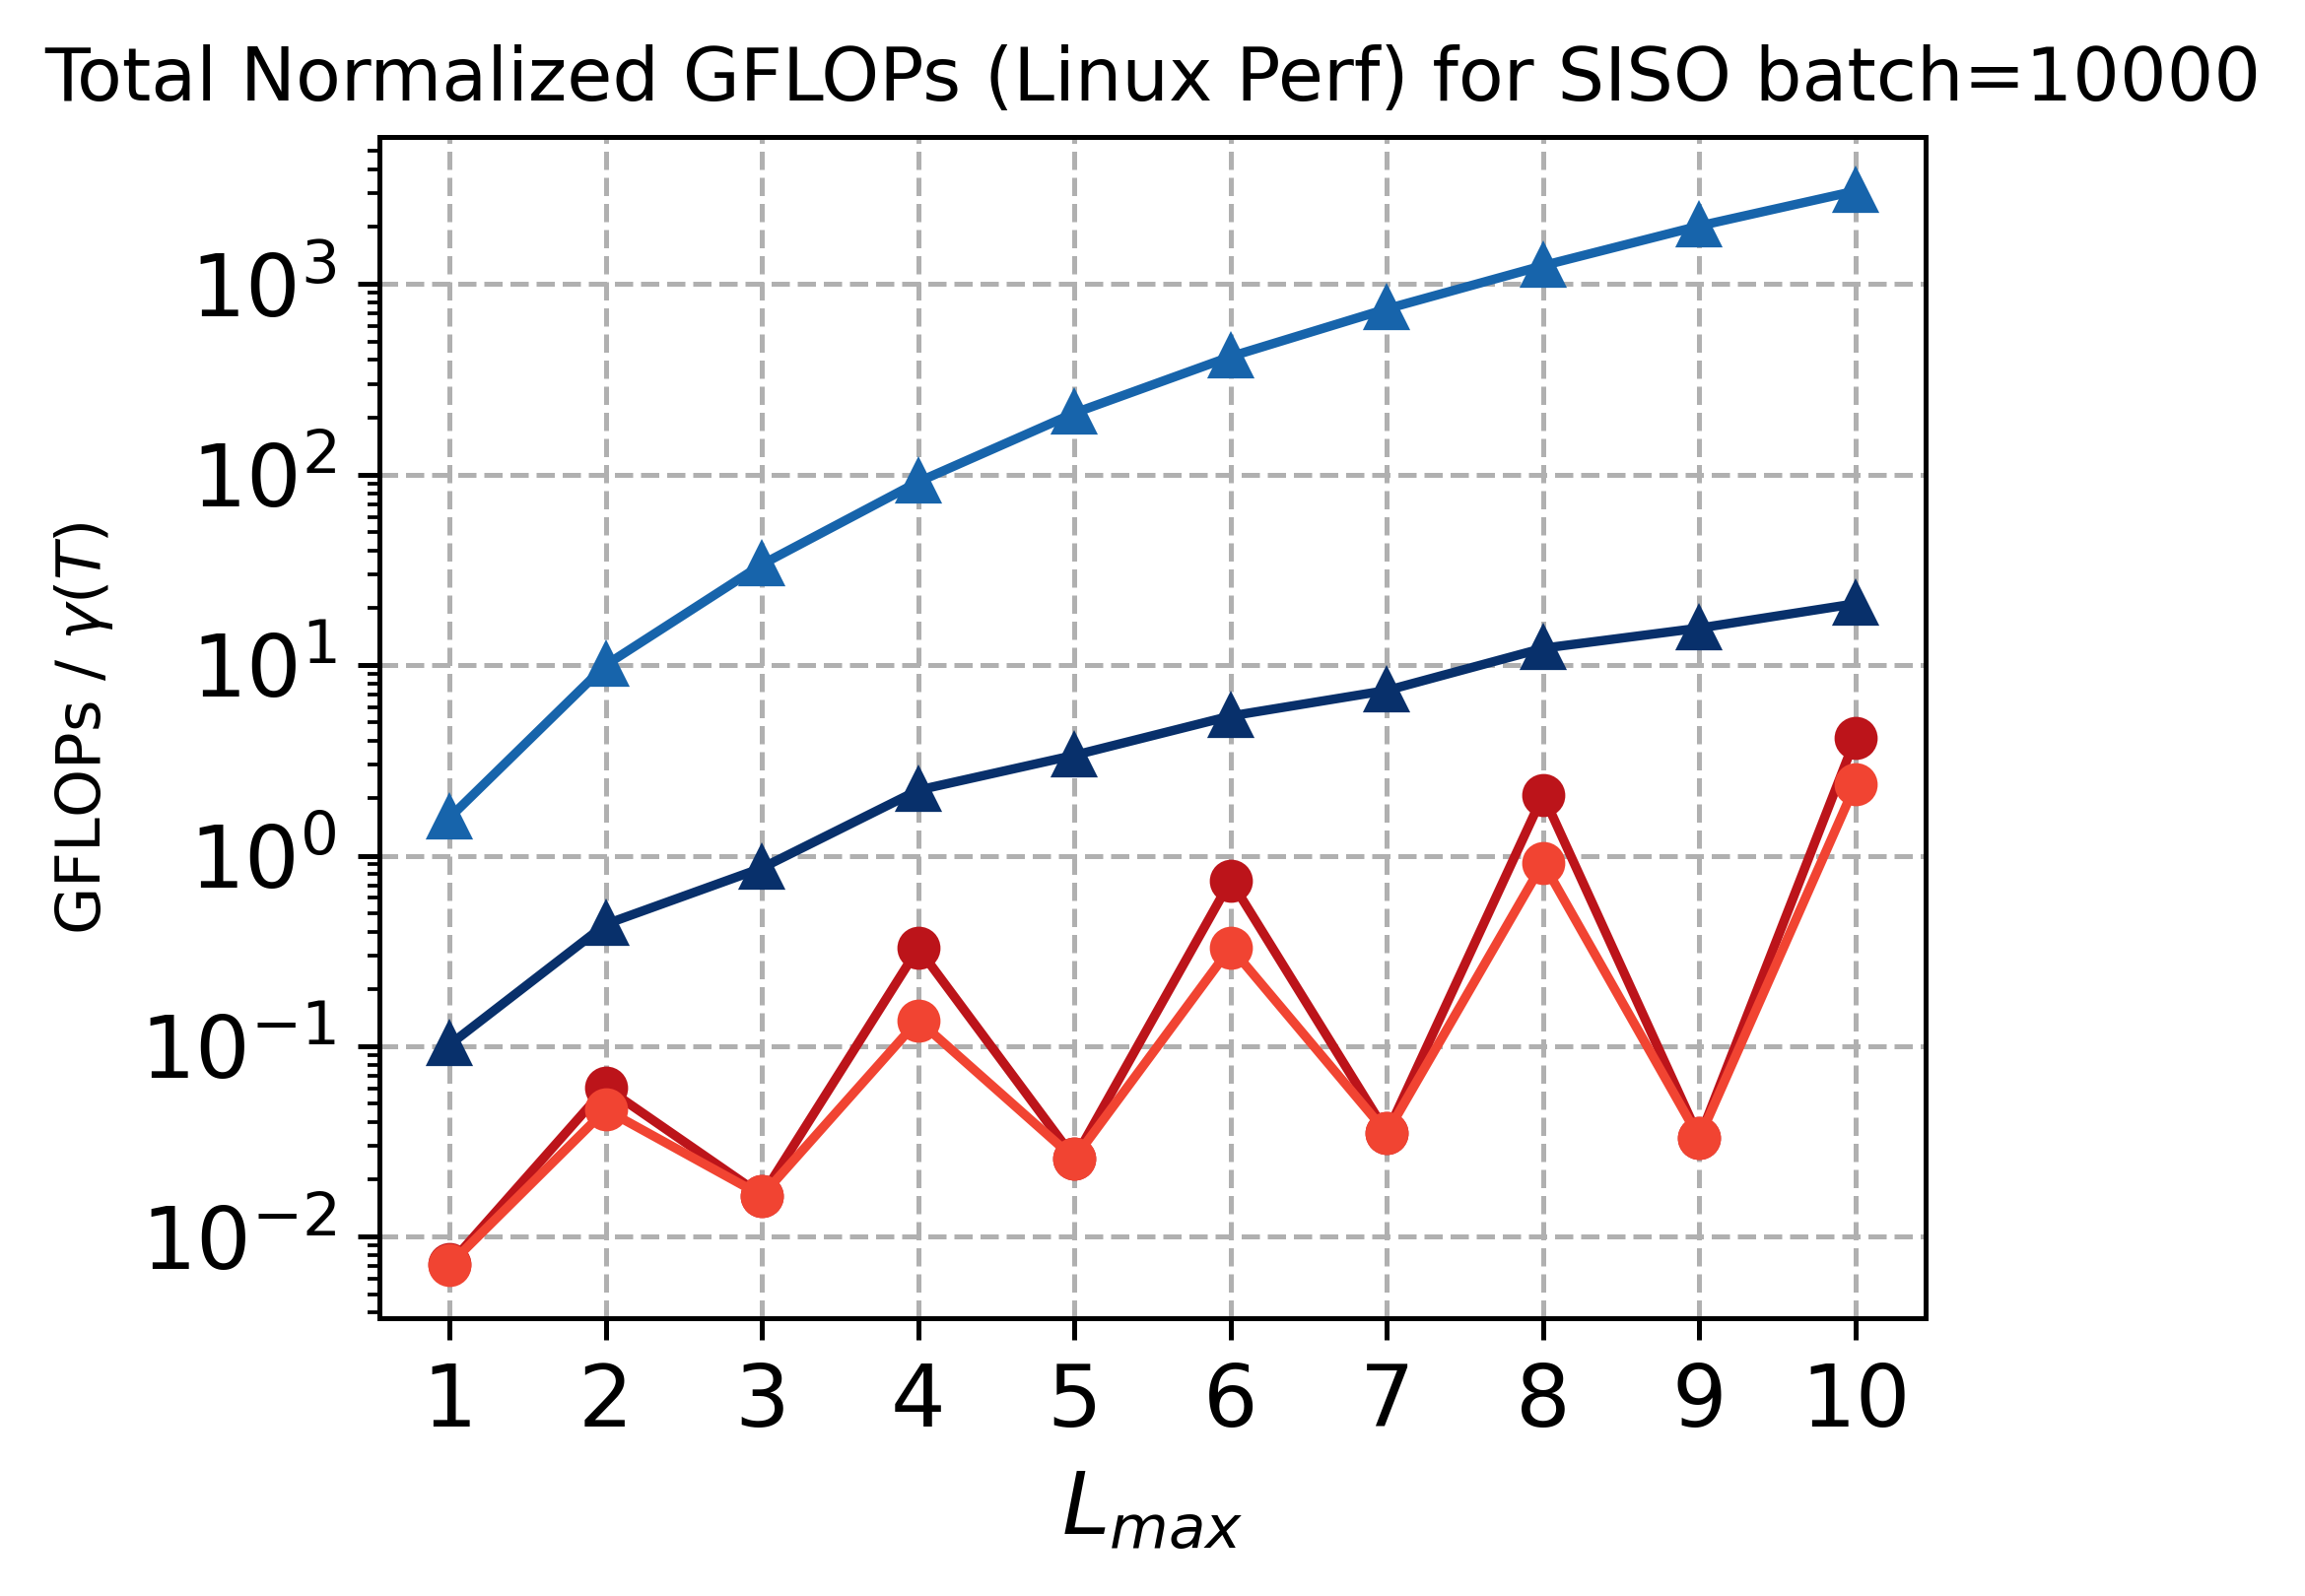

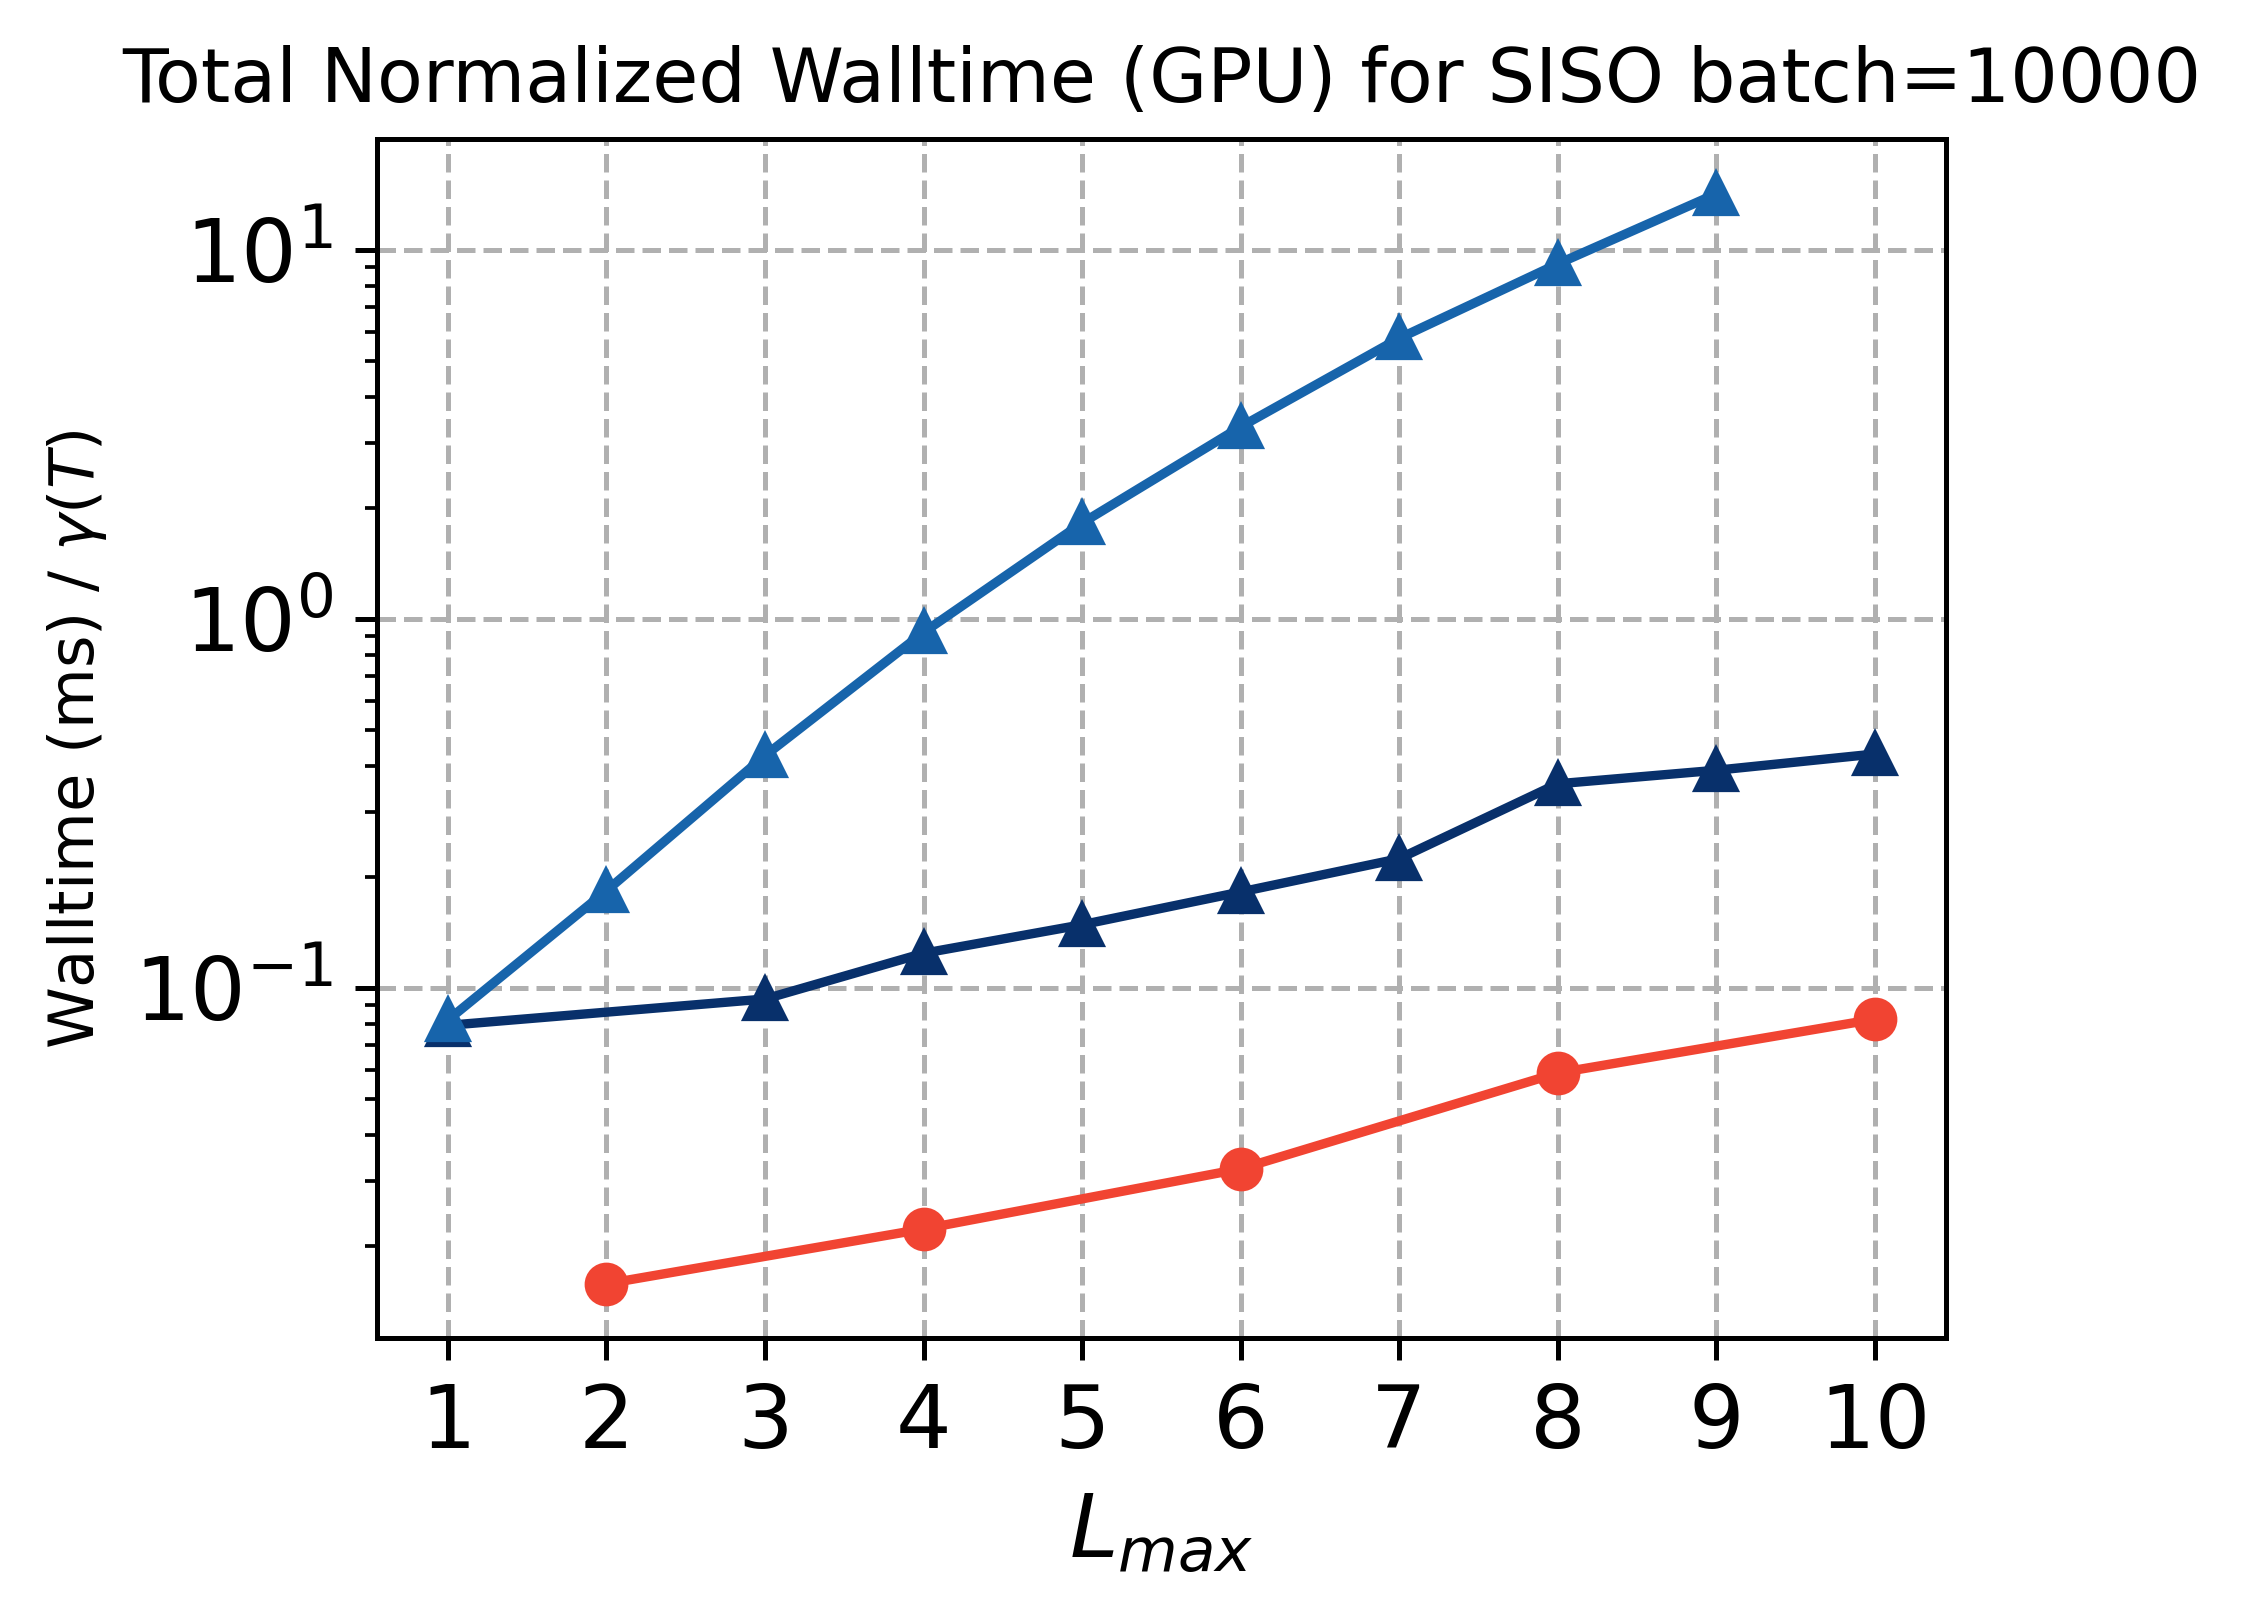

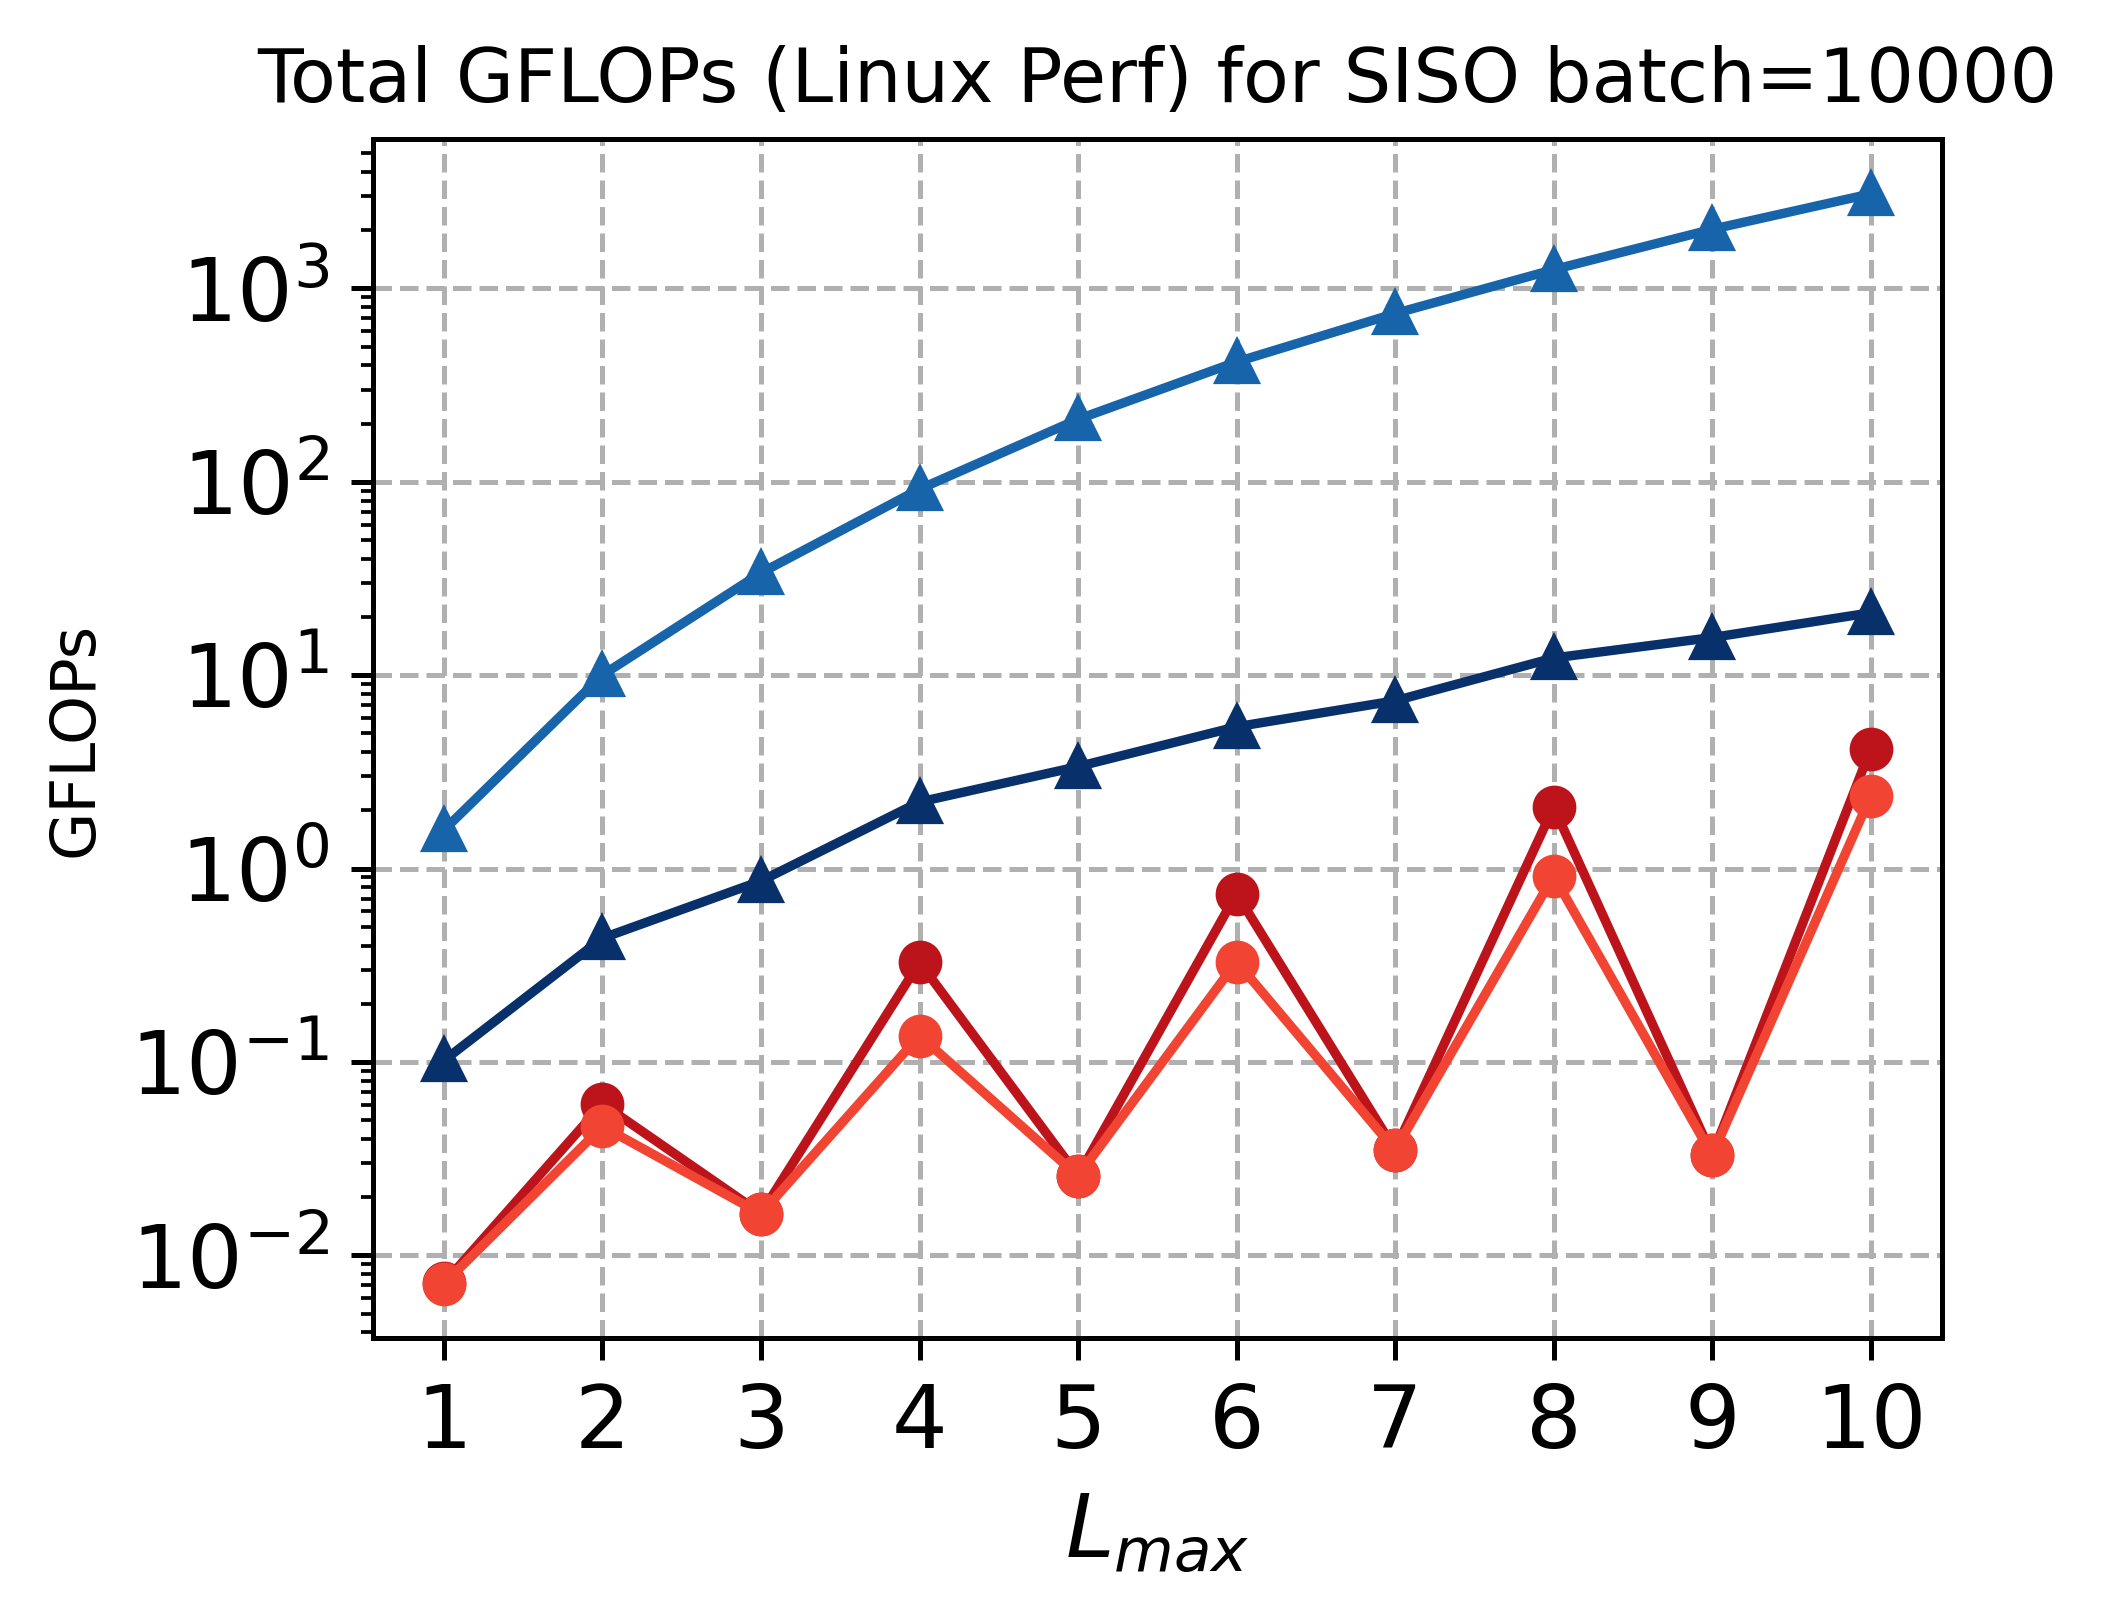

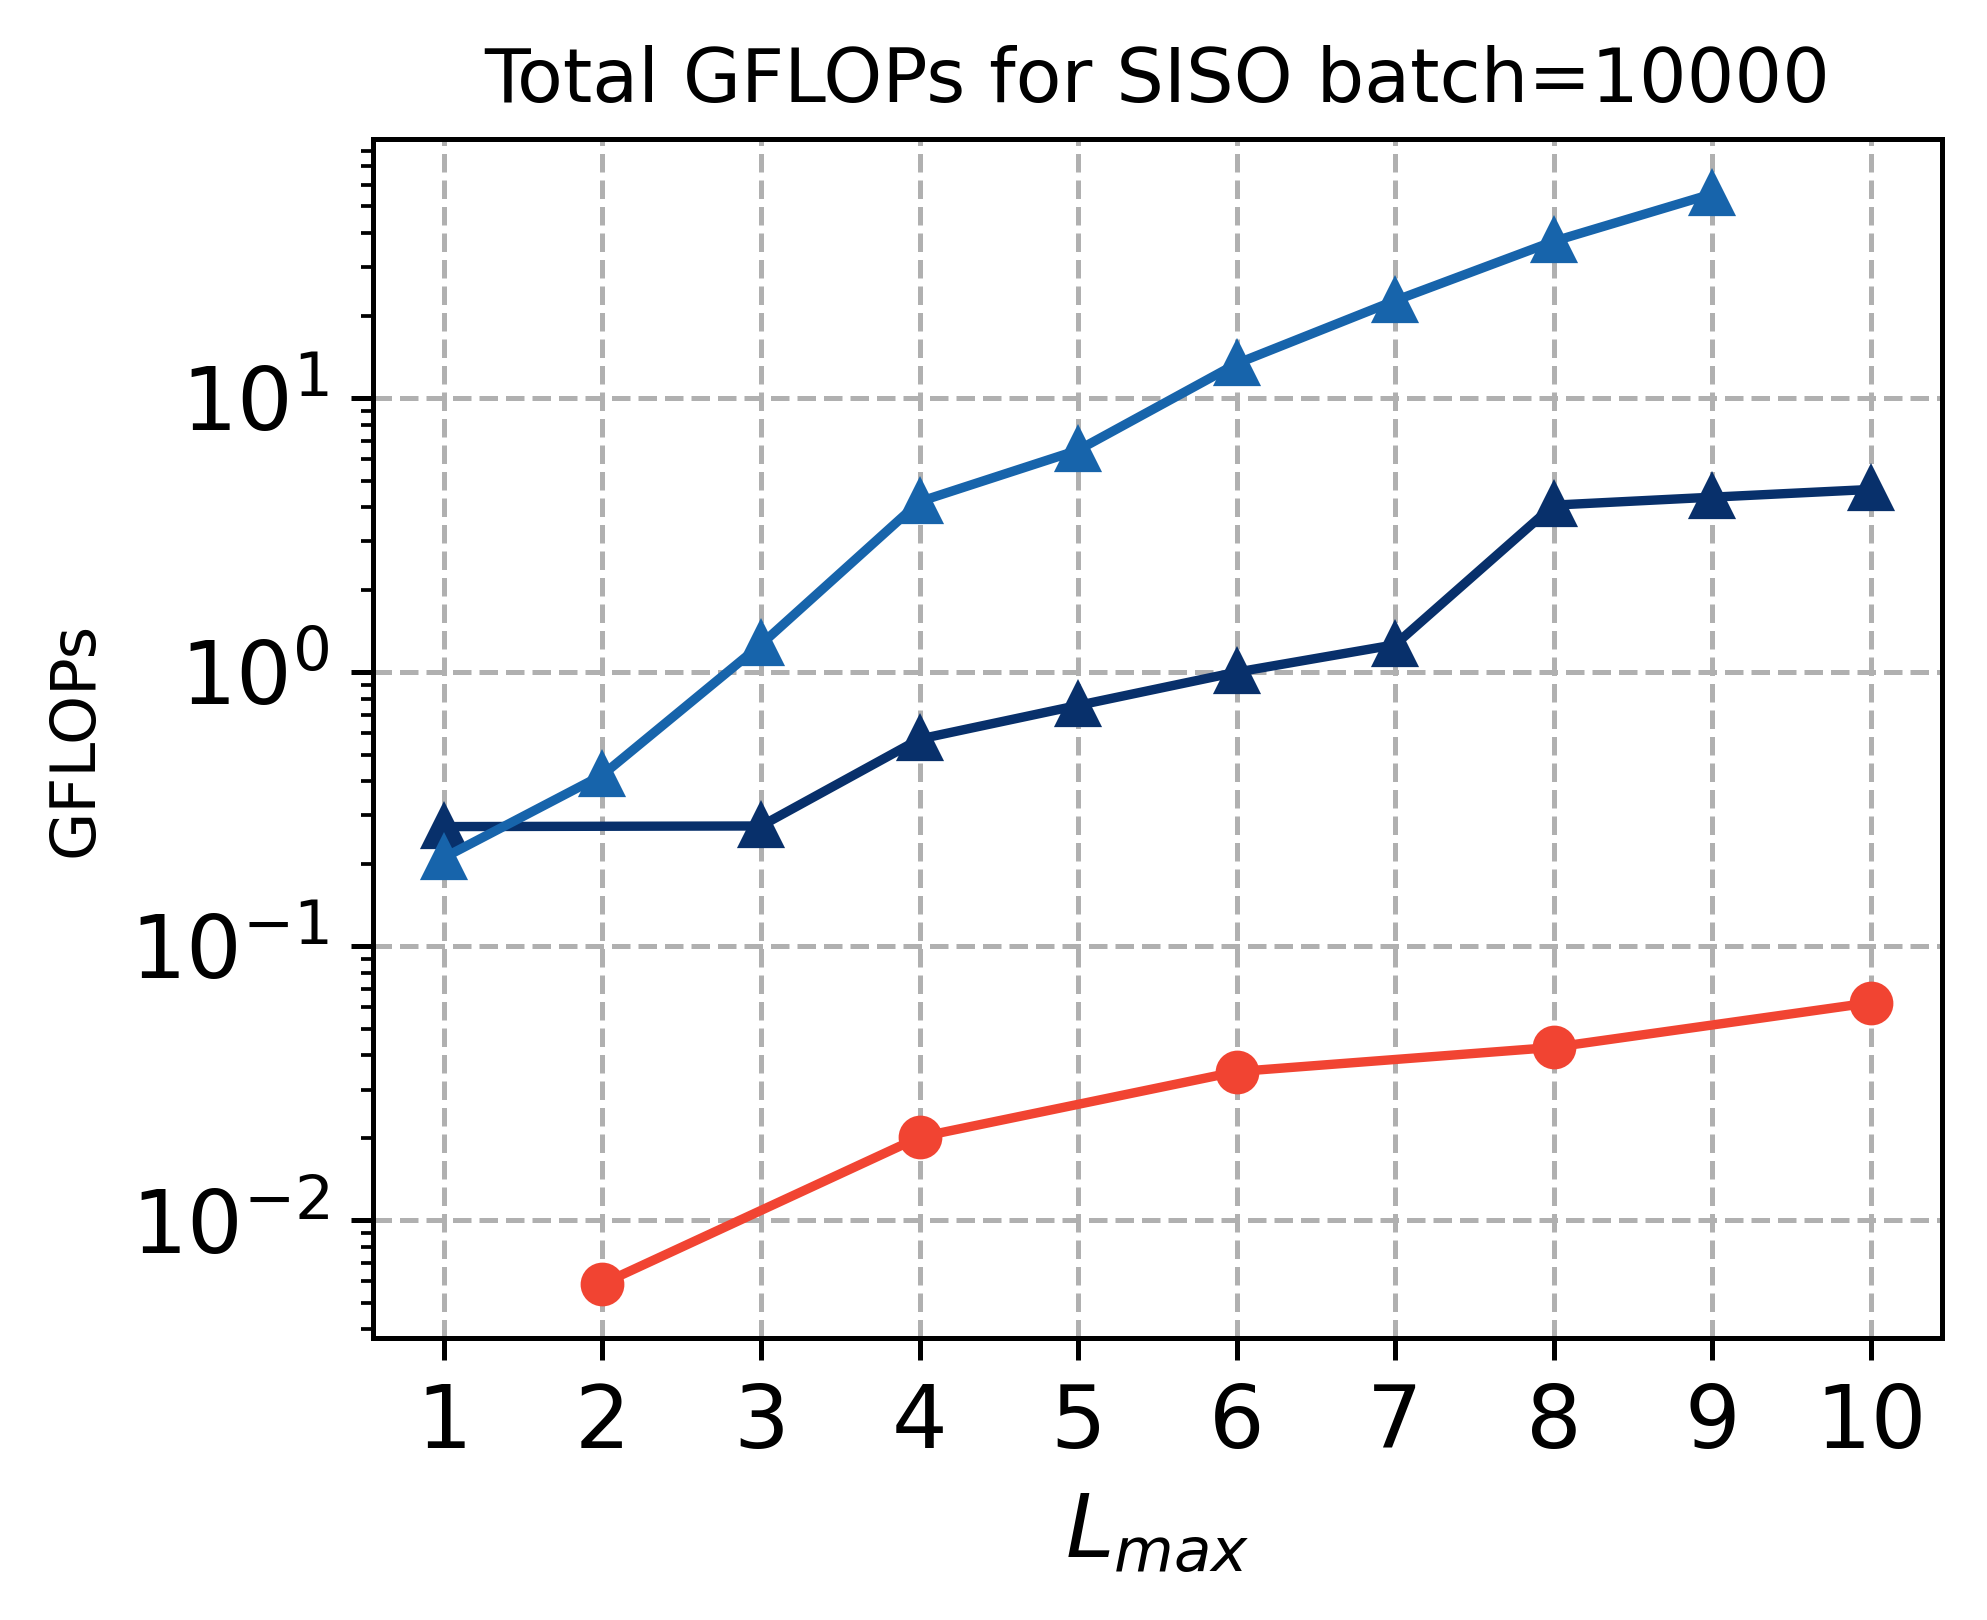

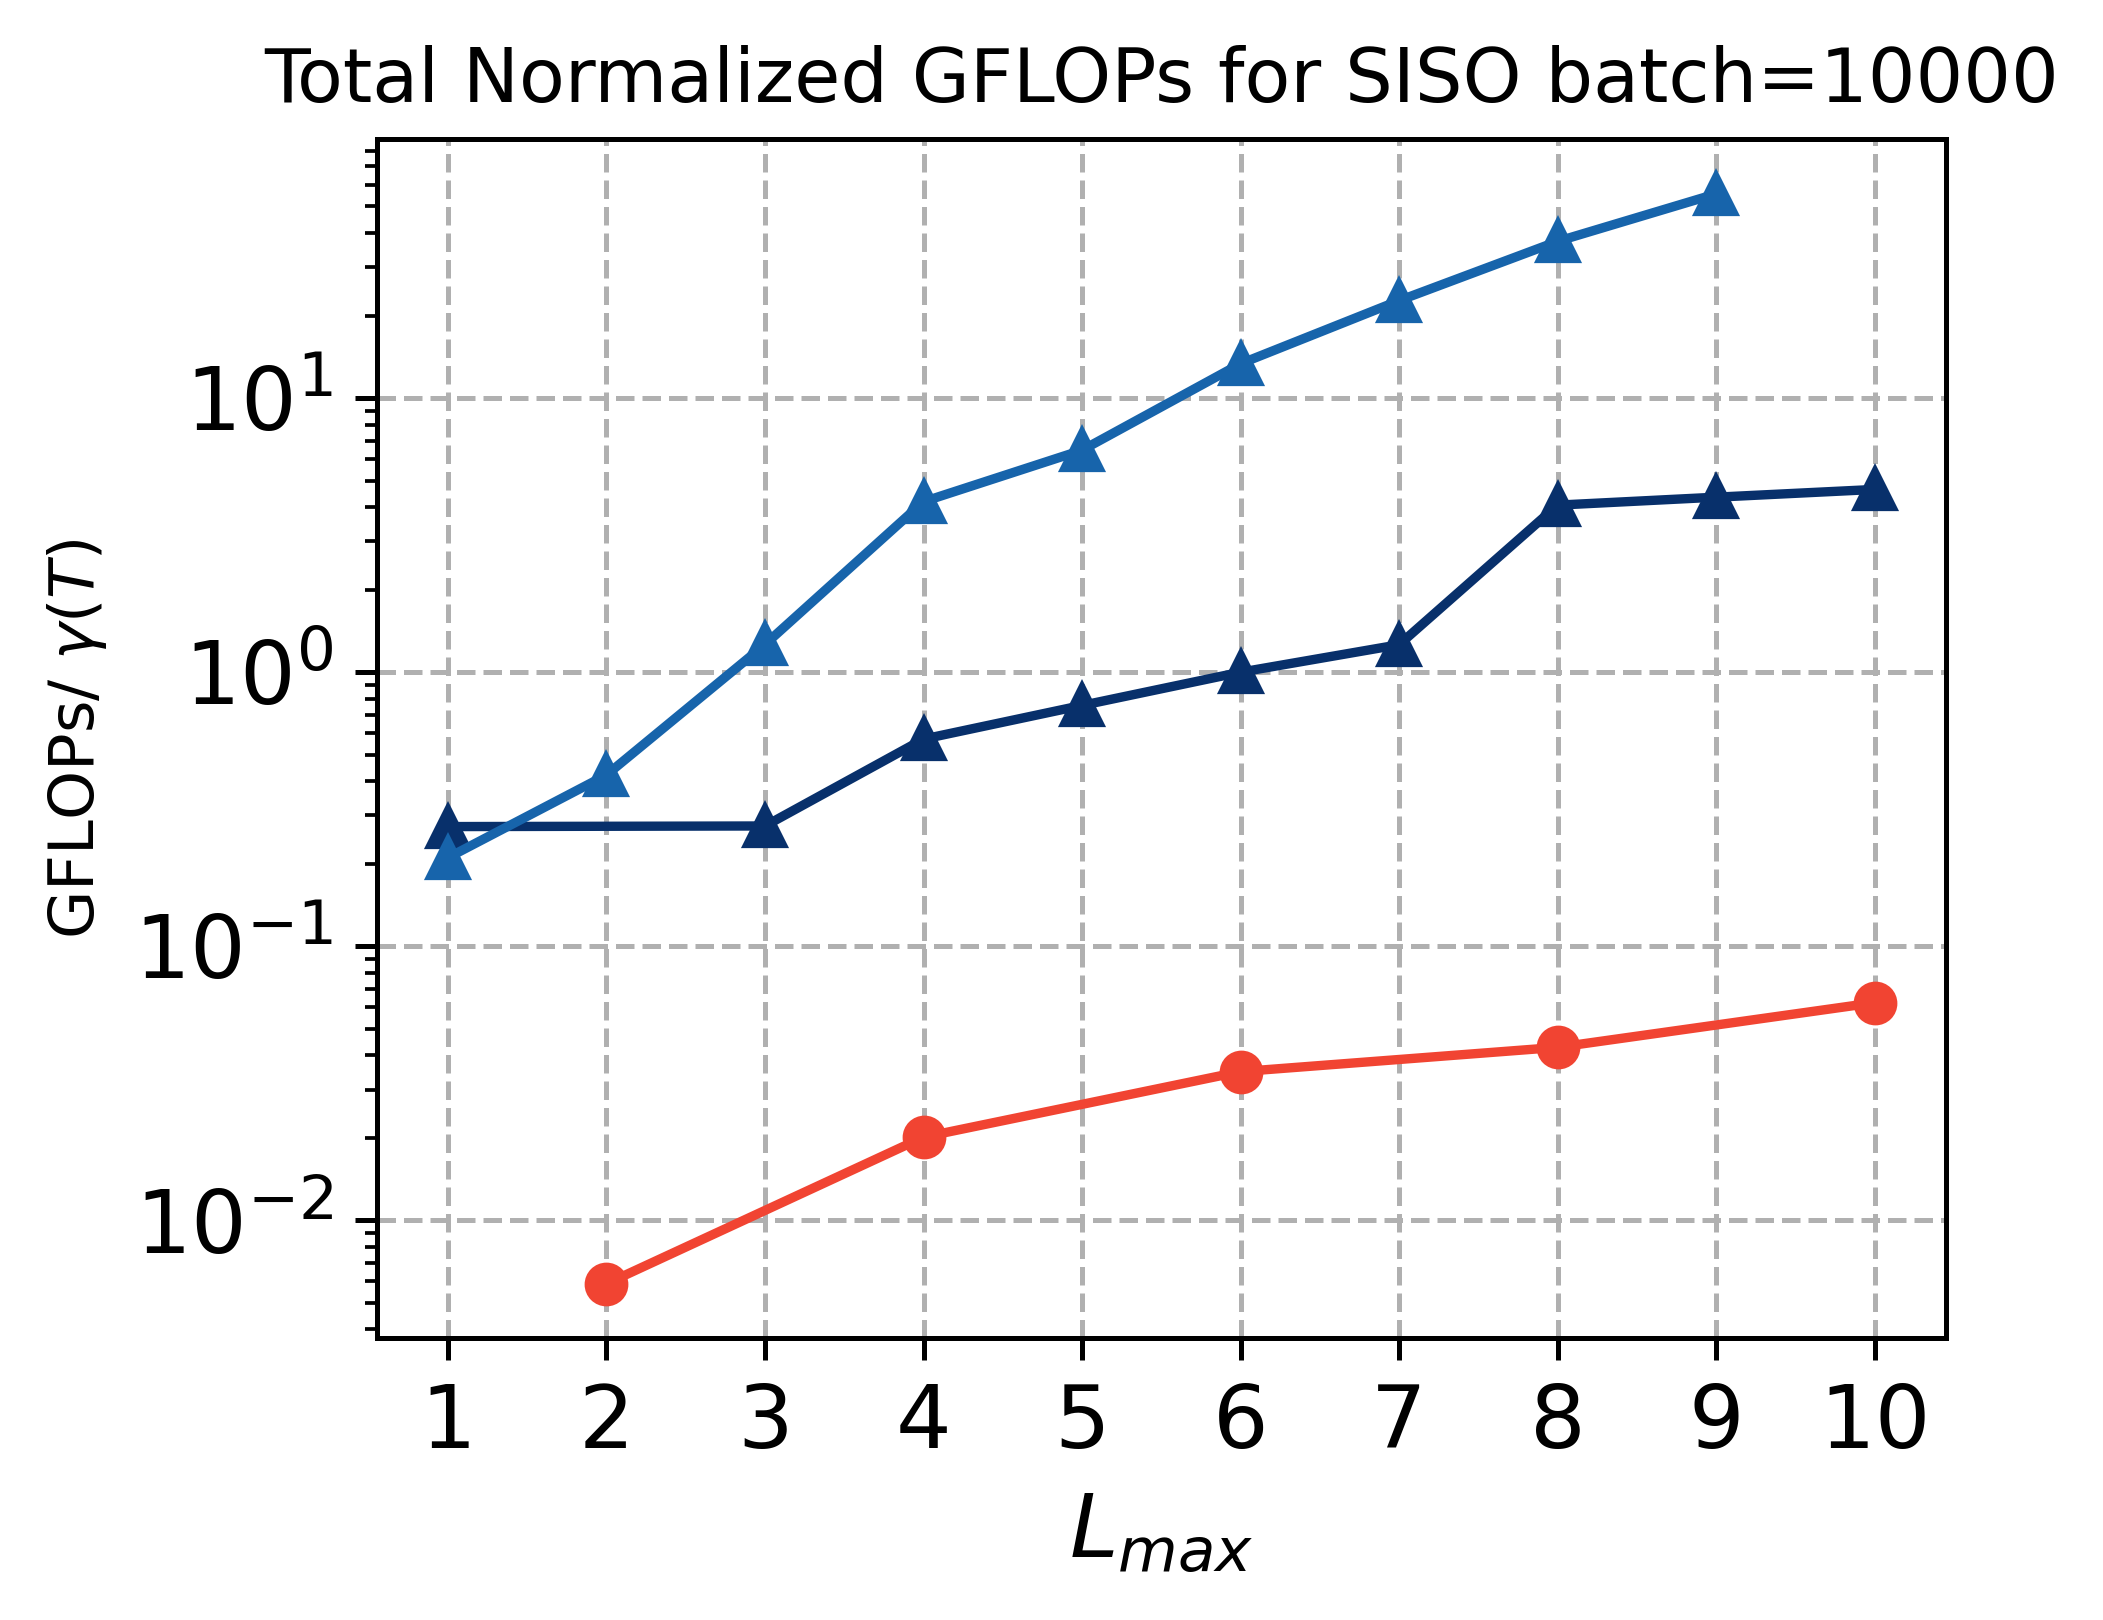

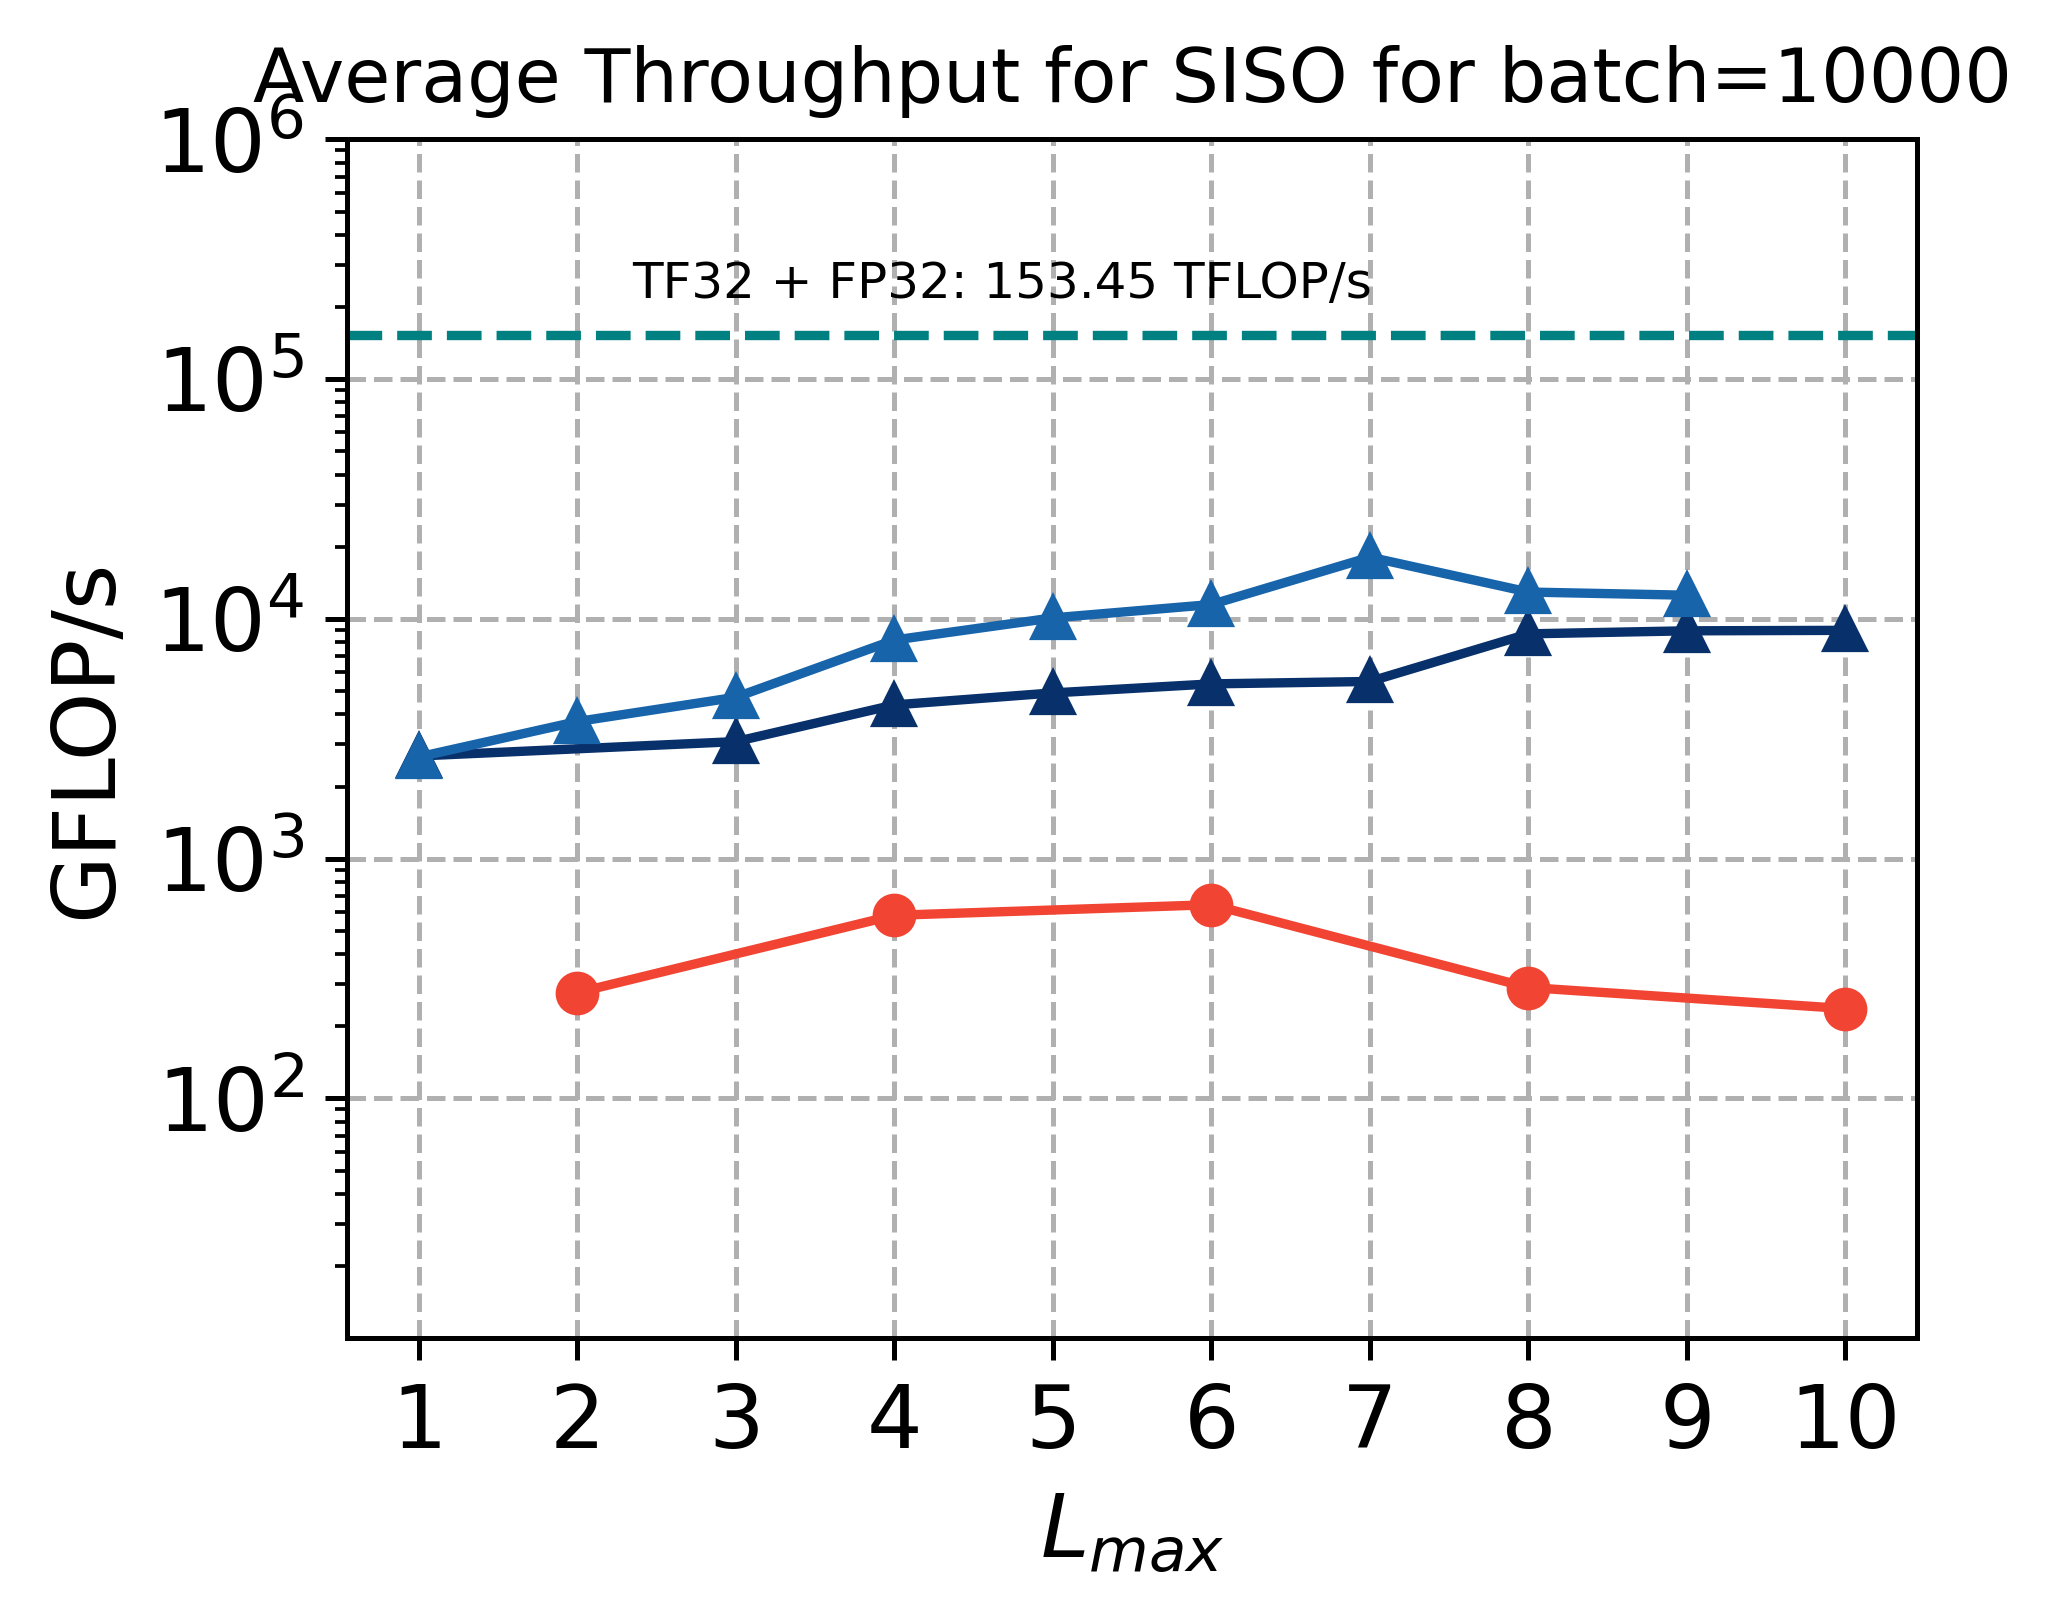

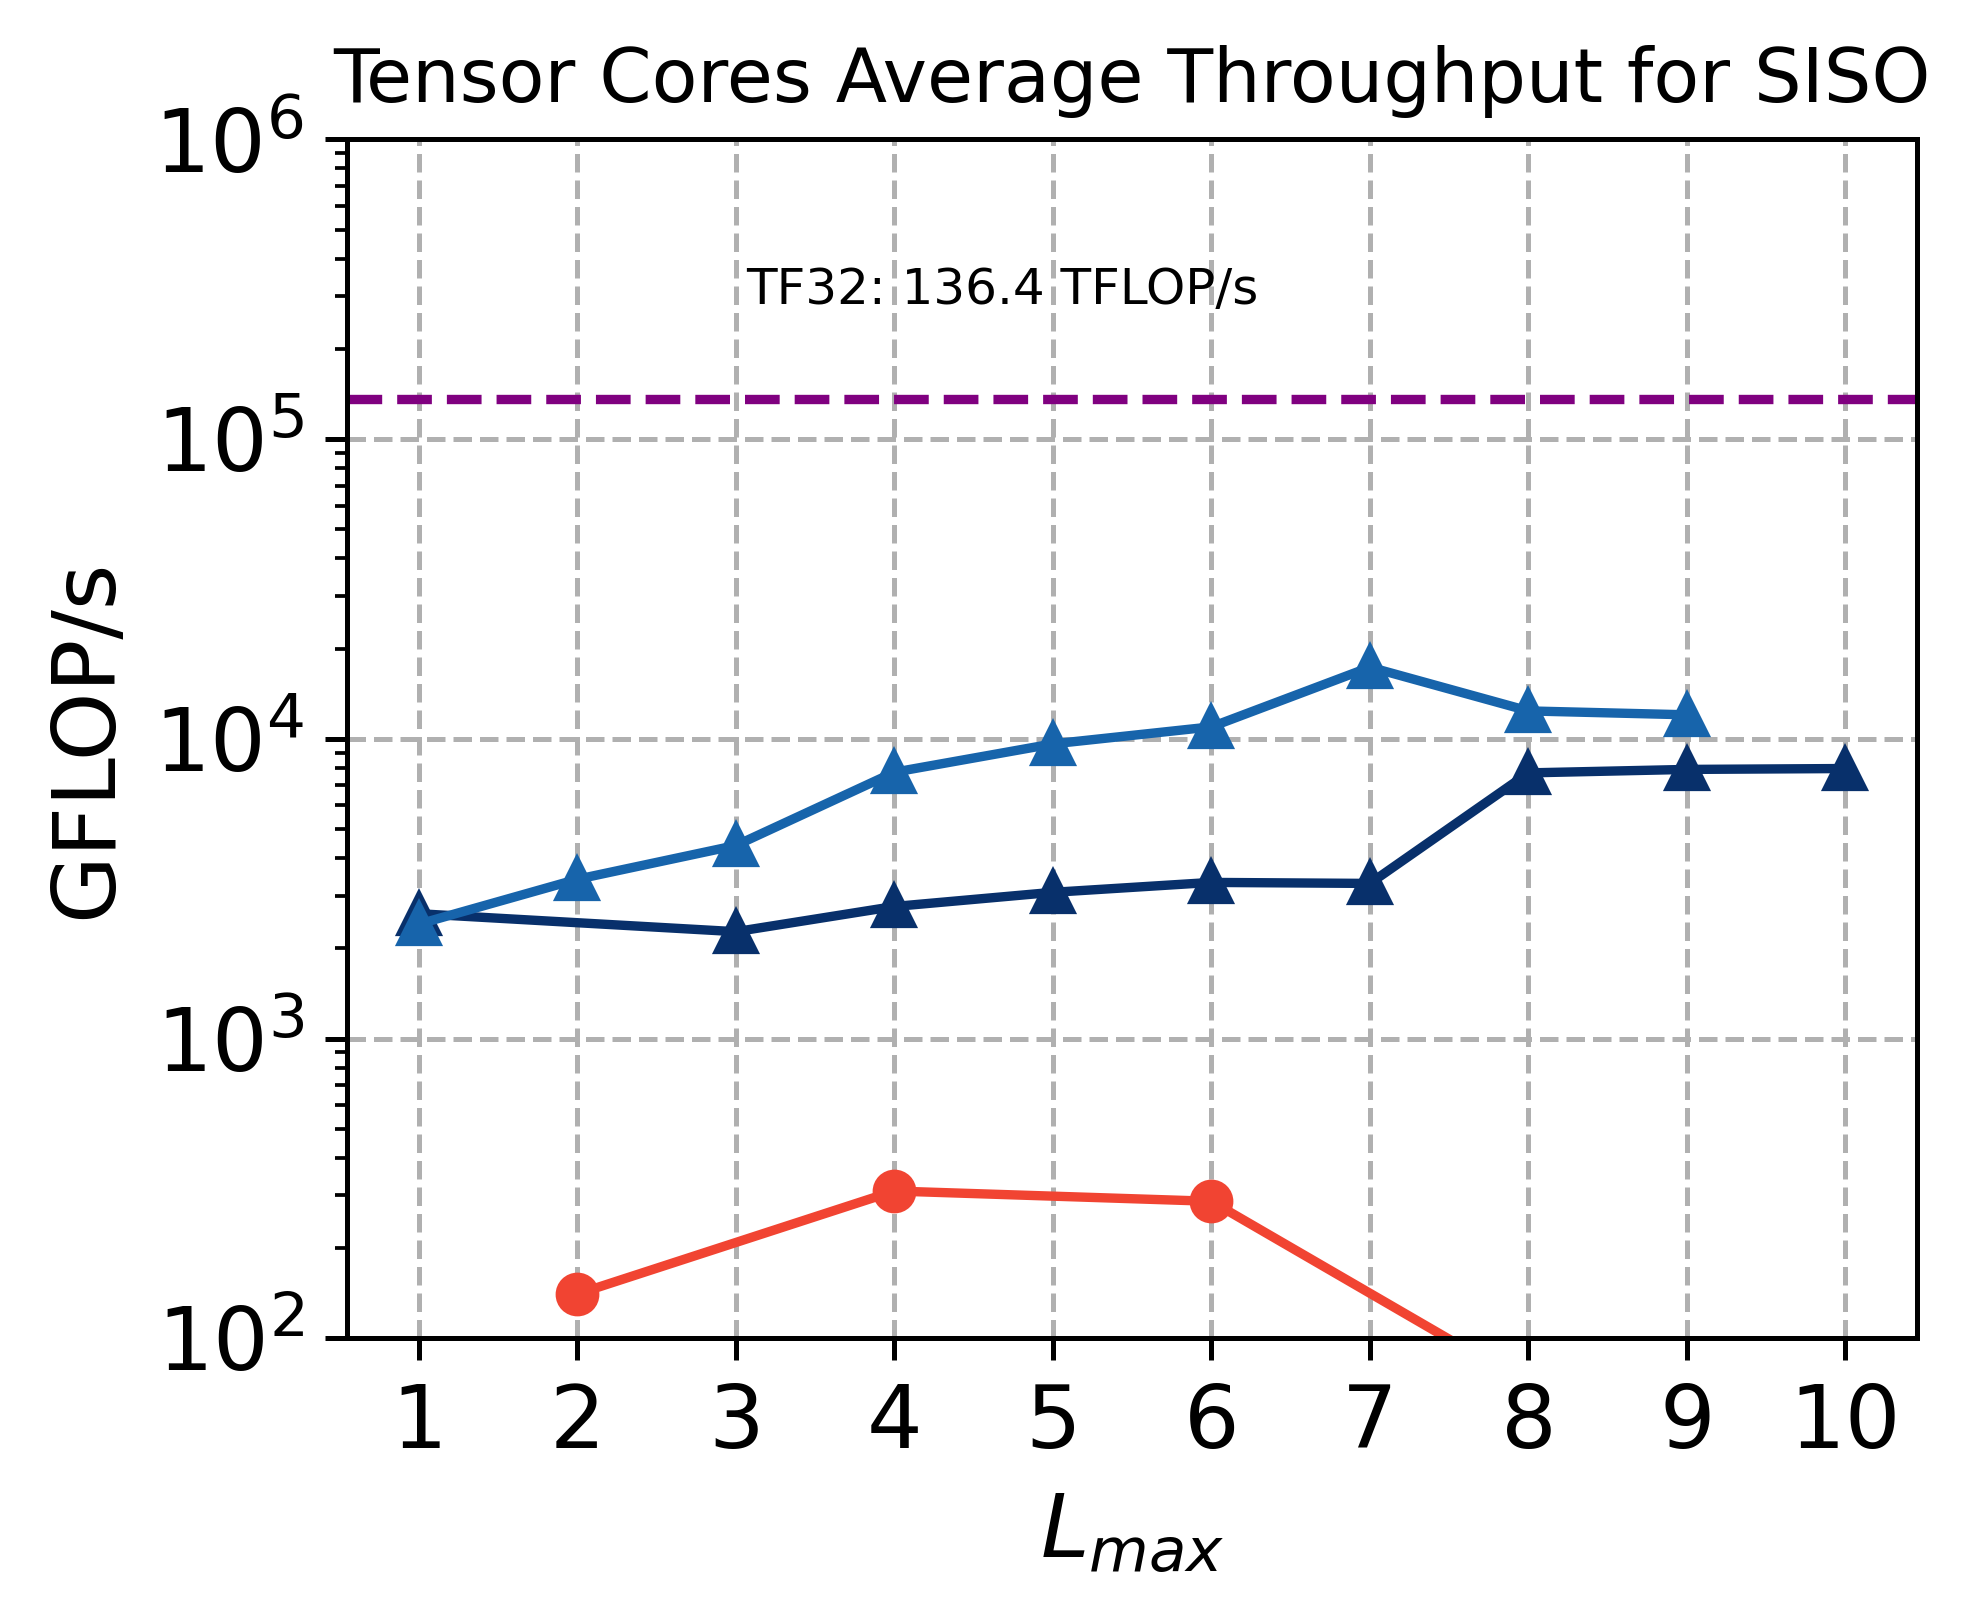

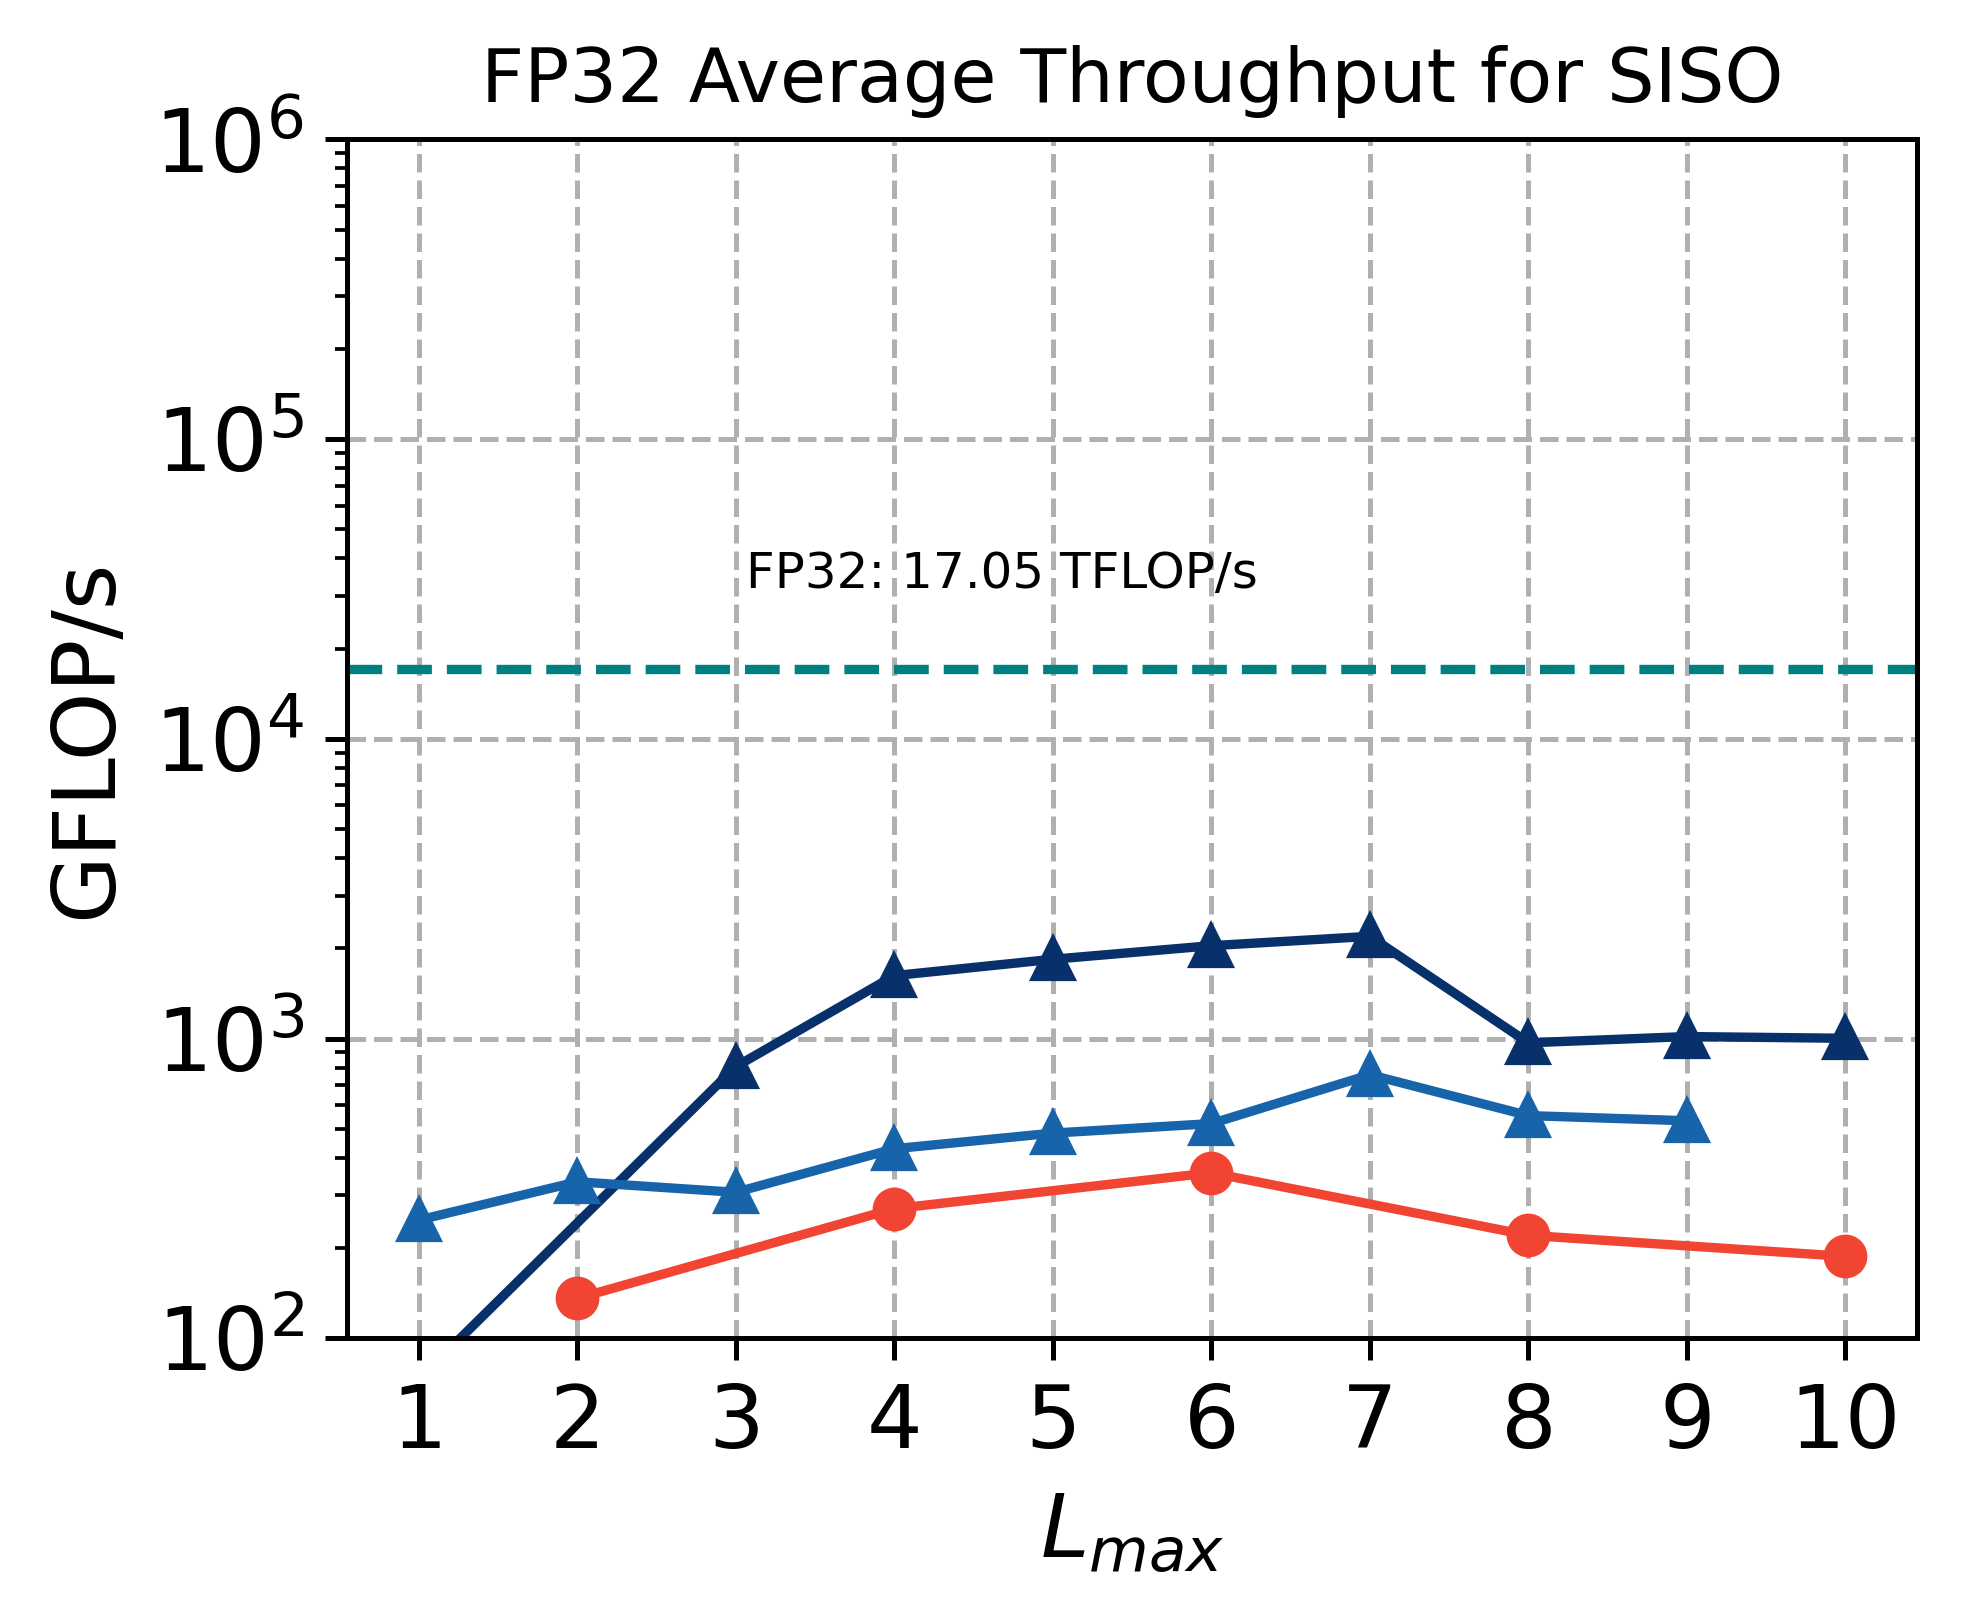

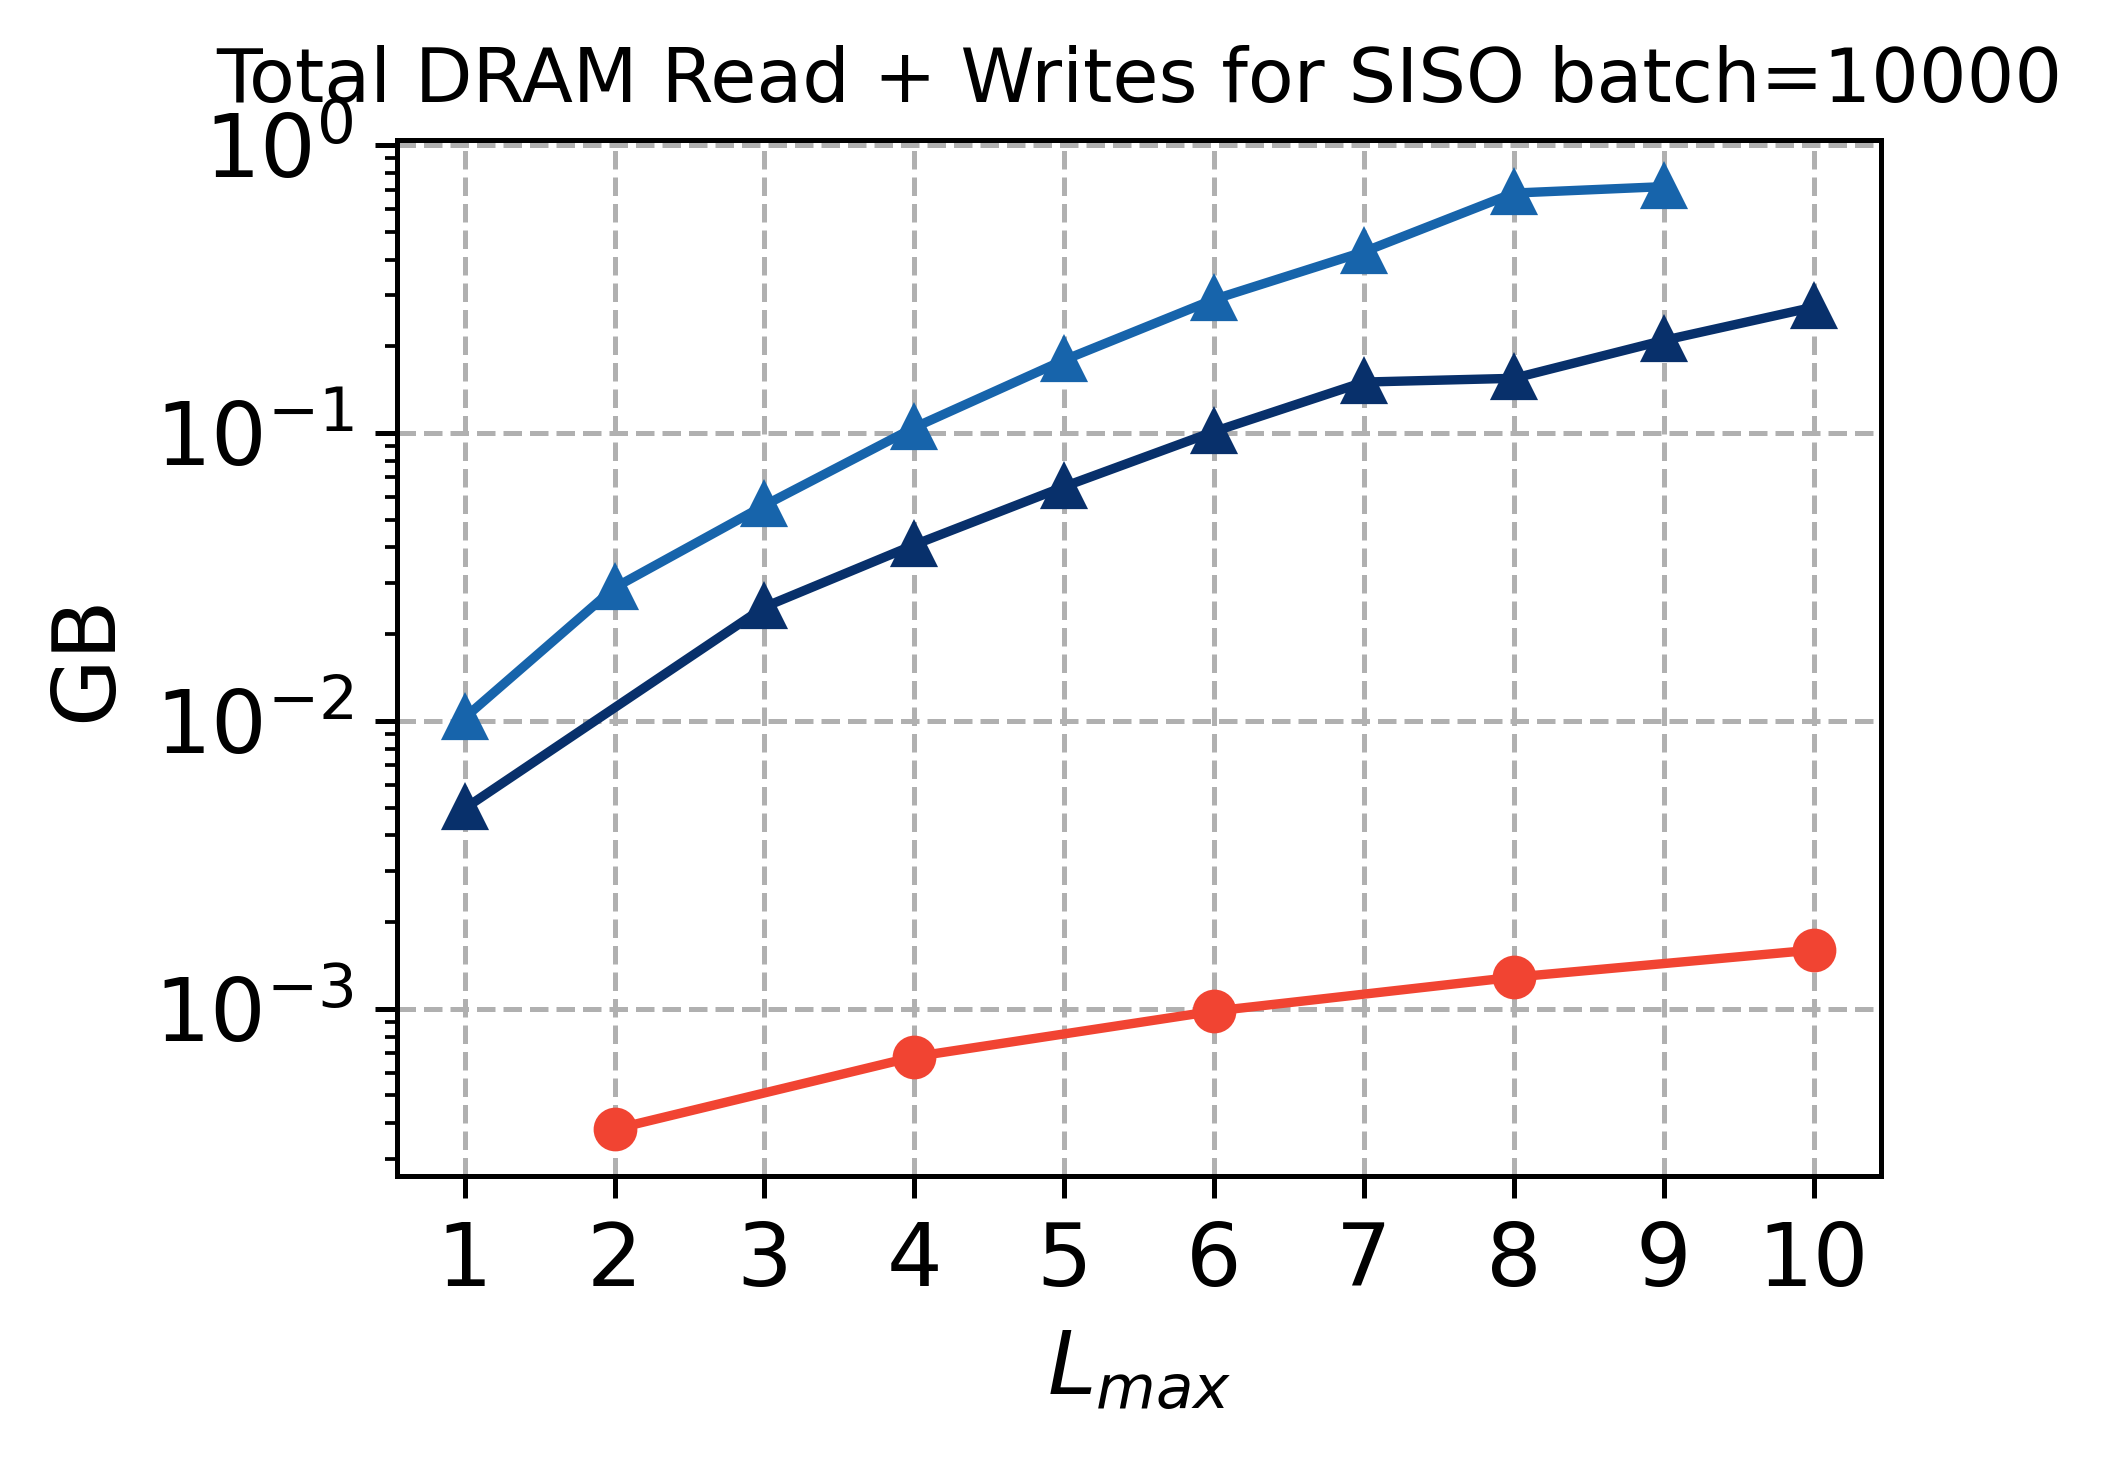

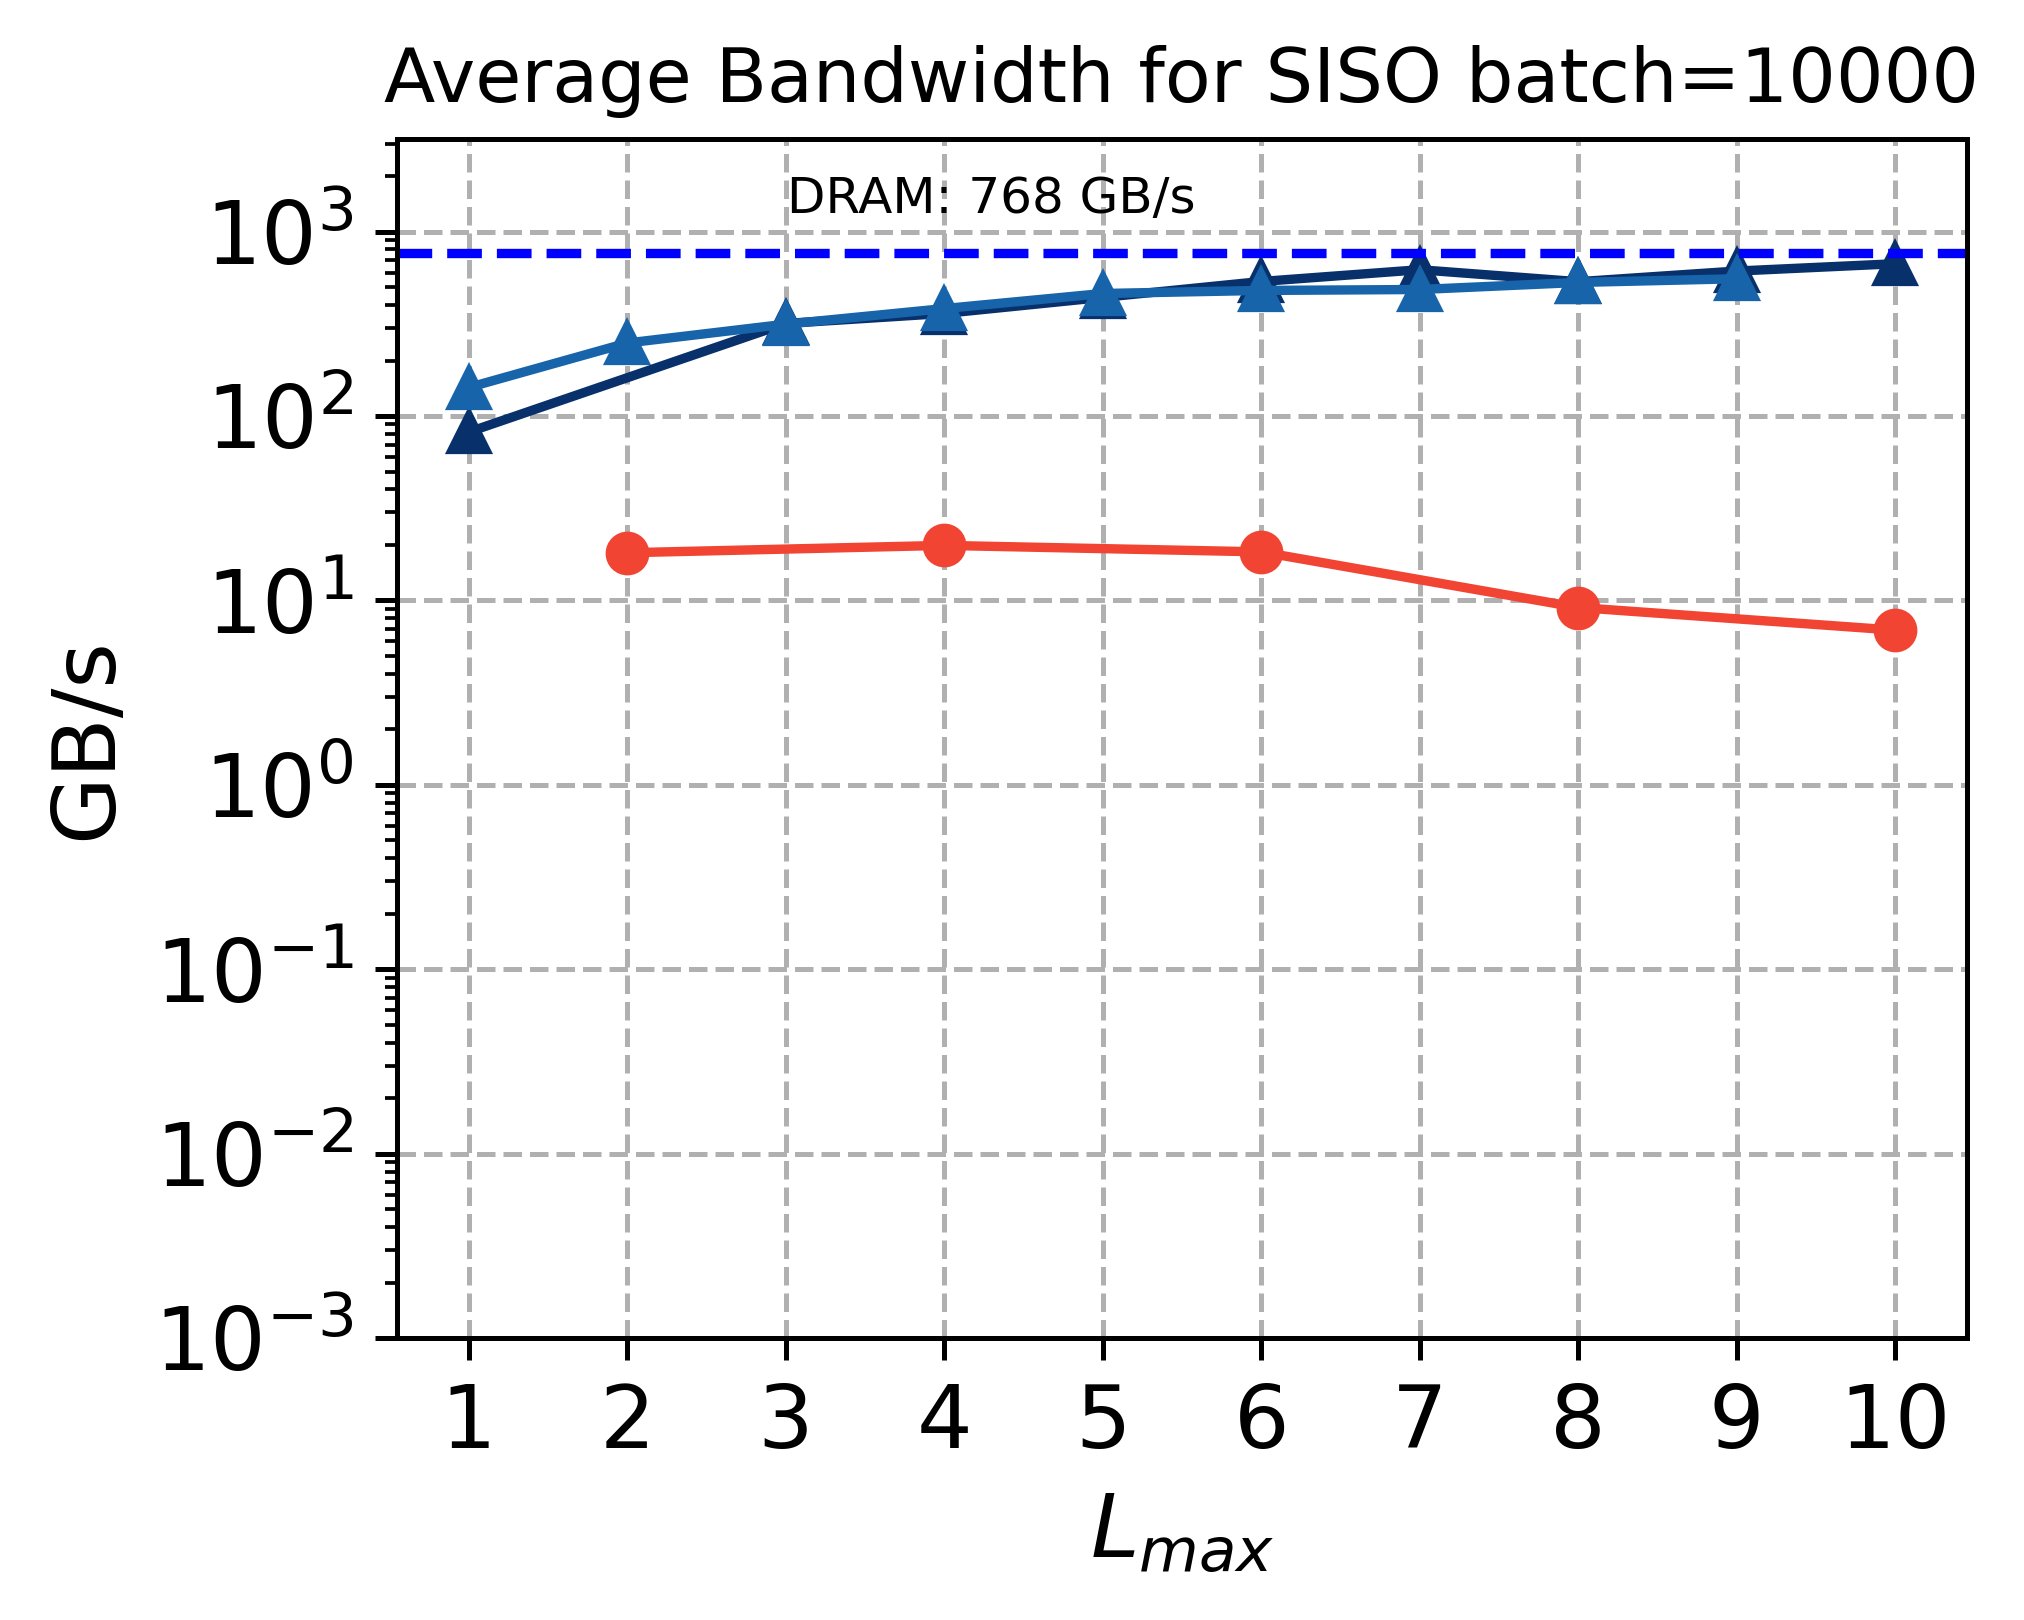

In [20]:
plot_iclr_sweep("SISO", 10000)